`os:` For interacting with the operating system, such as file and directory operations.

`numpy:` Provides support for numerical computations and array manipulations.

`PIL:` Handles image processing tasks like opening and converting images.

`torch:` Core library for creating and training deep learning models with PyTorch.

`shutil:` Facilitates high-level file operations like copying and moving files.

`random:` Used for generating random numbers, helpful for data shuffling and splitting.

`torchvision:` Includes pre-built models, datasets, and image transformations for computer vision.

`matplotlib.pyplot:` Used for creating static, animated, and interactive plots.

`pandas:` Provides data structures and functions for data manipulation and analysis.

`timm:` Provides additional pre-trained models and efficient architectures.

`sklearn.metrics:` Contains tools for evaluating model performance, such as confusion matrix and classification report.

`seaborn:` Extends Matplotlib for more sophisticated data visualizations, like heatmaps.


In [1]:
!pip install kneed

In [2]:
import os
import numpy as np
import pandas as pd
import shutil
import random
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import datasets, transforms, models
import timm
from kneed import KneeLocator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, ParameterGrid
import matplotlib.pyplot as plt
from PIL import Image
import warnings

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [4]:
# Suppressing warning messages to avoid cluttering the output
warnings.filterwarnings("ignore") 

In [5]:
# Reading the CSV file into a DataFrame for data processing
df = pd.read_csv('/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv')

In [6]:
df.head(2)

ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   

  Left-Diagnostic Keywords Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                 cataract             normal fundus  0  0  0  1  0  0  0  0   
1            normal fundus             normal fundus  1  0  0  0  0  0  0  0   

                                            filepath labels  \
0  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   
1  ../input/ocular-disease-recognition-odir5k/ODI...  ['N']   

                     target     filename  
0  [1, 0, 0, 0, 0, 0, 0, 0]  0_right.jpg  
1  [1, 0, 0, 0, 0, 0, 0, 0]  1_right.jpg

In [7]:
# Setting the display option to show all rows in the DataFrame when printing
pd.set_option('display.max_rows', None)

In [9]:
# df['Right-Diagnostic Keywords'].value_counts()

# EDA

In [8]:
# Defining a custom dataset class to handle image paths and transformations
class OcularDataset(Dataset):
    def __init__(self, img_paths, transform=None):
        self.img_paths = img_paths  # Initializing image paths
        self.transform = transform  # Initializing transformation pipeline

    def __len__(self):
        return len(self.img_paths)  # Returning the number of images

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]  # Getting the image path at the given index
        image = Image.open(img_path).convert('RGB')  # Opening the image and converting to RGB
        if self.transform:
            image = self.transform(image)  # Applying transformation if provided
        return image

# Defining the feature extractor using VGG16
class VGG16FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(VGG16FeatureExtractor, self).__init__()
        self.features = model.features  # Extracting convolutional features
        self.avgpool = model.avgpool  # Applying average pooling
        self.flatten = nn.Flatten()  # Flattening the output for fully connected layers
        self.fc_layers = nn.Sequential(*[model.classifier[i] for i in range(6)])  # Extracting first 6 layers from the classifier

    def forward(self, x):
        x = self.features(x)  # Passing input through convolutional layers
        x = self.avgpool(x)  # Applying average pooling
        x = self.flatten(x)  # Flattening the output
        x = self.fc_layers(x)  # Passing through fully connected layers
        return x

# Initializing the VGG16 model and feature extractor
vgg16 = models.vgg16(pretrained=True)  # Loading the pretrained VGG16 model
feature_extractor = VGG16FeatureExtractor(vgg16).eval()  # Creating the feature extractor and setting to evaluation mode

# Defining a transform for image preprocessing
transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Optionally resizing images to 224x224
    transforms.ToTensor(),  # Converting images to tensors
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Optionally normalizing with ImageNet statistics
])

# Function to extract features from images
def extract_features(img_paths, model, transform, device):
    dataset = OcularDataset(img_paths, transform=transform)  # Creating a dataset with image paths and transformations
    loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)  # Creating a DataLoader for batch processing
    
    features = []  # Initializing a list to store extracted features
    model = model.to(device)  # Moving the model to the specified device
    with torch.no_grad():  # Disabling gradient calculation
        for images in loader:
            images = images.to(device)  # Moving images to the specified device
            outputs = model(images)  # Extracting features from the images
            features.append(outputs.cpu())  # Storing features and moving them back to CPU
    return torch.cat(features).numpy()  # Concatenating all features and converting to numpy array


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth

100%|██████████| 528M/528M [00:03<00:00, 164MB/s]  


In [14]:
# Loading image paths from the specified directory
image_dir = '/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images'  # Defining the directory containing the images
# Creating a list of image paths by joining the directory path with each filename
img_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if filename.endswith('.jpg')]  # Filtering only files that end with the '.jpg' extension


In [15]:
# Extracting features
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
# Determining the device to use, either GPU (if available) or CPU
features = extract_features(img_paths, feature_extractor, transform, device)  
# Extracting features from the images using the VGG16 feature extractor

# Determining the optimal number of clusters
inertia = []  # Initializing a list to store inertia values for different numbers of clusters
K = range(1, 11)  # Defining a range for the number of clusters to test
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  
    # Creating a KMeans object with k clusters, a fixed random state, and 10 initializations
    kmeans.fit(features)  # Fitting the KMeans model to the extracted features
    inertia.append(kmeans.inertia_)  # Appending the inertia (sum of squared distances) to the list

# Finding the optimal number of clusters using the elbow method
kl = KneeLocator(K, inertia, curve="convex", direction="decreasing")  
# Creating a KneeLocator object to find the "elbow" point in the inertia curve
optimal_k = kl.elbow  # Getting the optimal number of clusters (k) from the elbow point

# Printing the optimal number of clusters
print(f'Optimal number of clusters: {optimal_k}')  


Optimal number of clusters: 3


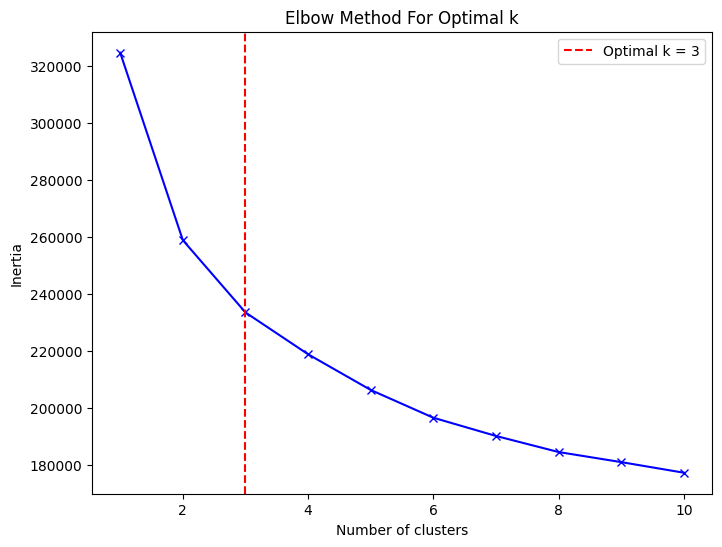

In [16]:
# Plotting the elbow method
plt.figure(figsize=(8, 6))  # Creating a figure with specific dimensions
plt.plot(K, inertia, 'bx-')  # Plotting the number of clusters (K) against inertia with blue cross markers and lines
plt.xlabel('Number of clusters')  # Setting the label for the x-axis
plt.ylabel('Inertia')  # Setting the label for the y-axis
plt.title('Elbow Method For Optimal k')  # Setting the title of the plot
plt.axvline(optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')  
# Adding a vertical line at the optimal number of clusters, with red dashed lines and a label
plt.legend()  # Displaying the legend for the plot
plt.show()  # Displaying the plot


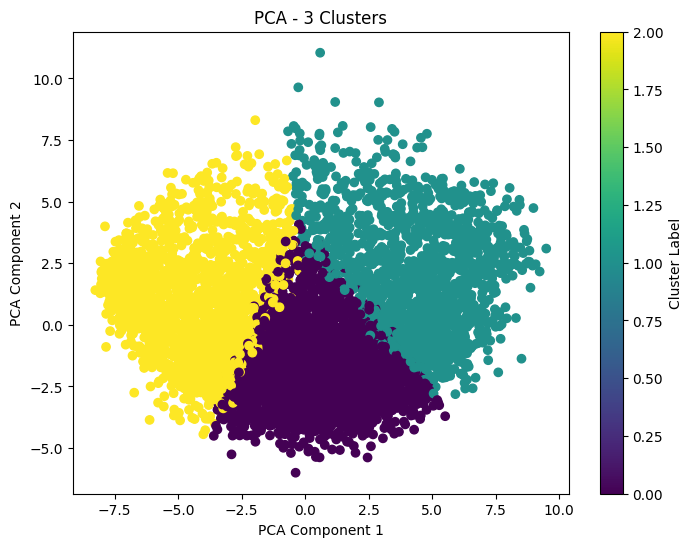

In [17]:
# Performing K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)  # Initializing K-means with 3 clusters, setting random state and initialization
cluster_labels = kmeans.fit_predict(features)  # Fitting the K-means model to the features and predicting cluster labels

# Performing PCA to reduce features to 2D
pca = PCA(n_components=2)  # Initializing PCA to reduce to 2 components
pca_features = pca.fit_transform(features)  # Fitting and transforming the features to 2D using PCA

# Plotting the clusters
plt.figure(figsize=(8, 6))  # Creating a figure with specific dimensions
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_labels, cmap='viridis', marker='o')  
# Plotting the PCA-reduced features with different colors for each cluster
plt.title('PCA - 3 Clusters')  # Setting the title of the plot
plt.xlabel('PCA Component 1')  # Setting the label for the x-axis
plt.ylabel('PCA Component 2')  # Setting the label for the y-axis
plt.colorbar(label='Cluster Label')  # Adding a color bar with a label for the cluster labels
plt.show()  # Displaying the plot


# ** Preprocessing **

### The images right now are not in a proper labeled format, for futher classification process, the images needs be classified into right labels.
### The below given code is used fo classification of the images into 3 different categories of images.
### The images are classified into 3 categories right now is because the eye images are much similar to each other so it will create biased results when classifying the images into different categories, so, that is the reason the images are classified into only 3 categories for now.

In [8]:
# Defining the custom function for exact keyword matching to specific labels
def map_to_label_exact(keyword):
    if keyword == 'normal fundus':
        return 'Normal Fundus'  # Mapping 'normal fundus' to 'Normal Fundus'
    elif keyword == 'retinopathy':
        return 'Diabetes'  # Mapping 'retinopathy' to 'Diabetes'
    elif keyword == 'severe nonproliferative retinopathy':
        return 'Diabetes'  # Mapping 'severe nonproliferative retinopathy' to 'Diabetes'
    elif keyword == 'cataract':
        return 'Cataract'  # Mapping 'cataract' to 'Cataract'
    elif keyword == 'moderate non proliferative retinopathy':
        return 'Diabetes'  # Mapping 'moderate non proliferative retinopathy' to 'Diabetes'
#     elif keyword == 'pathological myopia':
#         return 'Pathological Myopia'  # Mapping 'pathological myopia' to 'Pathological Myopia' (commented out)
#     elif keyword == 'dry age-related macular degeneration':
#         return 'Age-related Macular Degeneration'  # Mapping 'dry age-related macular degeneration' to 'Age-related Macular Degeneration' (commented out)
    elif keyword == 'glaucoma':
        return 'Glaucoma'  # Mapping 'glaucoma' to 'Glaucoma'
    elif keyword == 'drusen':
        return 'Drusen'  # Mapping 'drusen' to 'Drusen'
#     elif keyword == 'hypertensive retinopathy':
#         return 'Hypertension'  # Mapping 'hypertensive retinopathy' to 'Hypertension' (commented out)
    else:
        return 'Other diseases/abnormalities'  # Default mapping for all other cases

# Applying the custom function to map the 'Right-Diagnostic Keywords' and 'Left-Diagnostic Keywords' columns
df['right_label_column'] = df['Right-Diagnostic Keywords'].apply(map_to_label_exact)  # Mapping right eye keywords to labels
df['left_label_column'] = df['Left-Diagnostic Keywords'].apply(map_to_label_exact)  # Mapping left eye keywords to labels

# Creating separate DataFrames for right and left eye diagnostic keywords and labels
df_right = df[['Right-Diagnostic Keywords', 'right_label_column']]  # Creating a DataFrame for the right eye
df_left = df[['Left-Diagnostic Keywords', 'left_label_column']]  # Creating a DataFrame for the left eye


In [9]:
# Concatenating the 'Right-Fundus' image file paths to the 'df_right' DataFrame
df_right = pd.concat([df_right, df[['Right-Fundus']]], axis=1)

# Renaming columns in 'df_right' to more descriptive names
df_right.rename(columns={"right_label_column": "disease", "Right-Fundus": "image_file"}, inplace=True)

# Dropping the original 'Right-Diagnostic Keywords' column from 'df_right' since it's no longer needed
df_right.drop("Right-Diagnostic Keywords", axis=1, inplace=True)

# Concatenating the 'Left-Fundus' image file paths to the 'df_left' DataFrame
df_left = pd.concat([df_left, df[['Left-Fundus']]], axis=1)

# Renaming columns in 'df_left' to more descriptive names
df_left.rename(columns={"left_label_column": "disease", "Left-Fundus": "image_file"}, inplace=True)

# Combining the 'df_right' and 'df_left' DataFrames into a single DataFrame 'df_labeled'
df_labeled = pd.concat([df_right, df_left])

# Dropping the original 'Left-Diagnostic Keywords' column from 'df_labeled' since it's no longer needed
df_labeled.drop("Left-Diagnostic Keywords", axis=1, inplace=True)

# Counting the occurrences of each disease label in the 'disease' column
df_labeled['disease'].value_counts()


disease
Normal Fundus                   5501
Other diseases/abnormalities    4350
Diabetes                        1748
Cataract                         518
Glaucoma                         397
Drusen                           270
Name: count, dtype: int64

# There are two types of images in the dataset, the Right eye image and, the Left eye image, the labele attatched to a particular eye image is matched with the diseease keyword if both the keywords are a match then the particular eye image will be given a label of that disease in a new column.


In [10]:
df_labeled.head()

disease   image_file
0                 Normal Fundus  0_right.jpg
1                 Normal Fundus  1_right.jpg
2                      Diabetes  2_right.jpg
3  Other diseases/abnormalities  4_right.jpg
4                      Diabetes  5_right.jpg

#### As we are proceeding with 3 categories of eye disease classification, the fourthc class `other diseases` which contains all the non classified eye disease images, removing the fourth class to avoid any distraction for the model to understand the patterns among 3 categories of the disease.

In [11]:
# Filtering 'df_labeled' to include only rows where the 'disease' column has values 'Glaucoma', 'Cataract', or 'Diabetes'
df_labeled = df_labeled.loc[(df_labeled['disease'] == 'Glaucoma') | 
                            (df_labeled['disease'] == 'Cataract') | 
                            (df_labeled['disease'] == 'Diabetes')]

#### The images are classified into categories, now the task is to store the labeled images into their respected disease folder, the `classified_images` folder, which will contain folders of disease containing eye images of the particular disease.

In [12]:
# Creating the main directory 'classified_images/train' and any necessary parent directories if they do not already exist
base_dir = 'classified_images/train'
os.makedirs(base_dir, exist_ok=True)

# Creating subdirectories for each unique label in 'df_labeled'
labels = df_labeled['disease'].unique()
for label in labels:
    os.makedirs(os.path.join(base_dir, label), exist_ok=True)

# Defining the source directory containing the images
source_dir = '/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/'

# Iterating over each row in 'df_labeled' to copy images to the corresponding folders
for index, row in df_labeled.iterrows():
    source_file = os.path.join(source_dir, row['image_file'])  # Constructing the path to the image in the source directory
    label = row['disease']  # Getting the label for the image
    dest_folder = os.path.join(base_dir, label)  # Defining the destination folder based on the label
    dest_file = os.path.join(dest_folder, row['image_file'])  # Defining the destination path for the image

    # Checking if the source file exists before attempting to copy
    if not os.path.isfile(source_file):
        print(f"File {source_file} does not exist.")
        continue

    # Copying the image file from the source to the destination folder
    shutil.copy2(source_file, dest_file)
#     print(f"Copied {source_file} to {dest_file}")  # Optionally printing the copied file paths


#### Becuase we have created a new folder for the images classified, we only have the train set for the images, creating a test set for model training is essential.

In [13]:
# Setting the directories for training and testing images
train_dir = './classified_images/train'
test_dir = './classified_images/test'

# Creating the test directory if it does not already exist
os.makedirs(test_dir, exist_ok=True)

# Defining the proportion of the dataset to be used for the test set
test_size = 0.2

# Iterating over each label folder in the training directory
for label_folder in os.listdir(train_dir):
    label_train_dir = os.path.join(train_dir, label_folder)  # Constructing the path to the current label's training folder
    label_test_dir = os.path.join(test_dir, label_folder)  # Constructing the path to the current label's test folder
    
    # Creating the corresponding label folder in the test directory
    os.makedirs(label_test_dir, exist_ok=True)
    
    # Listing all images in the current label folder
    images = os.listdir(label_train_dir)
    
    # Shuffling the list of images to ensure random sampling
    random.shuffle(images)
    
    # Calculating the number of images to be moved to the test set
    num_test_images = int(len(images) * test_size)
    
    # Selecting images to be moved to the test set
    test_images = images[:num_test_images]
    
    # Moving the selected test images from the training folder to the test folder
    for image in test_images:
        src_path = os.path.join(label_train_dir, image)  # Constructing the path to the source image file
        dst_path = os.path.join(label_test_dir, image)  # Constructing the path to the destination image file
        shutil.move(src_path, dst_path)  # Moving the image file

print("Test set created successfully.")


Test set created successfully.


In [14]:
# Loading the directories
train_dir = '/kaggle/working/classified_images/train'
test_dir = '/kaggle/working/classified_images/test'
traininig_dataset_path = '/kaggle/working/classified_images/train'
test_dataset_path = '/kaggle/working/classified_images/test'

#### datasets.ImageFolder creates a dataset from image files organized in subdirectories, where each subdirectory name is treated as a class label. The transform parameter applies preprocessing (e.g., resizing, normalization) to each image in the dataset.

#### Displaying the preprocessed images to check the outcome of the image preprocessing 

In [16]:
def show_transformed_images(dataset):
    # Creating a DataLoader to load a batch of images from the dataset
    loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)
    
    # Getting the first batch of images and labels from the DataLoader
    batch = next(iter(loader))
    images, labels = batch

    # Creating a grid from the images
    grid = torchvision.utils.make_grid(images, nrow=3)
    
    # Displaying the image grid
    plt.figure(figsize=(11,11))  # Setting the figure size
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))  # Converting the grid to a numpy array and transposing it for display
    plt.axis('off')  # Hiding the axis
    plt.show()  # Showing the plot

    # Printing the labels of the images
    print('Labels:', labels)


# This is the image quality when scaled to 128 pixels

In [ ]:
# Define your transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resizing images to 128x128 (or any size you need)
    transforms.ToTensor()           # Converting images to tensors
])

# Load dataset with transformations
dataset = datasets.ImageFolder(root='/kaggle/working/classified_images/train', transform=transform)

# Call the function to show images
show_transformed_images(dataset)

# This is the image quality like when scaled to 224 pixels

In [ ]:
# Define your transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing images to 224x224
    transforms.ToTensor()           # Converting images to tensors
])

# Load dataset with transformations
dataset = datasets.ImageFolder(root='/kaggle/working/classified_images/train', transform=transform)

# Call the function to show images
show_transformed_images(dataset)

# This is the image quality when scaled to 448 pixels

In [ ]:
# Define your transformations
transform = transforms.Compose([
    transforms.Resize((448, 448)),  # Resize images to 448x448
    transforms.ToTensor()           # Convert images to tensors
])

# Load dataset with transformations
dataset = datasets.ImageFolder(root='/kaggle/working/classified_images/train', transform=transform)

# Call the function to show images
show_transformed_images(dataset)

# This is the original image quality without any pixel reducing i.e. (original images)

In [ ]:
# Define your transformations
transform = transforms.Compose([
    # transforms.Resize((448, 448)),  # Resize images to 448x448 (commented out)
    transforms.ToTensor()           # Convert images to tensors
])

# Load dataset with transformations
dataset = datasets.ImageFolder(root='/kaggle/working/classified_images/train', transform=transform)

# Call the function to show images
show_transformed_images(dataset)


# Counting the number of images

In [43]:
import os

def count_images_in_directory(directory_path):
    class_counts = {}
    for class_name in os.listdir(directory_path):
        class_dir = os.path.join(directory_path, class_name)
        if os.path.isdir(class_dir):
            # Count files with common image extensions
            image_count = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])
            class_counts[class_name] = image_count
    return class_counts

train_count_dir = '/kaggle/working/classified_images/train'
val_count_dir = '/kaggle/working/classified_images/train'

train_class_counts = count_images_in_directory(train_count_dir)
val_class_counts = count_images_in_directory(val_count_dir)

print(f"Training images count by class: {train_class_counts}")
print(f"Validation images count by class: {val_class_counts}")

Training images count by class: {'Cataract': 210, 'Glaucoma': 160, 'Diabetes': 712}

Validation images count by class: {'Cataract': 210, 'Glaucoma': 160, 'Diabetes': 712}


In [44]:
712+160+210

1082

### The preprocessing part ends here

### It is true that normalization scales pixel values to a consistent range, improving model training stability and performance which is achieved by adjusting pixel values based on the mean and standard deviation of the dataset.

### But, becuase we are working with eye disease, which is a medical domain analysis, keeping the images into it's raw form is necessary, if normalized using mean or median, then the images will not look as original as it is actually and ultimately will produce more biases in the results.

## The further idea is to, do various experiments on the images we have with context to how does nn (neural network) models are performing with different scenarios.

#### Experiment 1: First try running a basic machine learninig model (SVM) and check whether it could perform good with existing resources, then try training model with original size of the images, for which we will use SimpleCNN model. 

#### Experiment 2: While trying these models with our images, simultenously we will check, how the model performs when we feed the images of differnet qualities, for example. when we reduce the image sizes to 128 what is the result of the model, same for 224 and 448 size of images. And try using k-fold cross validation with all the models.

#### Experiment - 3 : Try a gridCV run and find the optimal numbers of parameter for simpleCNN.

#### Experiment - 4 : Try simpleCNN model with the parameters which performed better in gridCV run, and run the model and whith those parametere to check if any changes is happening or not.

### Tying SVM, tried using a simple machin learning algorithgm for image classification, but becuase the algorithm is not optimized for gpu, it didn't worked well, the process was stuck at one point and was not running even one epoch for 15 minutes.

# --------------SVM not working ----------

In [ ]:
def train_and_evaluate_svm(train_loader, test_loader, n_epochs):
    # Getting the number of classes from the training dataset
    num_classes = len(train_loader.dataset.classes)

    # Initializing lists to collect training data and labels
    X_train, y_train = [], []
    
    # Iterating through the training loader to gather images and labels
    for images, labels in train_loader:
        # Appending the images and labels to the lists, converting them to numpy arrays
        X_train.append(images.cpu().numpy())
        y_train.append(labels.cpu().numpy())
    
    # Concatenating all collected images and labels into single numpy arrays
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    
    # Flattening each image into a 1D vector, suitable for SVM input
    n_samples = X_train.shape[0]
    X_train = X_train.reshape(n_samples, -1) 
    
    # Initializing the SVM model with a linear kernel and enabling probability estimates
    model = svm.SVC(kernel='linear', probability=True)
    
    # Training the SVM model with the collected training data and labels
    model.fit(X_train, y_train)
    
    # Initializing variables to track the best test accuracy and accuracy history
    best_acc = 0
    train_acc_history = []
    test_acc_history = []

    # Iterating through the specified number of epochs
    for epoch in range(n_epochs):
        # Predicting the labels on the training set to calculate training accuracy
        train_pred = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_pred) * 100
        train_acc_history.append(train_accuracy)
        
        # Initializing variables to accumulate the correct predictions and total samples in the test set
        test_correct, test_total = 0, 0
        
        # Iterating through the test loader to predict and evaluate on the test set
        for images, labels in test_loader:
            # Flattening the test images to match the input format of the SVM model
            X_test = images.cpu().numpy().reshape(images.size(0), -1)
            test_pred = model.predict(X_test)
            
            # Counting the number of correct predictions
            test_correct += (test_pred == labels.numpy()).sum()
            # Counting the total number of samples in the test set
            test_total += labels.size(0)
        
        # Calculating the test accuracy as a percentage
        test_accuracy = 100.0 * test_correct / test_total
        test_acc_history.append(test_accuracy)

        # Printing the current epoch, training accuracy, and test accuracy
        print(f"Epoch {epoch + 1}: Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%")
        
        # Checking if the current test accuracy is the best observed so far
        if test_accuracy > best_acc:
            # Updating the best accuracy and saving the model checkpoint
            best_acc = test_accuracy
            save_checkpoint(model, epoch, best_acc)
    
    # Indicating that the training process is finished
    print("Finished")
    
    # Plotting the training and validation accuracy over epochs
    plot_metrics(range(1, n_epochs + 1), train_acc_history, test_acc_history)

    return model

def save_checkpoint(model, epoch, best_acc):
    # Creating a dictionary to store the state of the model, including the epoch and best accuracy
    state = {
        'epoch': epoch + 1,
        'best_accuracy': best_acc,
        'model': model,
    }
    # Saving the model state as a checkpoint file
    torch.save(state, 'svm_best_checkpoint.pth.tar')

def plot_metrics(epochs, train_acc, test_acc):
    # Creating a plot for the training and test accuracy over the epochs
    plt.figure()
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, test_acc, label='Test Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [ ]:
# Defining the transformations for data preprocessing
transform = transforms.Compose([
    # Resizing images to 224x224 pixels to ensure consistent input size for the model
    transforms.Resize((224, 224)),
    # Converting images to PyTorch tensors
    transforms.ToTensor(),
    # Normalizing the images using mean and standard deviation values (commonly used for pretrained models like ResNet)
    # Commented out here, but can be uncommented for normalization if needed
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Creating the training dataset from the image folder
# Images will be loaded from 'train_dir' and transformed using the defined transformations
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Creating the test dataset similarly, with images loaded from 'test_dir'
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Creating the data loaders to iterate through the training and test datasets
train_loader = DataLoader(
    train_dataset,    # Dataset containing training images and labels
    batch_size=32,    # Number of images to be processed in each batch
    shuffle=True,     # Shuffling the training data to ensure random distribution in each epoch
    num_workers=4     # Number of subprocesses to use for data loading
)

# Creating the test data loader with similar settings but without shuffling
test_loader = DataLoader(
    test_dataset,     # Dataset containing test images and labels
    batch_size=32,    # Number of images in each test batch
    shuffle=False,    # No shuffling needed for the test set, to maintain order
    num_workers=4     # Number of subprocesses for data loading
)

# Choosing the device to run the model on (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Setting the number of epochs for training the model
n_epochs = 10

# Calling the function to train and evaluate the SVM model
# train_loader: Data loader for the training set
# test_loader: Data loader for the test set
# n_epochs: Number of epochs to train the model
# device: The device (CPU or GPU) on which the model will run
model = train_and_evaluate_svm(train_loader, test_loader, n_epochs)


## Using available resources, the try of running SVM is not successfull, as it is not optimized for GPU. And the process is not even starting with one epoch for 20 minutes.

## Experiment1 - Trying images with the original image dimension size, to check whethe the model performance.

## Exp-1 with SimpleCNN

#### Convolutional Layers (conv1, conv2, conv3):
* These layers extract features from the input image. Each layer uses a 3x3 kernel with padding to preserve the spatial dimensions.
* conv1: Takes a 3-channel input (like an RGB image) and outputs 32 feature maps.
* conv2: Takes the 32 feature maps from conv1 and outputs 64 feature maps.
* conv3: Takes the 64 feature maps from conv2 and outputs 128 feature maps.

#### Pooling Layer (pool):
* The max-pooling operation reduces the spatial dimensions of the feature maps by a factor of 2. This helps in reducing the computational load and the number of parameters in the subsequent fully connected layers.

#### Fully Connected Layers (fc1, fc2):
* fc1: A fully connected layer that takes the flattened output of the final convolutional layer and outputs 512 features.
* fc2: The final layer that maps the 512 features to the num_classes output, corresponding to the number of categories in the classification task.

#### The `train_and_evaluate_cnn_kfold` function:
* Initialization:
* Sets up k-fold cross-validation with KFold.
* Initializes variables to track the best model, accuracy, and fold.

### K-Fold Loop:
#### For each fold:
#### Data Splitting:
* Splits the dataset into training and validation subsets.
* Creates data loaders for efficient data handling.

#### Model Setup:
* Initializes the SimpleCNN model, loss function, and optimizer.
* Training and Validation:
* Trains the model for n_epochs.
* Calculates and tracks training and validation accuracy/loss.
* Validates the model after each epoch and tracks predictions for confusion matrix generation.

#### Plotting:
* Plots training and validation loss/accuracy curves.
* Generates a confusion matrix to visualize classification performance.
* Best Model Selection:
* Updates the best model if the current fold's validation accuracy exceeds the previous best.

#### Saving the Best Model:
* Saves the model with the highest validation accuracy across all folds.


In [45]:
def train_and_evaluate_cnn_kfold(dataset: datasets.ImageFolder, n_epochs: int, device: torch.device,
                                 learning_rate: float = 0.001, k: int = 5):
    num_classes = len(dataset.classes)
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    best_model = None
    best_acc = 0
    best_acc_fold = 0
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(dataset)))):
        print(f"\nFold {fold + 1}/{k}")

        # Check the number of images in each subset
        print(f"Train indices count: {len(train_idx)}, Validation indices count: {len(val_idx)}")

        # Ensure the subsets are created correctly
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Double-check that all images are included
        assert len(train_subset) + len(val_subset) == len(dataset), "Subset length mismatch!"

        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=4)
        

        model = SimpleCNN(num_classes=num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        train_acc_history = []
        val_acc_history = []
        epoch_losses = []
        val_losses = []
        best_epoch_labels = []
        best_epoch_preds = []
        
        best_epoch = -1
        best_epoch_acc = 0
        best_epoch_state = None

        for epoch in range(n_epochs):
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_accuracy = 100.0 * correct_train / total_train
            train_acc_history.append(train_accuracy)
            epoch_loss = running_loss / total_train
            epoch_losses.append(epoch_loss)

            model.eval()
            running_val_loss = 0.0
            correct_val = 0
            total_val = 0
            fold_labels = []
            fold_preds = []

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    running_val_loss += loss.item() * images.size(0)
                    _, predicted = torch.max(outputs, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
                    fold_labels.extend(labels.cpu().numpy())
                    fold_preds.extend(predicted.cpu().numpy())

            val_accuracy = 100.0 * correct_val / total_val
            val_acc_history.append(val_accuracy)
            val_loss = running_val_loss / total_val
            val_losses.append(val_loss)

            # Track the best epoch within this fold
            if val_accuracy > best_epoch_acc:
                best_epoch_acc = val_accuracy
                best_epoch = epoch
                best_epoch_state = model.state_dict()
                best_epoch_labels = fold_labels.copy()
                best_epoch_preds = fold_preds.copy()

            print(f"Epoch {epoch + 1}:")
            print(f"  -- Training dataset. Claasified {correct_train} out of {total_train} images to correct labels ({train_accuracy:.3f}%). Epoch loss: {epoch_loss:.3f}")
            print(f"   - Validation dataset. Claasified {correct_val} out of {total_val} images to correct labels ({val_accuracy:.3f}%). Epoch loss: {val_loss:.3f}")

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, n_epochs + 1), epoch_losses, label='Training Loss')
        plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
        plt.title(f'Fold {fold + 1} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(1, n_epochs + 1), train_acc_history, label='Train Accuracy')
        plt.plot(range(1, n_epochs + 1), val_acc_history, label='Validation Accuracy')
        plt.title(f'Fold {fold + 1} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

        cm_best_epoch = confusion_matrix(best_epoch_labels, best_epoch_preds)
        print(f"The best Epoch (Epoch {best_epoch + 1}) of Fold {fold + 1}:")
#         plt.figure(figsize=(8, 6))
#         sns.heatmap(cm_best_epoch, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
#         plt.title(f'Confusion Matrix for Best Epoch (Epoch {best_epoch + 1}) of Fold {fold + 1}')
#         plt.xlabel('Predicted Label')
#         plt.ylabel('True Label')
#         plt.show()

        print(f"\nClassification Report for the Best Epoch (Epoch {best_epoch + 1}) of Fold {fold + 1}:")
        print(classification_report(best_epoch_labels, best_epoch_preds, target_names=dataset.classes))

        fold_results.append({
            'model_state': best_epoch_state,
            'val_accuracy': best_epoch_acc,
            'fold': fold + 1,
            'confusion_matrix': cm_best_epoch,
            'classification_report': classification_report(best_epoch_labels, best_epoch_preds, target_names=dataset.classes)
        })

        if best_epoch_acc > best_acc:
            best_acc = best_epoch_acc
            best_acc_fold = fold + 1
            best_model = best_epoch_state

    if best_model:
        # Save the best model across all folds
        torch.save(best_model, f'best_cnn_model_fold_{best_acc_fold}_accuracy_{best_acc:.2f}.pth')

    # Comparing all best models and printing the best one
    best_overall = max(fold_results, key=lambda x: x['val_accuracy'])
    print(f"\nBest overall model from fold {best_overall['fold']} with validation accuracy: {best_overall['val_accuracy']:.2f}%")
    
    # Print confusion matrix and classification report for the best overall model
    print(f"\nConfusion Matrix for the best model (Fold {best_overall['fold']}):")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_overall['confusion_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title(f'Confusion Matrix for Best Model (Fold {best_overall["fold"]})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print(f"\nClassification Report for the best model (Fold {best_overall['fold']}):")
    print(best_overall['classification_report'])

    # Save the best overall model
    torch.save(best_overall['model_state'], f'best_overall_cnn_model_fold_{best_overall["fold"]}_accuracy_{best_overall["val_accuracy"]:.2f}.pth')

    print("Training and evaluation finished.")




Fold 1/5

Train indices count: 865, Validation indices count: 217

Epoch 1:

  -- Training dataset. Claasified 545 out of 865 images to correct labels (63.006%). Epoch loss: 0.917

   - Validation dataset. Claasified 147 out of 217 images to correct labels (67.742%). Epoch loss: 0.806

Epoch 2:

  -- Training dataset. Claasified 565 out of 865 images to correct labels (65.318%). Epoch loss: 0.853

   - Validation dataset. Claasified 147 out of 217 images to correct labels (67.742%). Epoch loss: 0.786

Epoch 3:

  -- Training dataset. Claasified 570 out of 865 images to correct labels (65.896%). Epoch loss: 0.819

   - Validation dataset. Claasified 147 out of 217 images to correct labels (67.742%). Epoch loss: 0.762

Epoch 4:

  -- Training dataset. Claasified 571 out of 865 images to correct labels (66.012%). Epoch loss: 0.785

   - Validation dataset. Claasified 152 out of 217 images to correct labels (70.046%). Epoch loss: 0.752

Epoch 5:

  -- Training dataset. Claasified 590 out

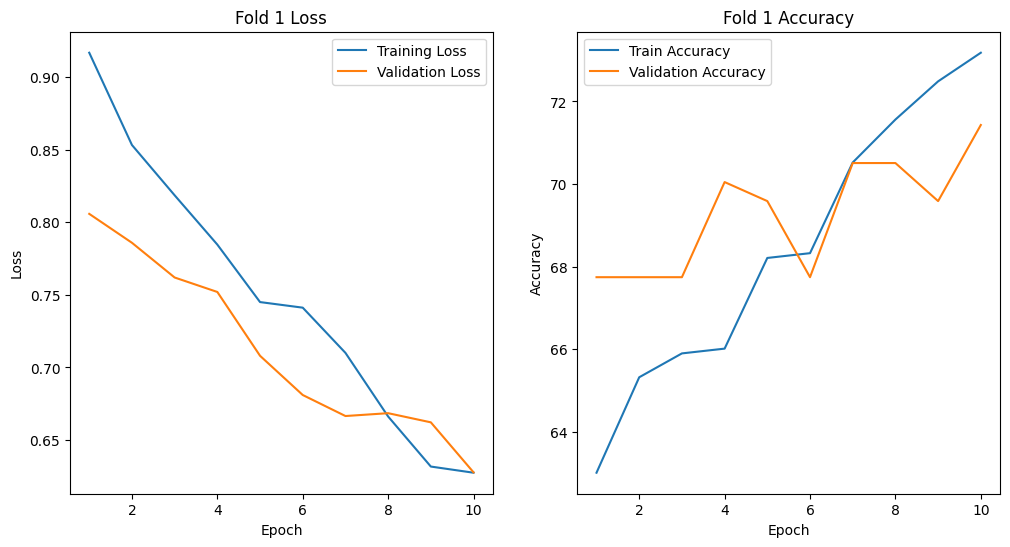

The best Epoch (Epoch 10) of Fold 1:



Classification Report for the Best Epoch (Epoch 10) of Fold 1:

              precision    recall  f1-score   support



    Cataract       0.64      0.21      0.32        42

    Diabetes       0.74      0.94      0.83       147

    Glaucoma       0.50      0.29      0.36        28



    accuracy                           0.71       217

   macro avg       0.63      0.48      0.50       217

weighted avg       0.69      0.71      0.67       217





Fold 2/5

Train indices count: 865, Validation indices count: 217

Epoch 1:

  -- Training dataset. Claasified 558 out of 865 images to correct labels (64.509%). Epoch loss: 0.908

   - Validation dataset. Claasified 154 out of 217 images to correct labels (70.968%). Epoch loss: 0.783

Epoch 2:

  -- Training dataset. Claasified 558 out of 865 images to correct labels (64.509%). Epoch loss: 0.848

   - Validation dataset. Claasified 154 out of 217 images to correct labels (70.968%). Epoch loss: 0.7

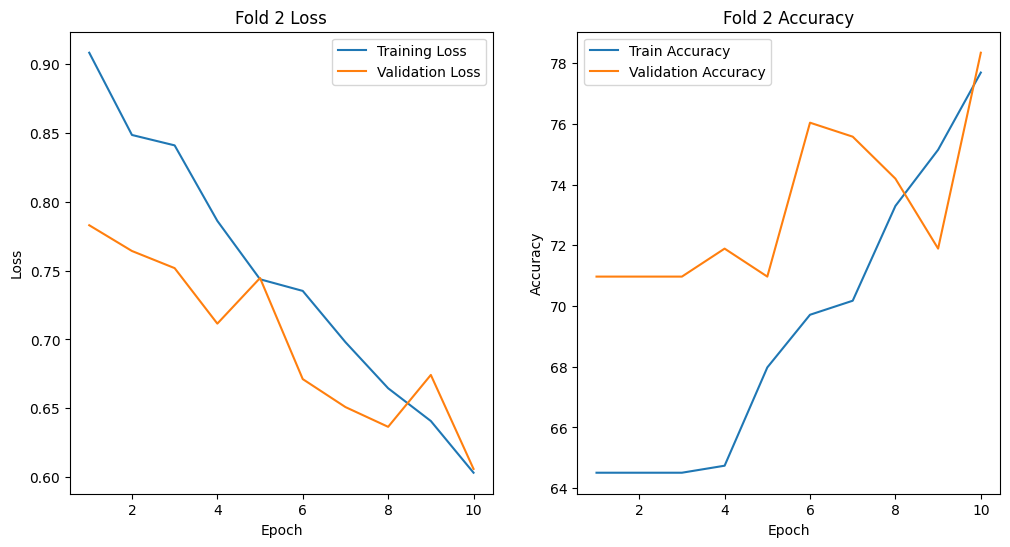

The best Epoch (Epoch 10) of Fold 2:



Classification Report for the Best Epoch (Epoch 10) of Fold 2:

              precision    recall  f1-score   support



    Cataract       0.65      0.49      0.56        35

    Diabetes       0.83      0.93      0.87       154

    Glaucoma       0.56      0.36      0.43        28



    accuracy                           0.78       217

   macro avg       0.68      0.59      0.62       217

weighted avg       0.76      0.78      0.77       217





Fold 3/5

Train indices count: 866, Validation indices count: 216

Epoch 1:

  -- Training dataset. Claasified 564 out of 866 images to correct labels (65.127%). Epoch loss: 0.904

   - Validation dataset. Claasified 132 out of 216 images to correct labels (61.111%). Epoch loss: 0.893

Epoch 2:

  -- Training dataset. Claasified 580 out of 866 images to correct labels (66.975%). Epoch loss: 0.825

   - Validation dataset. Claasified 132 out of 216 images to correct labels (61.111%). Epoch loss: 0.8

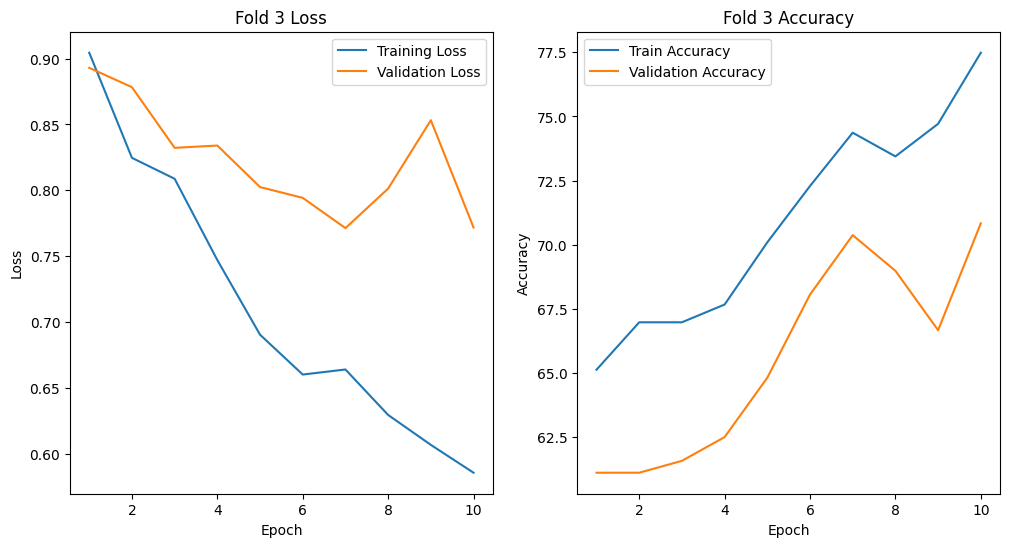

The best Epoch (Epoch 10) of Fold 3:



Classification Report for the Best Epoch (Epoch 10) of Fold 3:

              precision    recall  f1-score   support



    Cataract       0.63      0.63      0.63        51

    Diabetes       0.79      0.83      0.81       132

    Glaucoma       0.42      0.33      0.37        33



    accuracy                           0.71       216

   macro avg       0.61      0.60      0.60       216

weighted avg       0.70      0.71      0.70       216





Fold 4/5

Train indices count: 866, Validation indices count: 216

Epoch 1:

  -- Training dataset. Claasified 548 out of 866 images to correct labels (63.279%). Epoch loss: 0.914

   - Validation dataset. Claasified 132 out of 216 images to correct labels (61.111%). Epoch loss: 0.922

Epoch 2:

  -- Training dataset. Claasified 580 out of 866 images to correct labels (66.975%). Epoch loss: 0.830

   - Validation dataset. Claasified 132 out of 216 images to correct labels (61.111%). Epoch loss: 0.8

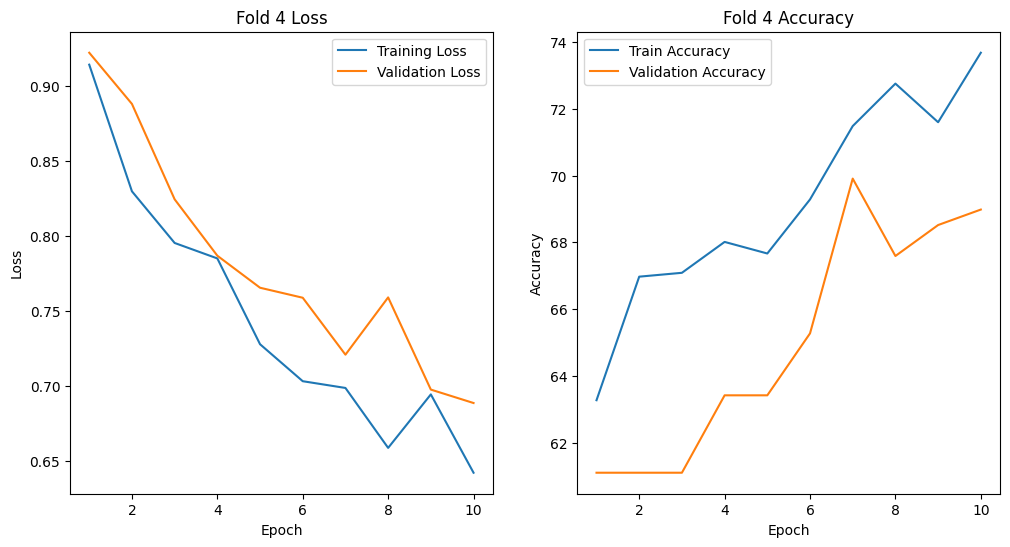

The best Epoch (Epoch 7) of Fold 4:



Classification Report for the Best Epoch (Epoch 7) of Fold 4:

              precision    recall  f1-score   support



    Cataract       0.60      0.46      0.52        46

    Diabetes       0.72      0.94      0.82       132

    Glaucoma       0.67      0.16      0.26        38



    accuracy                           0.70       216

   macro avg       0.66      0.52      0.53       216

weighted avg       0.69      0.70      0.65       216





Fold 5/5

Train indices count: 866, Validation indices count: 216

Epoch 1:

  -- Training dataset. Claasified 551 out of 866 images to correct labels (63.626%). Epoch loss: 0.915

   - Validation dataset. Claasified 147 out of 216 images to correct labels (68.056%). Epoch loss: 0.849

Epoch 2:

  -- Training dataset. Claasified 565 out of 866 images to correct labels (65.242%). Epoch loss: 0.852

   - Validation dataset. Claasified 147 out of 216 images to correct labels (68.056%). Epoch loss: 0.839

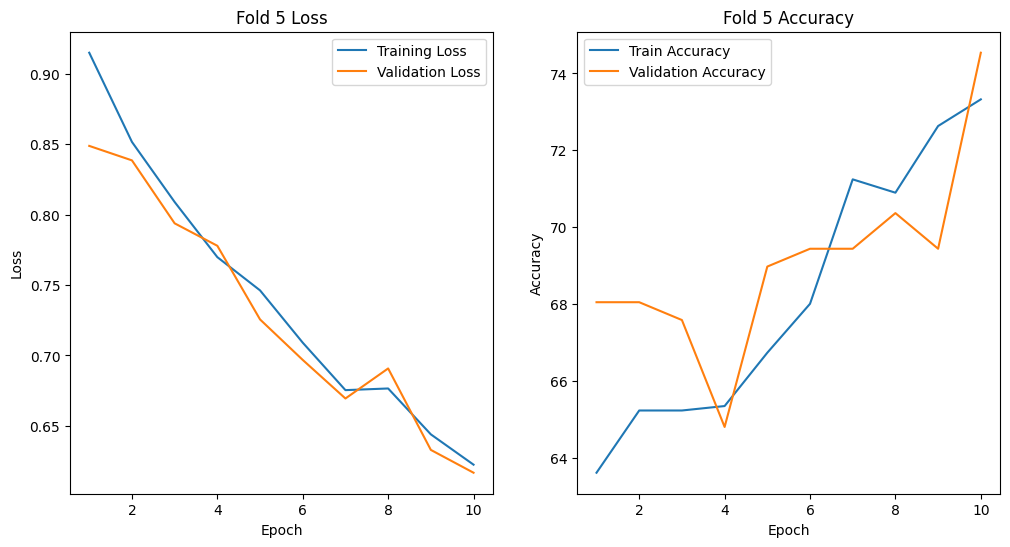

The best Epoch (Epoch 10) of Fold 5:



Classification Report for the Best Epoch (Epoch 10) of Fold 5:

              precision    recall  f1-score   support



    Cataract       0.68      0.47      0.56        36

    Diabetes       0.76      0.95      0.85       147

    Glaucoma       0.57      0.12      0.20        33



    accuracy                           0.75       216

   macro avg       0.67      0.52      0.53       216

weighted avg       0.72      0.75      0.70       216





Best overall model from fold 2 with validation accuracy: 78.34%



Confusion Matrix for the best model (Fold 2):


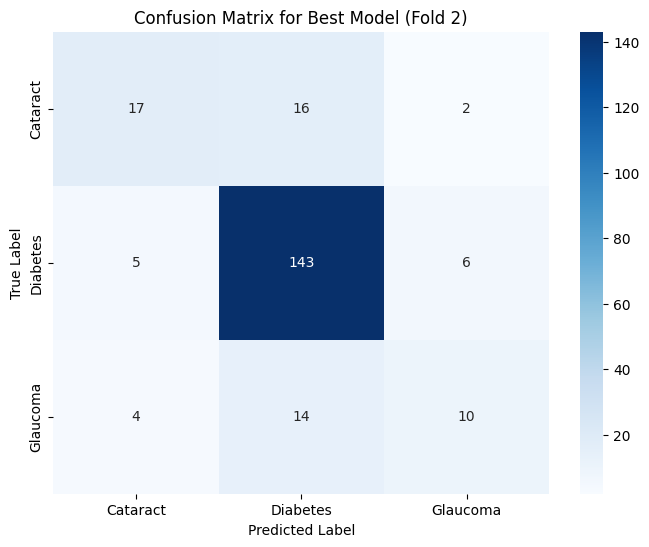



Classification Report for the best model (Fold 2):

              precision    recall  f1-score   support



    Cataract       0.65      0.49      0.56        35

    Diabetes       0.83      0.93      0.87       154

    Glaucoma       0.56      0.36      0.43        28



    accuracy                           0.78       217

   macro avg       0.68      0.59      0.62       217

weighted avg       0.76      0.78      0.77       217



Training and evaluation finished.


In [47]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Initializing the first convolutional layer, taking 3-channel input and outputting 32 channels
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # Initializing the second convolutional layer, taking 32-channel input and outputting 64 channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Initializing the third convolutional layer, taking 64-channel input and outputting 128 channels
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # Initializing the pooling layer, which will downsample the input by a factor of 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Initializing the first fully connected layer, taking the flattened convolutional output and outputting 512 features
        self.fc1 = nn.Linear(128 * 56 * 56, 512)
        # Initializing the second fully connected layer, taking 512 features and outputting the number of class predictions
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Passing input through the first convolutional layer followed by ReLU activation and pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Passing through the second convolutional layer followed by ReLU activation and pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Passing through the third convolutional layer followed by ReLU activation and pooling
        x = self.pool(F.relu(self.conv3(x)))

        # Flattening the output to feed it into the fully connected layer
        x = x.view(x.size(0), -1)

        # Dynamically adjusting the input size of fc1 if the flattened size does not match the expected size
        if self.fc1.in_features != x.size(1):
            # Reinitializing the first fully connected layer with the new input size
            self.fc1 = nn.Linear(x.size(1), 512).to(x.device)

        # Passing through the first fully connected layer followed by ReLU activation
        x = F.relu(self.fc1(x))
        # Passing through the second fully connected layer to produce class scores
        x = self.fc2(x)
        return x

# Define transformations for data preprocessing
transform = transforms.Compose([
#     transforms.Resize((128, 128)), 
    transforms.ToTensor(),
])

# Create the dataset
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the number of epochs and k for k-fold cross-validation
n_epochs = 10
k = 2

# Call the function to train and evaluate the model with k-fold cross-validation
train_and_evaluate_cnn_kfold(dataset=dataset, n_epochs=n_epochs, device=device)

#### Running the model with original dataset was not easy initially, as different images are of different shape of pixel sizes.

#### Every images should be one particular size of pixel dimension when fed into the model, otherwise becuase of the dimension missmatch the code will crash and we will not be able to run the code further.

#### The same thing happened in this case, image dimensions were crashing the code.

#### To handle this situation there is a solution available by which used.
* `x = x.view(x.size(0), -1)`After the convolutional layers have processed the image, the output tensor x has a shape of (batch_size, num_channels, height, width). The .view(x.size(0), -1) operation reshapes this tensor into a 2D tensor where each image is flattened into a single vector. The new shape is (batch_size, num_features), where num_features is the product of the number of channels, height, and width after the last convolutional layer.
* `if self.fc1.in_features != x.size(1):
    self.fc1 = nn.Linear(x.size(1), 512).to(x.device)`:
* This block of code ensures that the input size of the first fully connected layer (fc1) matches the flattened size of the output tensor x.

* self.fc1.in_features represents the expected number of input features for the fully connected layer fc1.
* x.size(1) gives the actual number of input features after flattening, which can vary depending on the input image size.If these two values do not match (i.e., the expected size and the actual size are different), the code reinitializes the fc1 layer with a new input size (x.size(1)) and an output size of 512. The .to(x.device) ensures that the layer is moved to the same device (CPU or GPU) as the rest of the model.

#### Flattening the output of the convolutional layers to get a fixed-size feature vector.Dynamically adjusting the input size of the first fully connected layer to accommodate the varying size of this feature vector.

#### Overall Trends:
* Training Accuracy: Increased steadily across all folds, reaching up to 78.060% in Fold 4/5.
* Training Loss: Decreased consistently, indicating improved model performance.
* Validation Accuracy: Generally improved, with a notable decrease in Fold 4/5.
* Validation Loss: Decreased overall but increased in Fold 4/5, suggesting potential overfitting in that fold.
#### The model shows overall improvement in training and validation performance, though Fold 4/5 had some issues with validation metrics.

## Experiment - 2 Changing the size of images, looking for any changes in accuracy of the models.

## SimpleCNN

In [15]:
def train_and_evaluate_cnn_kfold(dataset: datasets.ImageFolder, n_epochs: int, device: torch.device,
                                 learning_rate: float = 0.001, k: int = 5):
    num_classes = len(dataset.classes)
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    best_model = None
    best_acc = 0
    best_acc_fold = 0
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(dataset)))):
        print(f"\nFold {fold + 1}/{k}")

        # Check the number of images in each subset
        print(f"Train indices count: {len(train_idx)}, Validation indices count: {len(val_idx)}")

        # Ensure the subsets are created correctly
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Double-check that all images are included
        assert len(train_subset) + len(val_subset) == len(dataset), "Subset length mismatch!"

        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=4)
        

        model = SimpleCNN(num_classes=num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        train_acc_history = []
        val_acc_history = []
        epoch_losses = []
        val_losses = []
        best_epoch_labels = []
        best_epoch_preds = []
        
        best_epoch = -1
        best_epoch_acc = 0
        best_epoch_state = None

        for epoch in range(n_epochs):
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_accuracy = 100.0 * correct_train / total_train
            train_acc_history.append(train_accuracy)
            epoch_loss = running_loss / total_train
            epoch_losses.append(epoch_loss)

            model.eval()
            running_val_loss = 0.0
            correct_val = 0
            total_val = 0
            fold_labels = []
            fold_preds = []

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    running_val_loss += loss.item() * images.size(0)
                    _, predicted = torch.max(outputs, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
                    fold_labels.extend(labels.cpu().numpy())
                    fold_preds.extend(predicted.cpu().numpy())

            val_accuracy = 100.0 * correct_val / total_val
            val_acc_history.append(val_accuracy)
            val_loss = running_val_loss / total_val
            val_losses.append(val_loss)

            # Track the best epoch within this fold
            if val_accuracy > best_epoch_acc:
                best_epoch_acc = val_accuracy
                best_epoch = epoch
                best_epoch_state = model.state_dict()
                best_epoch_labels = fold_labels.copy()
                best_epoch_preds = fold_preds.copy()

            print(f"Epoch {epoch + 1}:")
            print(f"  -- Training dataset. Claasified {correct_train} out of {total_train} images to correct labels ({train_accuracy:.3f}%). Epoch loss: {epoch_loss:.3f}")
            print(f"   - Validation dataset. Claasified {correct_val} out of {total_val} images to correct labels ({val_accuracy:.3f}%). Epoch loss: {val_loss:.3f}")

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, n_epochs + 1), epoch_losses, label='Training Loss')
        plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
        plt.title(f'Fold {fold + 1} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(1, n_epochs + 1), train_acc_history, label='Train Accuracy')
        plt.plot(range(1, n_epochs + 1), val_acc_history, label='Validation Accuracy')
        plt.title(f'Fold {fold + 1} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

        cm_best_epoch = confusion_matrix(best_epoch_labels, best_epoch_preds)
        print(f"The best Epoch (Epoch {best_epoch + 1}) of Fold {fold + 1}:")
#         plt.figure(figsize=(8, 6))
#         sns.heatmap(cm_best_epoch, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
#         plt.title(f'Confusion Matrix for Best Epoch (Epoch {best_epoch + 1}) of Fold {fold + 1}')
#         plt.xlabel('Predicted Label')
#         plt.ylabel('True Label')
#         plt.show()

        print(f"\nClassification Report for the Best Epoch (Epoch {best_epoch + 1}) of Fold {fold + 1}:")
        print(classification_report(best_epoch_labels, best_epoch_preds, target_names=dataset.classes))

        fold_results.append({
            'model_state': best_epoch_state,
            'val_accuracy': best_epoch_acc,
            'fold': fold + 1,
            'confusion_matrix': cm_best_epoch,
            'classification_report': classification_report(best_epoch_labels, best_epoch_preds, target_names=dataset.classes)
        })

        if best_epoch_acc > best_acc:
            best_acc = best_epoch_acc
            best_acc_fold = fold + 1
            best_model = best_epoch_state

    if best_model:
        # Save the best model across all folds
        torch.save(best_model, f'best_cnn_model_fold_{best_acc_fold}_accuracy_{best_acc:.2f}.pth')

    # Comparing all best models and printing the best one
    best_overall = max(fold_results, key=lambda x: x['val_accuracy'])
    print(f"\nBest overall model from fold {best_overall['fold']} with validation accuracy: {best_overall['val_accuracy']:.2f}%")
    
    # Print confusion matrix and classification report for the best overall model
    print(f"\nConfusion Matrix for the best model (Fold {best_overall['fold']}):")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_overall['confusion_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title(f'Confusion Matrix for Best Model (Fold {best_overall["fold"]})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print(f"\nClassification Report for the best model (Fold {best_overall['fold']}):")
    print(best_overall['classification_report'])

    # Save the best overall model
    torch.save(best_overall['model_state'], f'best_overall_cnn_model_fold_{best_overall["fold"]}_accuracy_{best_overall["val_accuracy"]:.2f}.pth')

    print("Training and evaluation finished.")


### SimpleCNN Image size reduced to 128 - 

### Updated size here This size here needs to be changes everytime changing the shape of the images, if using withuot rescalled images
#### self.fc1 = nn.Linear(128 * 16 * 16, 512)  

### Updated size here This size here needs to be changes everytime changing the shape of the images, if using withuot rescalled images
#### x = x.view(-1, 128 * 16 * 16)  



Fold 1/5

Train indices count: 865, Validation indices count: 217

Epoch 1:

  -- Training dataset. Claasified 549 out of 865 images to correct labels (63.468%). Epoch loss: 0.924

   - Validation dataset. Claasified 147 out of 217 images to correct labels (67.742%). Epoch loss: 0.812

Epoch 2:

  -- Training dataset. Claasified 565 out of 865 images to correct labels (65.318%). Epoch loss: 0.845

   - Validation dataset. Claasified 147 out of 217 images to correct labels (67.742%). Epoch loss: 0.795

Epoch 3:

  -- Training dataset. Claasified 567 out of 865 images to correct labels (65.549%). Epoch loss: 0.813

   - Validation dataset. Claasified 148 out of 217 images to correct labels (68.203%). Epoch loss: 0.736

Epoch 4:

  -- Training dataset. Claasified 579 out of 865 images to correct labels (66.936%). Epoch loss: 0.746

   - Validation dataset. Claasified 149 out of 217 images to correct labels (68.664%). Epoch loss: 0.706

Epoch 5:

  -- Training dataset. Claasified 601 out

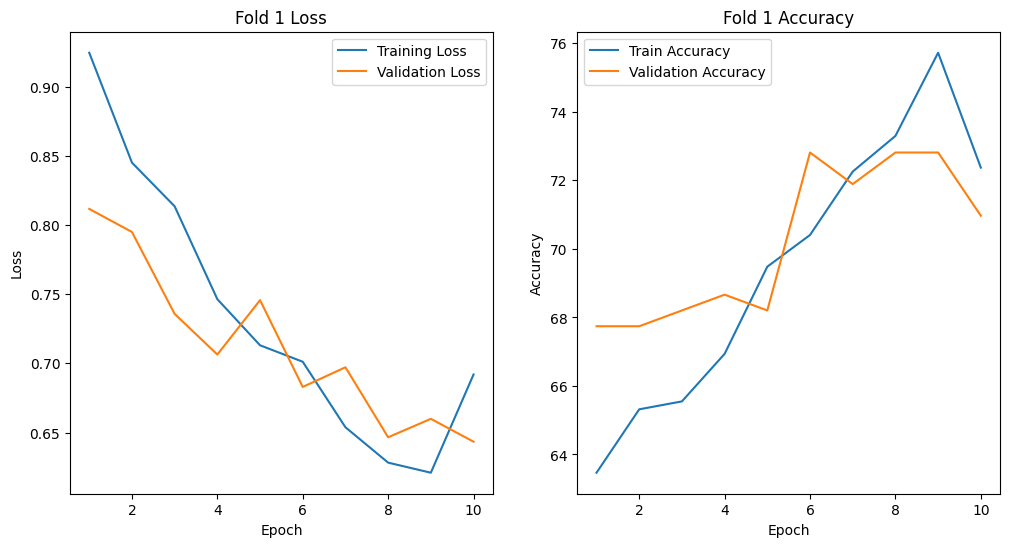

The best Epoch (Epoch 6) of Fold 1:



Classification Report for the Best Epoch (Epoch 6) of Fold 1:

              precision    recall  f1-score   support



    Cataract       0.67      0.29      0.40        42

    Diabetes       0.78      0.93      0.84       147

    Glaucoma       0.42      0.36      0.38        28



    accuracy                           0.73       217

   macro avg       0.62      0.52      0.54       217

weighted avg       0.71      0.73      0.70       217





Fold 2/5

Train indices count: 865, Validation indices count: 217

Epoch 1:

  -- Training dataset. Claasified 544 out of 865 images to correct labels (62.890%). Epoch loss: 0.909

   - Validation dataset. Claasified 154 out of 217 images to correct labels (70.968%). Epoch loss: 0.792

Epoch 2:

  -- Training dataset. Claasified 558 out of 865 images to correct labels (64.509%). Epoch loss: 0.857

   - Validation dataset. Claasified 154 out of 217 images to correct labels (70.968%). Epoch loss: 0.810

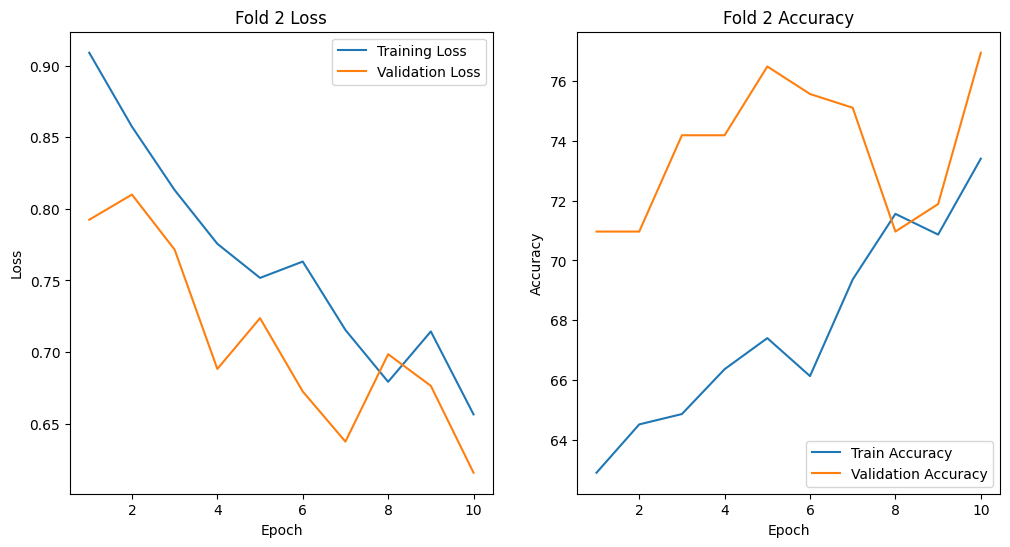

The best Epoch (Epoch 10) of Fold 2:



Classification Report for the Best Epoch (Epoch 10) of Fold 2:

              precision    recall  f1-score   support



    Cataract       0.69      0.26      0.37        35

    Diabetes       0.79      0.97      0.87       154

    Glaucoma       0.60      0.32      0.42        28



    accuracy                           0.77       217

   macro avg       0.69      0.52      0.55       217

weighted avg       0.75      0.77      0.73       217





Fold 3/5

Train indices count: 866, Validation indices count: 216

Epoch 1:

  -- Training dataset. Claasified 546 out of 866 images to correct labels (63.048%). Epoch loss: 0.922

   - Validation dataset. Claasified 132 out of 216 images to correct labels (61.111%). Epoch loss: 0.907

Epoch 2:

  -- Training dataset. Claasified 580 out of 866 images to correct labels (66.975%). Epoch loss: 0.842

   - Validation dataset. Claasified 132 out of 216 images to correct labels (61.111%). Epoch loss: 0.8

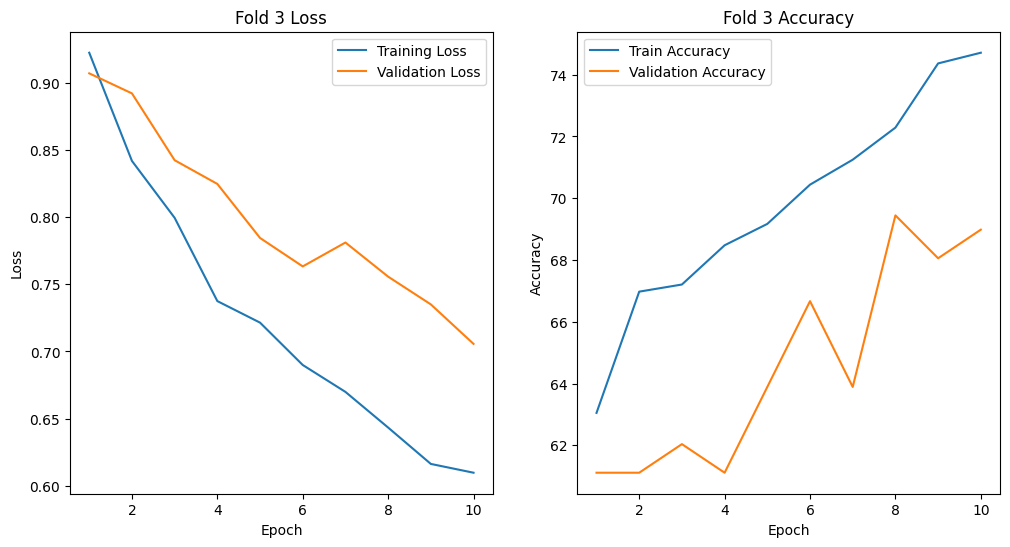

The best Epoch (Epoch 8) of Fold 3:



Classification Report for the Best Epoch (Epoch 8) of Fold 3:

              precision    recall  f1-score   support



    Cataract       0.55      0.53      0.54        51

    Diabetes       0.75      0.87      0.81       132

    Glaucoma       0.57      0.24      0.34        33



    accuracy                           0.69       216

   macro avg       0.62      0.55      0.56       216

weighted avg       0.68      0.69      0.67       216





Fold 4/5

Train indices count: 866, Validation indices count: 216

Epoch 1:

  -- Training dataset. Claasified 555 out of 866 images to correct labels (64.088%). Epoch loss: 0.927

   - Validation dataset. Claasified 132 out of 216 images to correct labels (61.111%). Epoch loss: 0.897

Epoch 2:

  -- Training dataset. Claasified 580 out of 866 images to correct labels (66.975%). Epoch loss: 0.824

   - Validation dataset. Claasified 132 out of 216 images to correct labels (61.111%). Epoch loss: 0.864

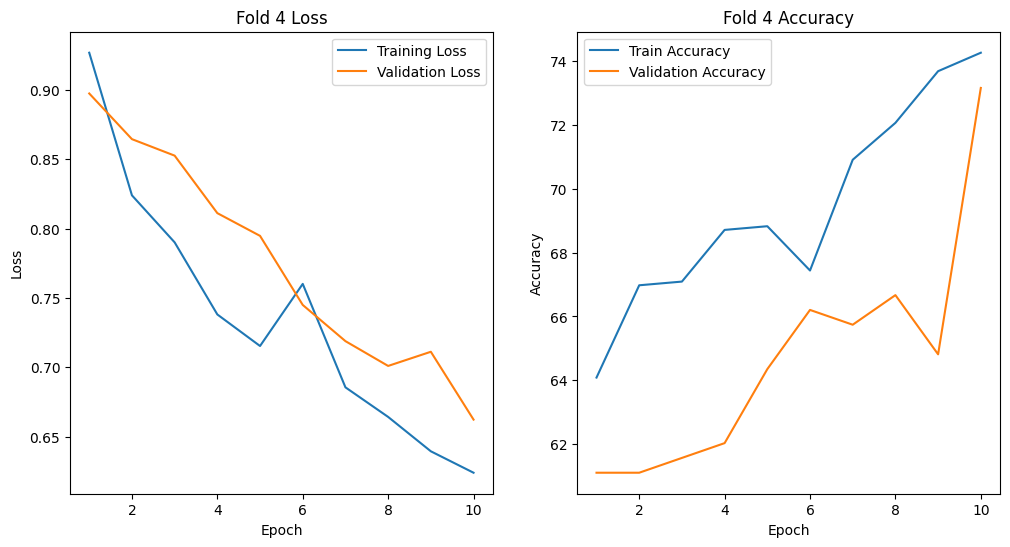

The best Epoch (Epoch 10) of Fold 4:



Classification Report for the Best Epoch (Epoch 10) of Fold 4:

              precision    recall  f1-score   support



    Cataract       0.70      0.46      0.55        46

    Diabetes       0.75      0.94      0.84       132

    Glaucoma       0.62      0.34      0.44        38



    accuracy                           0.73       216

   macro avg       0.69      0.58      0.61       216

weighted avg       0.72      0.73      0.71       216





Fold 5/5

Train indices count: 866, Validation indices count: 216

Epoch 1:

  -- Training dataset. Claasified 553 out of 866 images to correct labels (63.857%). Epoch loss: 0.912

   - Validation dataset. Claasified 147 out of 216 images to correct labels (68.056%). Epoch loss: 0.851

Epoch 2:

  -- Training dataset. Claasified 565 out of 866 images to correct labels (65.242%). Epoch loss: 0.847

   - Validation dataset. Claasified 147 out of 216 images to correct labels (68.056%). Epoch loss: 0.8

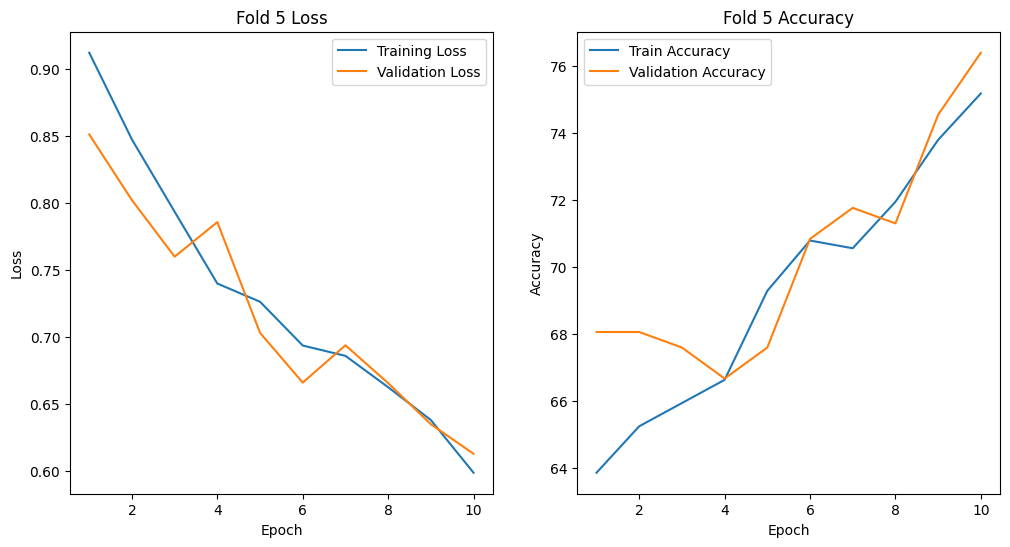

The best Epoch (Epoch 10) of Fold 5:



Classification Report for the Best Epoch (Epoch 10) of Fold 5:

              precision    recall  f1-score   support



    Cataract       0.80      0.44      0.57        36

    Diabetes       0.78      0.95      0.86       147

    Glaucoma       0.56      0.27      0.37        33



    accuracy                           0.76       216

   macro avg       0.71      0.56      0.60       216

weighted avg       0.75      0.76      0.73       216





Best overall model from fold 2 with validation accuracy: 76.96%



Confusion Matrix for the best model (Fold 2):


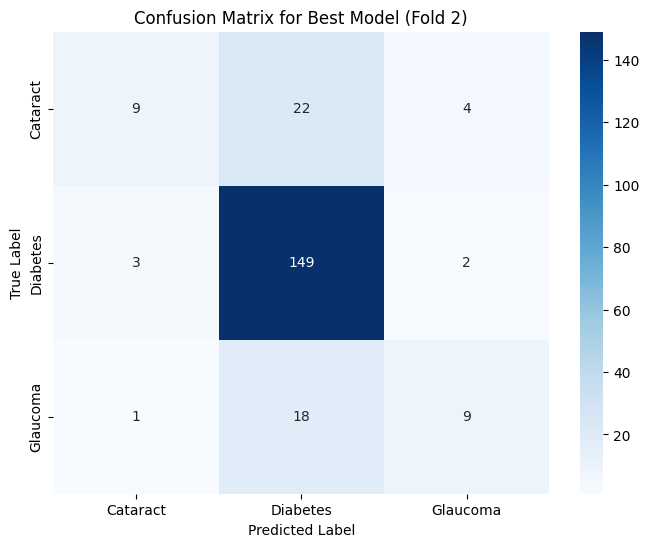



Classification Report for the best model (Fold 2):

              precision    recall  f1-score   support



    Cataract       0.69      0.26      0.37        35

    Diabetes       0.79      0.97      0.87       154

    Glaucoma       0.60      0.32      0.42        28



    accuracy                           0.77       217

   macro avg       0.69      0.52      0.55       217

weighted avg       0.75      0.77      0.73       217



Training and evaluation finished.


In [49]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Initializing the first convolutional layer, taking 3-channel input and outputting 32 channels
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # Initializing the second convolutional layer, taking 32-channel input and outputting 64 channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Initializing the third convolutional layer, taking 64-channel input and outputting 128 channels
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # Initializing the pooling layer, which will downsample the input by a factor of 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Initializing the first fully connected layer, taking the flattened convolutional output and outputting 512 features
        self.fc1 = nn.Linear(128 * 56 * 56, 512)
        # Initializing the second fully connected layer, taking 512 features and outputting the number of class predictions
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Passing input through the first convolutional layer followed by ReLU activation and pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Passing through the second convolutional layer followed by ReLU activation and pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Passing through the third convolutional layer followed by ReLU activation and pooling
        x = self.pool(F.relu(self.conv3(x)))

        # Flattening the output to feed it into the fully connected layer
        x = x.view(x.size(0), -1)

        # Dynamically adjusting the input size of fc1 if the flattened size does not match the expected size
        if self.fc1.in_features != x.size(1):
            # Reinitializing the first fully connected layer with the new input size
            self.fc1 = nn.Linear(x.size(1), 512).to(x.device)

        # Passing through the first fully connected layer followed by ReLU activation
        x = F.relu(self.fc1(x))
        # Passing through the second fully connected layer to produce class scores
        x = self.fc2(x)
        return x

# Define transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
])

# Create the dataset
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the number of epochs and k for k-fold cross-validation
n_epochs = 10
k = 2

# Call the function to train and evaluate the model with k-fold cross-validation
train_and_evaluate_cnn_kfold(dataset=dataset, n_epochs=n_epochs, device=device)

# simpleCNN Image size reduced to 224


Fold 1/5
Train indices count: 865, Validation indices count: 217
Epoch 1:
  -- Training dataset. Claasified 506 out of 865 images to correct labels (58.497%). Epoch loss: 1.034
   - Validation dataset. Claasified 147 out of 217 images to correct labels (67.742%). Epoch loss: 0.795
Epoch 2:
  -- Training dataset. Claasified 579 out of 865 images to correct labels (66.936%). Epoch loss: 0.787
   - Validation dataset. Claasified 152 out of 217 images to correct labels (70.046%). Epoch loss: 0.713
Epoch 3:
  -- Training dataset. Claasified 597 out of 865 images to correct labels (69.017%). Epoch loss: 0.735
   - Validation dataset. Claasified 152 out of 217 images to correct labels (70.046%). Epoch loss: 0.678
Epoch 4:
  -- Training dataset. Claasified 628 out of 865 images to correct labels (72.601%). Epoch loss: 0.696
   - Validation dataset. Claasified 156 out of 217 images to correct labels (71.889%). Epoch loss: 0.669
Epoch 5:
  -- Training dataset. Claasified 632 out of 865 images t

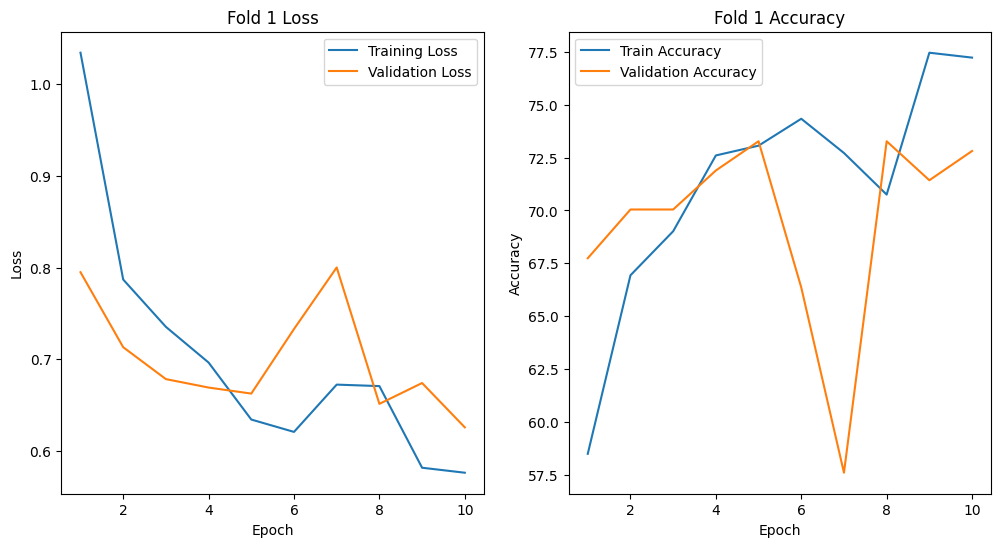

The best Epoch (Epoch 5) of Fold 1:

Classification Report for the Best Epoch (Epoch 5) of Fold 1:
              precision    recall  f1-score   support

    Cataract       0.51      0.83      0.63        42
    Diabetes       0.85      0.82      0.83       147
    Glaucoma       0.67      0.14      0.24        28

    accuracy                           0.73       217
   macro avg       0.67      0.60      0.57       217
weighted avg       0.76      0.73      0.71       217


Fold 2/5
Train indices count: 865, Validation indices count: 217
Epoch 1:
  -- Training dataset. Claasified 511 out of 865 images to correct labels (59.075%). Epoch loss: 1.075
   - Validation dataset. Claasified 156 out of 217 images to correct labels (71.889%). Epoch loss: 0.750
Epoch 2:
  -- Training dataset. Claasified 554 out of 865 images to correct labels (64.046%). Epoch loss: 0.824
   - Validation dataset. Claasified 156 out of 217 images to correct labels (71.889%). Epoch loss: 0.700
Epoch 3:
  -- Traini

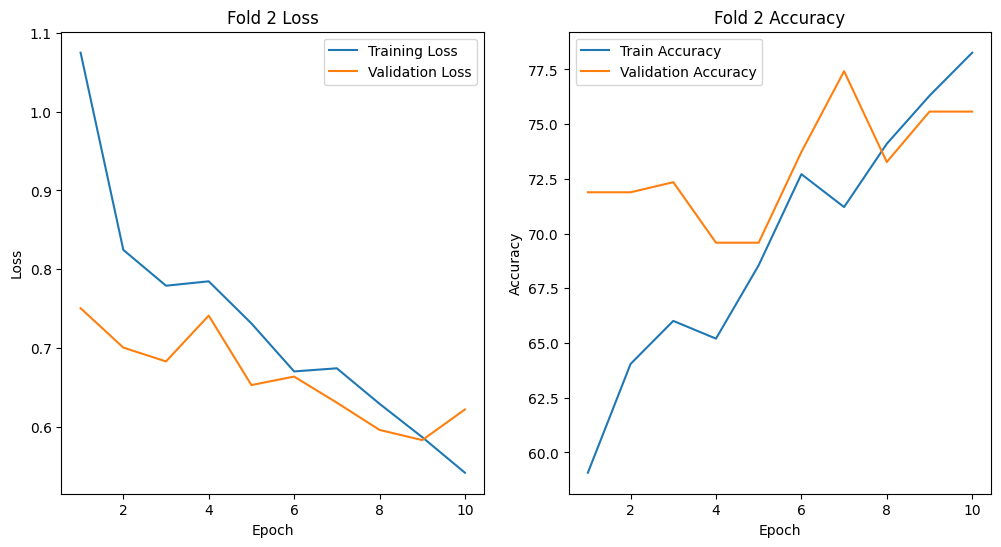

The best Epoch (Epoch 7) of Fold 2:

Classification Report for the Best Epoch (Epoch 7) of Fold 2:
              precision    recall  f1-score   support

    Cataract       0.59      0.66      0.62        35
    Diabetes       0.82      0.92      0.87       154
    Glaucoma       0.57      0.14      0.23        28

    accuracy                           0.77       217
   macro avg       0.66      0.57      0.57       217
weighted avg       0.75      0.77      0.75       217


Fold 3/5
Train indices count: 866, Validation indices count: 216
Epoch 1:
  -- Training dataset. Claasified 570 out of 866 images to correct labels (65.820%). Epoch loss: 0.943
   - Validation dataset. Claasified 134 out of 216 images to correct labels (62.037%). Epoch loss: 0.846
Epoch 2:
  -- Training dataset. Claasified 600 out of 866 images to correct labels (69.284%). Epoch loss: 0.747
   - Validation dataset. Claasified 143 out of 216 images to correct labels (66.204%). Epoch loss: 0.840
Epoch 3:
  -- Traini

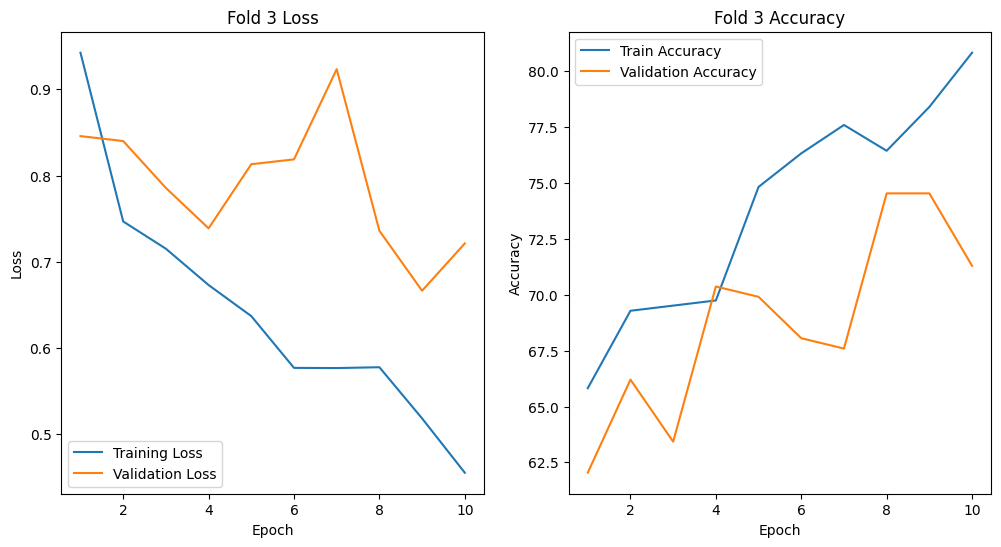

The best Epoch (Epoch 8) of Fold 3:

Classification Report for the Best Epoch (Epoch 8) of Fold 3:
              precision    recall  f1-score   support

    Cataract       0.77      0.53      0.63        51
    Diabetes       0.77      0.92      0.84       132
    Glaucoma       0.54      0.39      0.46        33

    accuracy                           0.75       216
   macro avg       0.69      0.61      0.64       216
weighted avg       0.74      0.75      0.73       216


Fold 4/5
Train indices count: 866, Validation indices count: 216
Epoch 1:
  -- Training dataset. Claasified 582 out of 866 images to correct labels (67.206%). Epoch loss: 1.060
   - Validation dataset. Claasified 135 out of 216 images to correct labels (62.500%). Epoch loss: 0.908
Epoch 2:
  -- Training dataset. Claasified 605 out of 866 images to correct labels (69.861%). Epoch loss: 0.771
   - Validation dataset. Claasified 143 out of 216 images to correct labels (66.204%). Epoch loss: 0.818
Epoch 3:
  -- Traini

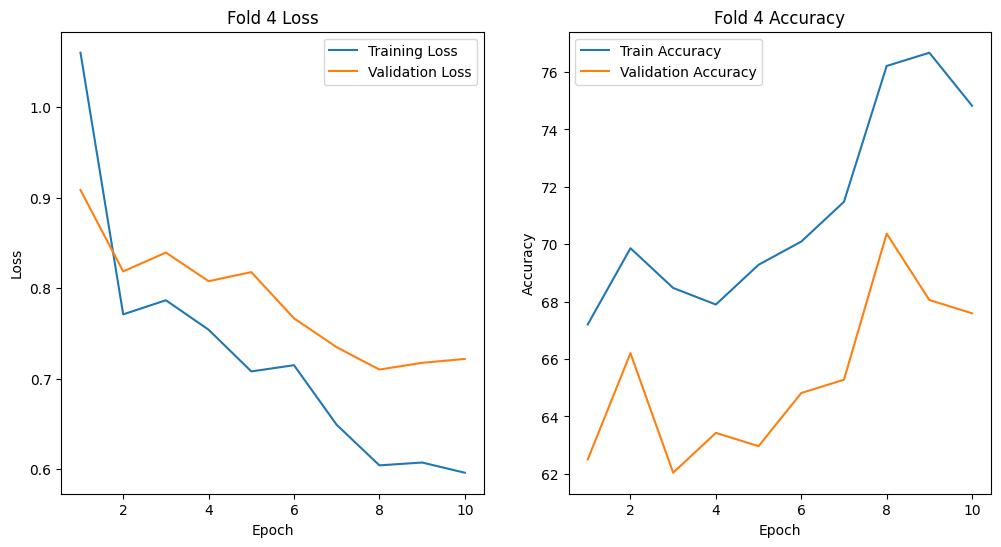

The best Epoch (Epoch 8) of Fold 4:

Classification Report for the Best Epoch (Epoch 8) of Fold 4:
              precision    recall  f1-score   support

    Cataract       0.62      0.67      0.65        46
    Diabetes       0.76      0.86      0.81       132
    Glaucoma       0.44      0.21      0.29        38

    accuracy                           0.70       216
   macro avg       0.61      0.58      0.58       216
weighted avg       0.68      0.70      0.68       216


Fold 5/5
Train indices count: 866, Validation indices count: 216
Epoch 1:
  -- Training dataset. Claasified 515 out of 866 images to correct labels (59.469%). Epoch loss: 0.976
   - Validation dataset. Claasified 150 out of 216 images to correct labels (69.444%). Epoch loss: 0.752
Epoch 2:
  -- Training dataset. Claasified 589 out of 866 images to correct labels (68.014%). Epoch loss: 0.808
   - Validation dataset. Claasified 152 out of 216 images to correct labels (70.370%). Epoch loss: 0.772
Epoch 3:
  -- Traini

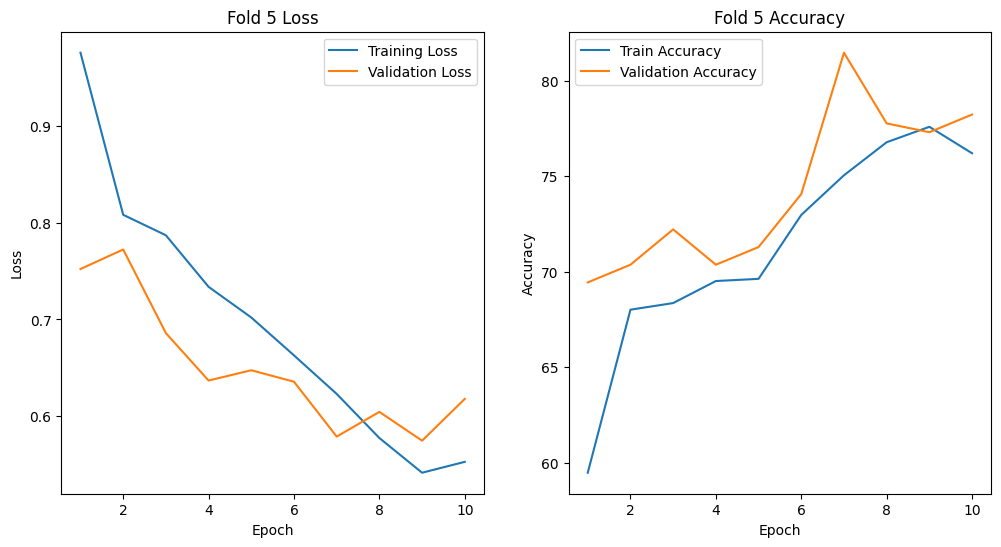

The best Epoch (Epoch 7) of Fold 5:

Classification Report for the Best Epoch (Epoch 7) of Fold 5:
              precision    recall  f1-score   support

    Cataract       0.67      0.72      0.69        36
    Diabetes       0.84      0.93      0.88       147
    Glaucoma       0.88      0.42      0.57        33

    accuracy                           0.81       216
   macro avg       0.80      0.69      0.72       216
weighted avg       0.82      0.81      0.80       216


Best overall model from fold 5 with validation accuracy: 81.48%

Confusion Matrix for the best model (Fold 5):


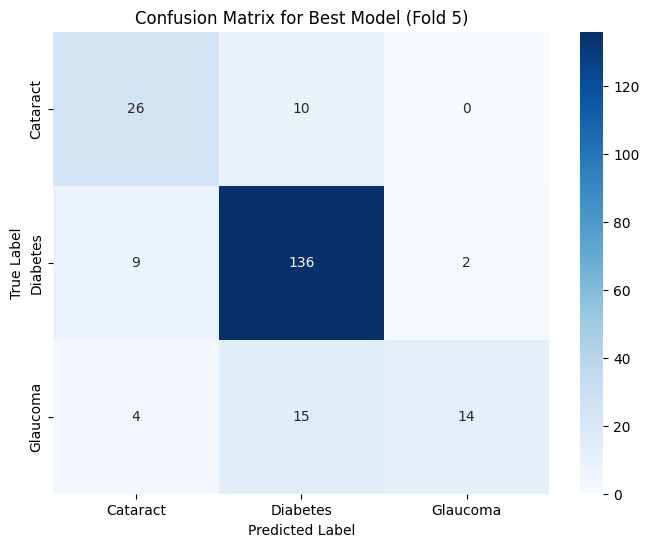


Classification Report for the best model (Fold 5):
              precision    recall  f1-score   support

    Cataract       0.67      0.72      0.69        36
    Diabetes       0.84      0.93      0.88       147
    Glaucoma       0.88      0.42      0.57        33

    accuracy                           0.81       216
   macro avg       0.80      0.69      0.72       216
weighted avg       0.82      0.81      0.80       216

Training and evaluation finished.


In [16]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Updated size here
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 28 * 28)  # Updated size here
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
])

# Create the dataset
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the number of epochs and k for k-fold cross-validation
n_epochs = 10
k = 2

# Call the function to train and evaluate the model with k-fold cross-validation
train_and_evaluate_cnn_kfold(dataset=dataset, n_epochs=n_epochs, device=device)

## simpleCNN image shape 448


Fold 1/5
Train indices count: 865, Validation indices count: 217
Epoch 1:
  -- Training dataset. Claasified 555 out of 865 images to correct labels (64.162%). Epoch loss: 1.229
   - Validation dataset. Claasified 146 out of 217 images to correct labels (67.281%). Epoch loss: 0.825
Epoch 2:
  -- Training dataset. Claasified 576 out of 865 images to correct labels (66.590%). Epoch loss: 0.753
   - Validation dataset. Claasified 150 out of 217 images to correct labels (69.124%). Epoch loss: 0.733
Epoch 3:
  -- Training dataset. Claasified 591 out of 865 images to correct labels (68.324%). Epoch loss: 0.713
   - Validation dataset. Claasified 147 out of 217 images to correct labels (67.742%). Epoch loss: 1.312
Epoch 4:
  -- Training dataset. Claasified 581 out of 865 images to correct labels (67.168%). Epoch loss: 0.788
   - Validation dataset. Claasified 148 out of 217 images to correct labels (68.203%). Epoch loss: 0.773
Epoch 5:
  -- Training dataset. Claasified 582 out of 865 images t

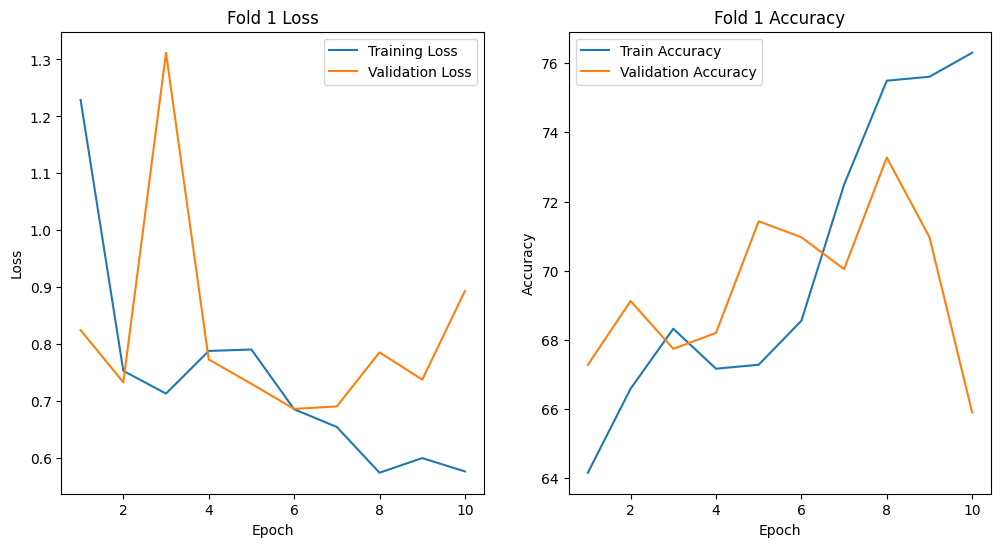

The best Epoch (Epoch 8) of Fold 1:

Classification Report for the Best Epoch (Epoch 8) of Fold 1:
              precision    recall  f1-score   support

    Cataract       0.59      0.48      0.53        42
    Diabetes       0.77      0.93      0.84       147
    Glaucoma       0.50      0.11      0.18        28

    accuracy                           0.73       217
   macro avg       0.62      0.50      0.51       217
weighted avg       0.70      0.73      0.69       217


Fold 2/5
Train indices count: 865, Validation indices count: 217
Epoch 1:
  -- Training dataset. Claasified 522 out of 865 images to correct labels (60.347%). Epoch loss: 1.294
   - Validation dataset. Claasified 155 out of 217 images to correct labels (71.429%). Epoch loss: 0.763
Epoch 2:
  -- Training dataset. Claasified 588 out of 865 images to correct labels (67.977%). Epoch loss: 0.812
   - Validation dataset. Claasified 158 out of 217 images to correct labels (72.811%). Epoch loss: 0.740
Epoch 3:
  -- Traini

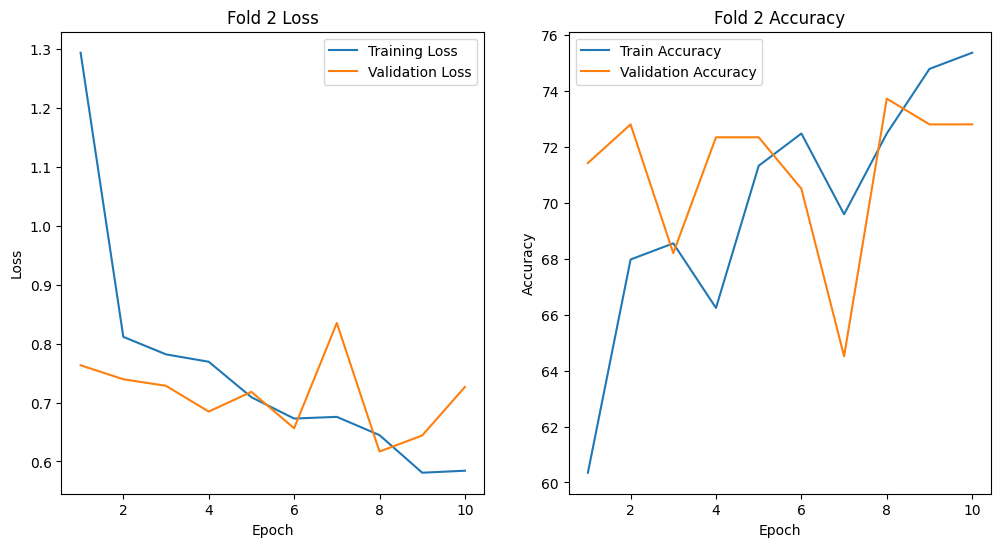

The best Epoch (Epoch 8) of Fold 2:

Classification Report for the Best Epoch (Epoch 8) of Fold 2:
              precision    recall  f1-score   support

    Cataract       0.47      0.46      0.46        35
    Diabetes       0.82      0.89      0.85       154
    Glaucoma       0.44      0.25      0.32        28

    accuracy                           0.74       217
   macro avg       0.58      0.53      0.55       217
weighted avg       0.71      0.74      0.72       217


Fold 3/5
Train indices count: 866, Validation indices count: 216
Epoch 1:
  -- Training dataset. Claasified 526 out of 866 images to correct labels (60.739%). Epoch loss: 1.745
   - Validation dataset. Claasified 134 out of 216 images to correct labels (62.037%). Epoch loss: 0.902
Epoch 2:
  -- Training dataset. Claasified 595 out of 866 images to correct labels (68.707%). Epoch loss: 0.786
   - Validation dataset. Claasified 144 out of 216 images to correct labels (66.667%). Epoch loss: 0.820
Epoch 3:
  -- Traini

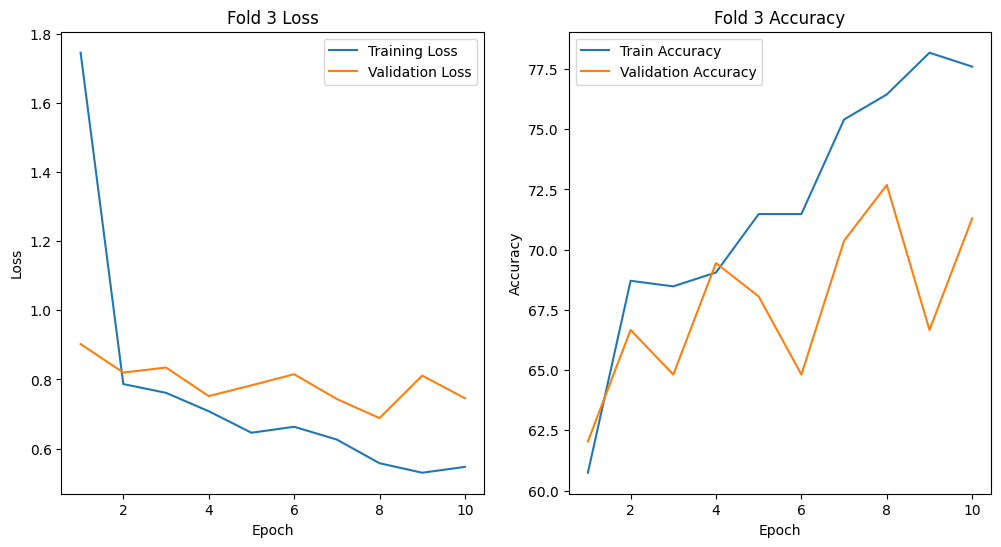

The best Epoch (Epoch 8) of Fold 3:

Classification Report for the Best Epoch (Epoch 8) of Fold 3:
              precision    recall  f1-score   support

    Cataract       0.69      0.49      0.57        51
    Diabetes       0.78      0.87      0.82       132
    Glaucoma       0.52      0.52      0.52        33

    accuracy                           0.73       216
   macro avg       0.66      0.63      0.64       216
weighted avg       0.72      0.73      0.72       216


Fold 4/5
Train indices count: 866, Validation indices count: 216
Epoch 1:
  -- Training dataset. Claasified 539 out of 866 images to correct labels (62.240%). Epoch loss: 1.446
   - Validation dataset. Claasified 135 out of 216 images to correct labels (62.500%). Epoch loss: 0.888
Epoch 2:
  -- Training dataset. Claasified 601 out of 866 images to correct labels (69.400%). Epoch loss: 0.767
   - Validation dataset. Claasified 134 out of 216 images to correct labels (62.037%). Epoch loss: 1.175
Epoch 3:
  -- Traini

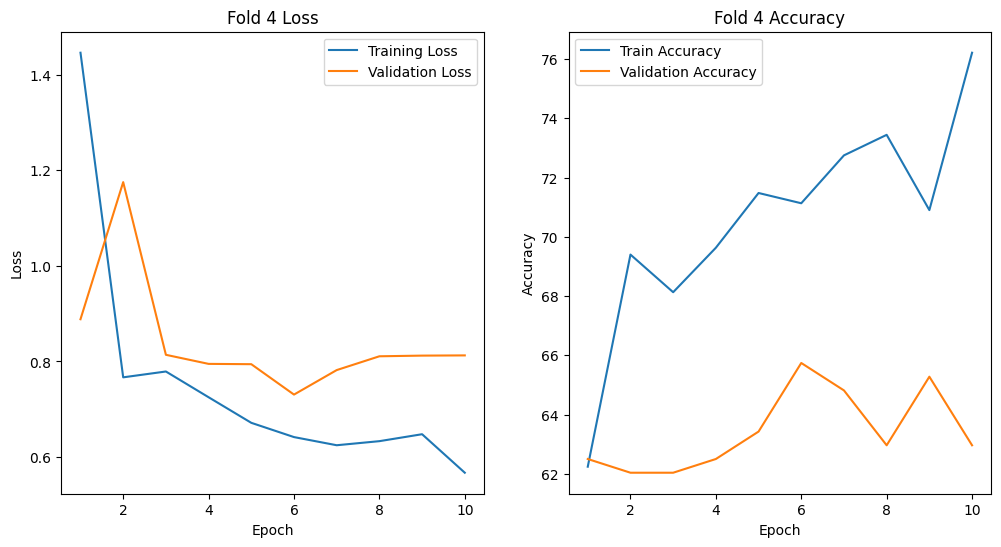

The best Epoch (Epoch 6) of Fold 4:

Classification Report for the Best Epoch (Epoch 6) of Fold 4:
              precision    recall  f1-score   support

    Cataract       0.65      0.28      0.39        46
    Diabetes       0.67      0.95      0.79       132
    Glaucoma       0.40      0.11      0.17        38

    accuracy                           0.66       216
   macro avg       0.57      0.44      0.45       216
weighted avg       0.62      0.66      0.59       216


Fold 5/5
Train indices count: 866, Validation indices count: 216
Epoch 1:
  -- Training dataset. Claasified 556 out of 866 images to correct labels (64.203%). Epoch loss: 1.574
   - Validation dataset. Claasified 145 out of 216 images to correct labels (67.130%). Epoch loss: 0.927
Epoch 2:
  -- Training dataset. Claasified 545 out of 866 images to correct labels (62.933%). Epoch loss: 0.913
   - Validation dataset. Claasified 148 out of 216 images to correct labels (68.519%). Epoch loss: 0.734
Epoch 3:
  -- Traini

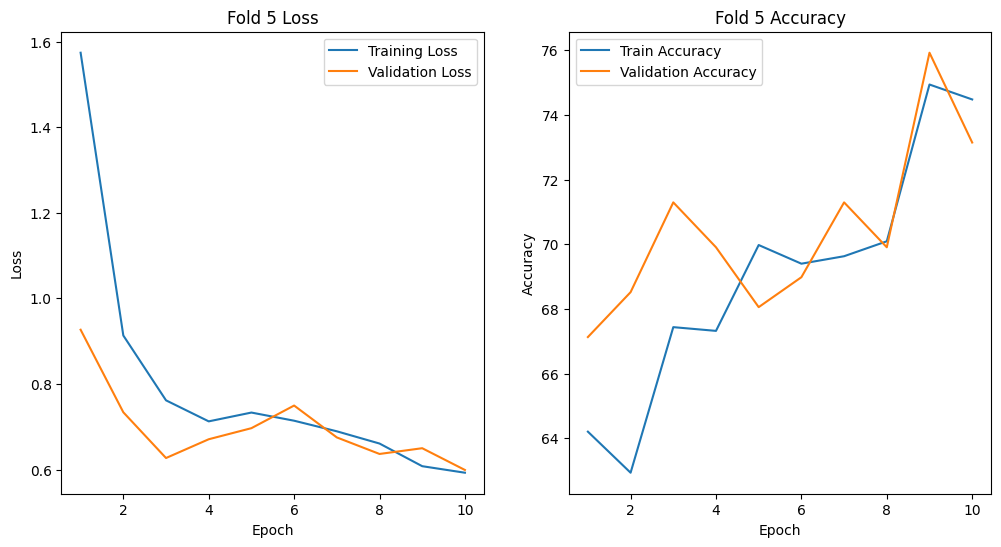

The best Epoch (Epoch 9) of Fold 5:

Classification Report for the Best Epoch (Epoch 9) of Fold 5:
              precision    recall  f1-score   support

    Cataract       0.61      0.61      0.61        36
    Diabetes       0.79      0.93      0.85       147
    Glaucoma       0.83      0.15      0.26        33

    accuracy                           0.76       216
   macro avg       0.74      0.56      0.57       216
weighted avg       0.77      0.76      0.72       216


Best overall model from fold 5 with validation accuracy: 75.93%

Confusion Matrix for the best model (Fold 5):


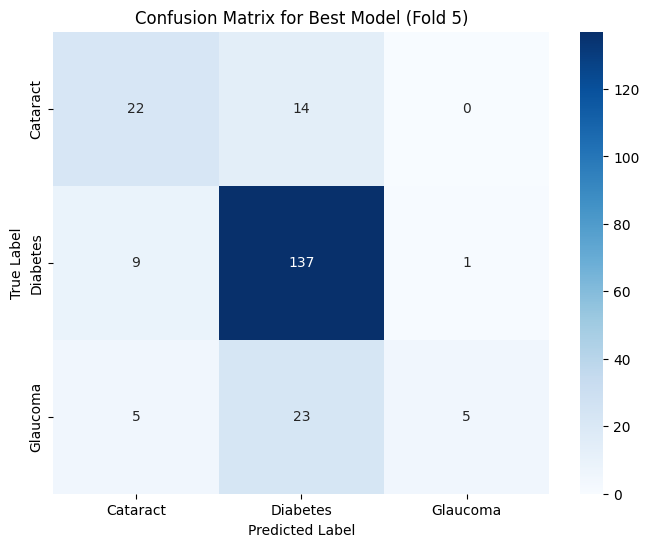


Classification Report for the best model (Fold 5):
              precision    recall  f1-score   support

    Cataract       0.61      0.61      0.61        36
    Diabetes       0.79      0.93      0.85       147
    Glaucoma       0.83      0.15      0.26        33

    accuracy                           0.76       216
   macro avg       0.74      0.56      0.57       216
weighted avg       0.77      0.76      0.72       216

Training and evaluation finished.


In [17]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Update size to 128 * 56 * 56
        self.fc1 = nn.Linear(128 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Define transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor()
])

# Create the dataset
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the number of epochs and k for k-fold cross-validation
n_epochs = 10
k = 5

# Call the function to train and evaluate the model with k-fold cross-validation
train_and_evaluate_cnn_kfold(dataset=dataset, n_epochs=n_epochs, device=device)

## simpleCNN - parameter tuned

#### Feature Extraction (self.features):
* nn.Sequential: Combines several layers into a single module for easier construction and management.

#### Convolutional Layers:
* nn.Conv2d(3, 32, kernel_size=3, padding=1): Applies 32 convolutional filters of size 3x3 to the input with padding to maintain 

#### spatial dimensions.
* nn.Conv2d(32, 64, kernel_size=3, padding=1): Applies 64 convolutional filters of size 3x3.
* nn.Conv2d(64, 128, kernel_size=3, padding=1): Applies 128 convolutional filters of size 3x3.

#### Activation Function:
* nn.ReLU(): Adds non-linearity to the model after each convolutional layer.

#### Pooling Layers:
* nn.MaxPool2d(kernel_size=2, stride=2): Reduces spatial dimensions by taking the maximum value in a 2x2 window, effectively downsampling the feature maps.

#### Dropout Layers:
* nn.Dropout(dropout_rate): Randomly drops neurons during training to prevent overfitting. The dropout rate is a hyperparameter (dropout_rate) that specifies the probability of dropping a neuron.

#### Classifier (self.classifier):
* #### Fully Connected Layers:
* * nn.Linear(128 * 16 * 16, 256): A dense layer that maps the flattened output of the convolutional layers to 256 features. The input size here (128 * 16 * 16) assumes the feature maps have been reduced to 16x16 spatial dimensions after pooling. This size must match the output size of the self.features layer after flattening.
* * nn.ReLU(): Adds non-linearity.
* * nn.Dropout(dropout_rate): Applied after the first fully connected layer to reduce overfitting.
* * nn.Linear(256, num_classes): The final fully connected layer that maps the 256 features to num_classes output classes for 

#### classification.
* #### Forward Pass (forward Method):
* * #### Feature Extraction:
* * * x = self.features(x): Passes the input through the convolutional layers and pooling layers.

#### Flattening:
* x = x.view(x.size(0), -1): Flattens the output of the convolutional layers to prepare it for the fully connected layers.
#### Classification:
* x = self.classifier(x): Passes the flattened tensor through the fully connected layers to get class scores.
#### Parameters Tuned:
* dropout_rate: The dropout rate used in the dropout layers to control regularization. It is a hyperparameter that helps prevent overfitting by randomly dropping neurons during training.

#### Purpose of use 
*  Feature Extraction: Extracts hierarchical features from the input image using convolutional and pooling layers.
*  Classification: Maps the extracted features to class scores using fully connected layers.
*  Regularization: Uses dropout to reduce overfitting and improve generalization.



In [59]:
def train_and_evaluate_cnnParams_kfold(dataset: datasets.ImageFolder, n_epochs: int, device: torch.device,
                                       learning_rate: float = 0.001, dropout_rate: float = 0.5, k: int = 5):
    num_classes = len(dataset.classes)
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    best_model = None
    best_acc = 0
    best_acc_fold = 0
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(dataset)))):
        print(f"\nFold {fold + 1}/{k}")

        print(f"Train indices count: {len(train_idx)}, Validation indices count: {len(val_idx)}")

        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=4)

        model = SimpleCNN(num_classes=num_classes, dropout_rate=dropout_rate).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        train_acc_history = []
        val_acc_history = []
        epoch_losses = []
        val_losses = []
        best_epoch_labels = []
        best_epoch_preds = []

        best_epoch = -1
        best_epoch_acc = 0
        best_epoch_state = None

        for epoch in range(n_epochs):
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_accuracy = 100.0 * correct_train / total_train
            train_acc_history.append(train_accuracy)
            epoch_loss = running_loss / total_train
            epoch_losses.append(epoch_loss)

            model.eval()
            running_val_loss = 0.0
            correct_val = 0
            total_val = 0
            fold_labels = []
            fold_preds = []

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    running_val_loss += loss.item() * images.size(0)
                    _, predicted = torch.max(outputs, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
                    fold_labels.extend(labels.cpu().numpy())
                    fold_preds.extend(predicted.cpu().numpy())

            val_accuracy = 100.0 * correct_val / total_val
            val_acc_history.append(val_accuracy)
            val_loss = running_val_loss / total_val
            val_losses.append(val_loss)

            if val_accuracy > best_epoch_acc:
                best_epoch_acc = val_accuracy
                best_epoch = epoch
                best_epoch_state = model.state_dict()
                best_epoch_labels = fold_labels.copy()
                best_epoch_preds = fold_preds.copy()

            print(f"Epoch {epoch + 1}:")
            print(f"  -- Training dataset. Classified {correct_train} out of {total_train} images correctly ({train_accuracy:.3f}%). Epoch loss: {epoch_loss:.3f}")
            print(f"   - Validation dataset. Classified {correct_val} out of {total_val} images correctly ({val_accuracy:.3f}%). Epoch loss: {val_loss:.3f}")

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, n_epochs + 1), epoch_losses, label='Training Loss')
        plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
        plt.title(f'Fold {fold + 1} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(1, n_epochs + 1), train_acc_history, label='Train Accuracy')
        plt.plot(range(1, n_epochs + 1), val_acc_history, label='Validation Accuracy')
        plt.title(f'Fold {fold + 1} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

        cm_best_epoch = confusion_matrix(best_epoch_labels, best_epoch_preds)
        
        print(f"\nClassification Report for the Best Epoch (Epoch {best_epoch + 1}) of Fold {fold + 1}:")
        print(classification_report(best_epoch_labels, best_epoch_preds, target_names=dataset.classes))

        fold_results.append({
            'model_state': best_epoch_state,
            'val_accuracy': best_epoch_acc,
            'fold': fold + 1,
            'confusion_matrix': cm_best_epoch,
            'classification_report': classification_report(best_epoch_labels, best_epoch_preds, target_names=dataset.classes)
        })

        if best_epoch_acc > best_acc:
            best_acc = best_epoch_acc
            best_acc_fold = fold + 1
            best_model = best_epoch_state

    if best_model:
        # Save the best model across all folds
        torch.save(best_model, f'best_cnn_model_fold_{best_acc_fold}_accuracy_{best_acc:.2f}.pth')

    # Comparing all best models and printing the best one
    best_overall = max(fold_results, key=lambda x: x['val_accuracy'])
    print(f"\nBest overall model from fold {best_overall['fold']} with validation accuracy: {best_overall['val_accuracy']:.2f}%")
    
    # Print confusion matrix and classification report for the best overall model
    print(f"\nConfusion Matrix for the best model (Fold {best_overall['fold']}):")
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_overall['confusion_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title(f'Confusion Matrix for Best Model (Fold {best_overall["fold"]})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print(f"\nClassification Report for the best model (Fold {best_overall['fold']}):")
    print(best_overall['classification_report'])

    # Save the best overall model
    torch.save(best_overall['model_state'], f'best_overall_cnn_model_fold_{best_overall["fold"]}_accuracy_{best_overall["val_accuracy"]:.2f}.pth')

    print("Training and evaluation finished.")

## simpleCNN parameter- image shape - 128



Fold 1/5

Train indices count: 865, Validation indices count: 217

Epoch 1:

  -- Training dataset. Classified 544 out of 865 images correctly (62.890%). Epoch loss: 0.952

   - Validation dataset. Classified 147 out of 217 images correctly (67.742%). Epoch loss: 0.873

Epoch 2:

  -- Training dataset. Classified 566 out of 865 images correctly (65.434%). Epoch loss: 0.840

   - Validation dataset. Classified 147 out of 217 images correctly (67.742%). Epoch loss: 0.841

Epoch 3:

  -- Training dataset. Classified 572 out of 865 images correctly (66.127%). Epoch loss: 0.850

   - Validation dataset. Classified 147 out of 217 images correctly (67.742%). Epoch loss: 0.881

Epoch 4:

  -- Training dataset. Classified 574 out of 865 images correctly (66.358%). Epoch loss: 0.799

   - Validation dataset. Classified 148 out of 217 images correctly (68.203%). Epoch loss: 0.773

Epoch 5:

  -- Training dataset. Classified 577 out of 865 images correctly (66.705%). Epoch loss: 0.760

   - Vali

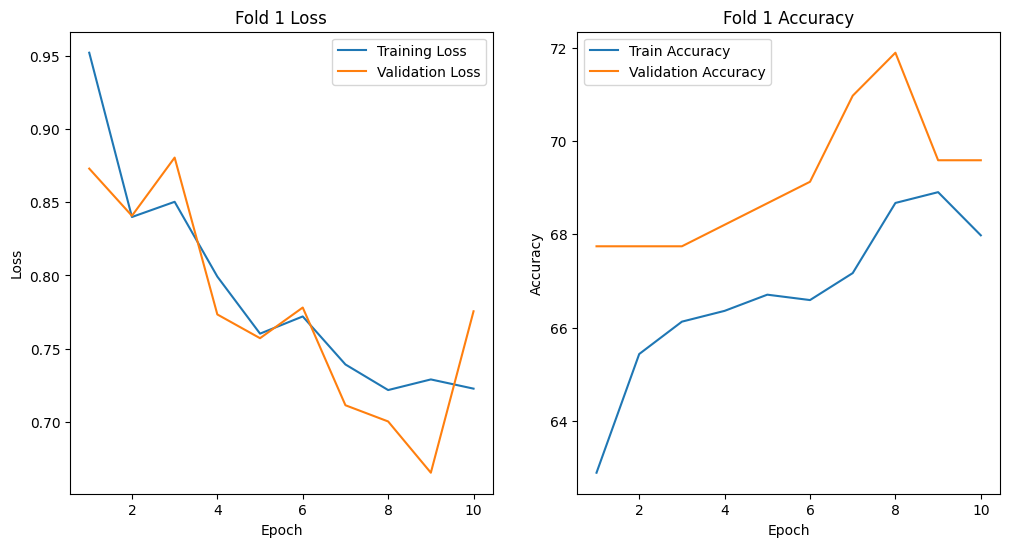



Classification Report for the Best Epoch (Epoch 8) of Fold 1:

              precision    recall  f1-score   support



    Cataract       0.63      0.29      0.39        42

    Diabetes       0.73      0.97      0.83       147

    Glaucoma       0.67      0.07      0.13        28



    accuracy                           0.72       217

   macro avg       0.68      0.44      0.45       217

weighted avg       0.70      0.72      0.66       217





Fold 2/5

Train indices count: 865, Validation indices count: 217

Epoch 1:

  -- Training dataset. Classified 490 out of 865 images correctly (56.647%). Epoch loss: 1.202

   - Validation dataset. Classified 154 out of 217 images correctly (70.968%). Epoch loss: 0.978

Epoch 2:

  -- Training dataset. Classified 558 out of 865 images correctly (64.509%). Epoch loss: 0.933

   - Validation dataset. Classified 154 out of 217 images correctly (70.968%). Epoch loss: 0.950

Epoch 3:

  -- Training dataset. Classified 557 out of 865 images c

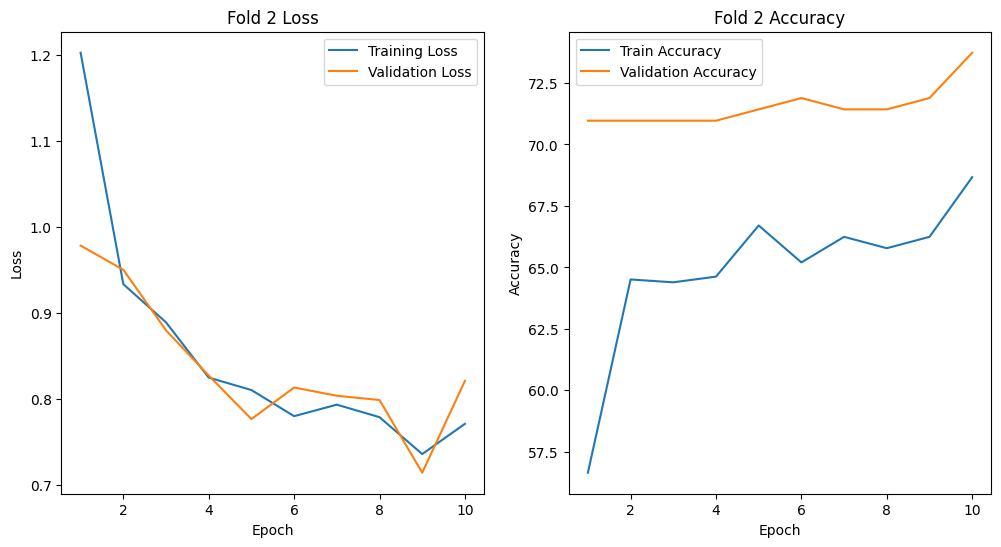



Classification Report for the Best Epoch (Epoch 10) of Fold 2:

              precision    recall  f1-score   support



    Cataract       0.43      0.29      0.34        35

    Diabetes       0.80      0.94      0.86       154

    Glaucoma       0.46      0.21      0.29        28



    accuracy                           0.74       217

   macro avg       0.56      0.48      0.50       217

weighted avg       0.69      0.74      0.70       217





Fold 3/5

Train indices count: 866, Validation indices count: 216

Epoch 1:

  -- Training dataset. Classified 561 out of 866 images correctly (64.781%). Epoch loss: 0.943

   - Validation dataset. Classified 132 out of 216 images correctly (61.111%). Epoch loss: 0.941

Epoch 2:

  -- Training dataset. Classified 580 out of 866 images correctly (66.975%). Epoch loss: 0.833

   - Validation dataset. Classified 132 out of 216 images correctly (61.111%). Epoch loss: 0.963

Epoch 3:

  -- Training dataset. Classified 580 out of 866 images 

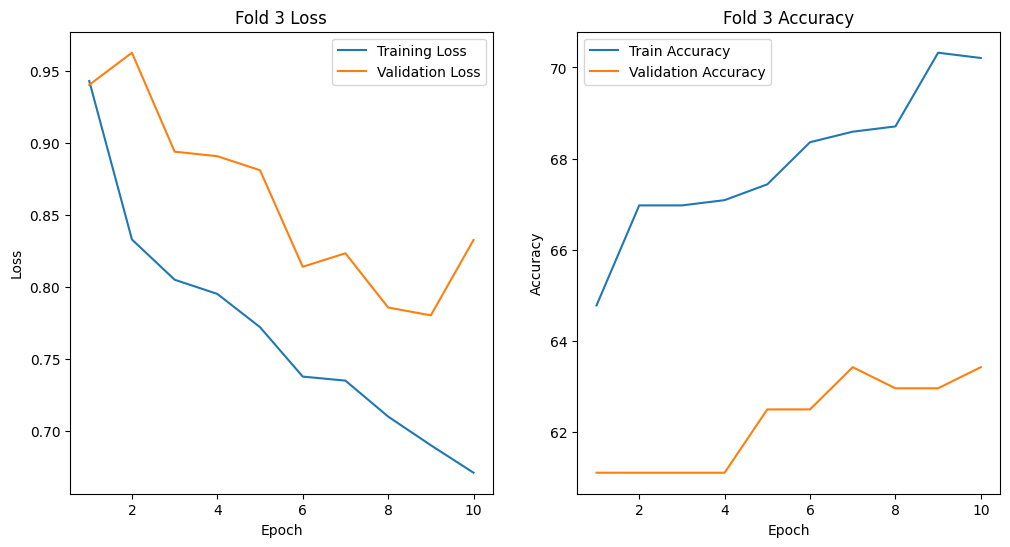



Classification Report for the Best Epoch (Epoch 7) of Fold 3:

              precision    recall  f1-score   support



    Cataract       0.60      0.12      0.20        51

    Diabetes       0.64      0.99      0.78       132

    Glaucoma       0.00      0.00      0.00        33



    accuracy                           0.63       216

   macro avg       0.41      0.37      0.32       216

weighted avg       0.53      0.63      0.52       216





Fold 4/5

Train indices count: 866, Validation indices count: 216

Epoch 1:

  -- Training dataset. Classified 538 out of 866 images correctly (62.125%). Epoch loss: 1.001

   - Validation dataset. Classified 132 out of 216 images correctly (61.111%). Epoch loss: 0.931

Epoch 2:

  -- Training dataset. Classified 580 out of 866 images correctly (66.975%). Epoch loss: 0.839

   - Validation dataset. Classified 132 out of 216 images correctly (61.111%). Epoch loss: 0.971

Epoch 3:

  -- Training dataset. Classified 580 out of 866 images c

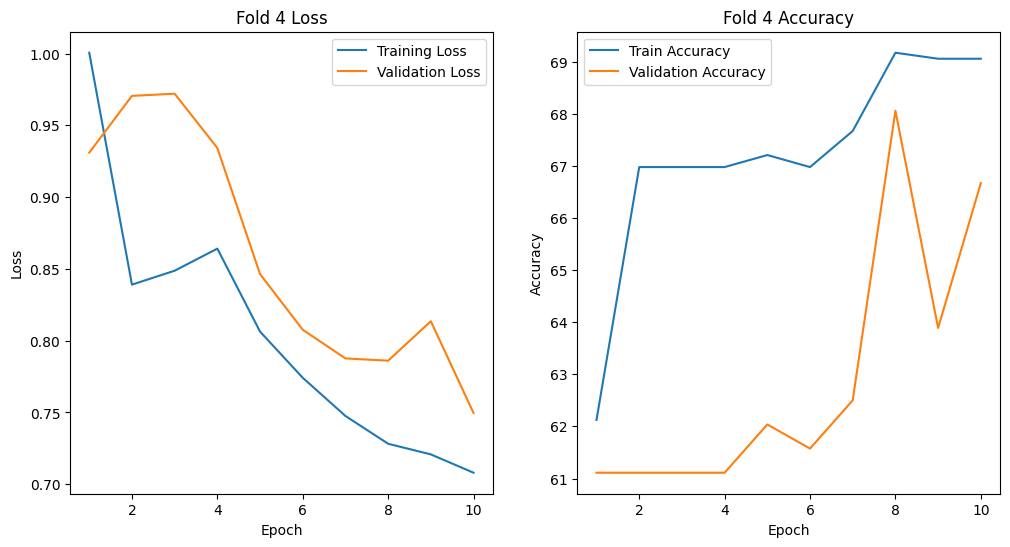



Classification Report for the Best Epoch (Epoch 8) of Fold 4:

              precision    recall  f1-score   support



    Cataract       0.60      0.13      0.21        46

    Diabetes       0.72      0.94      0.81       132

    Glaucoma       0.52      0.45      0.48        38



    accuracy                           0.68       216

   macro avg       0.61      0.51      0.50       216

weighted avg       0.66      0.68      0.63       216





Fold 5/5

Train indices count: 866, Validation indices count: 216

Epoch 1:

  -- Training dataset. Classified 545 out of 866 images correctly (62.933%). Epoch loss: 0.989

   - Validation dataset. Classified 147 out of 216 images correctly (68.056%). Epoch loss: 0.889

Epoch 2:

  -- Training dataset. Classified 565 out of 866 images correctly (65.242%). Epoch loss: 0.854

   - Validation dataset. Classified 147 out of 216 images correctly (68.056%). Epoch loss: 0.882

Epoch 3:

  -- Training dataset. Classified 567 out of 866 images c

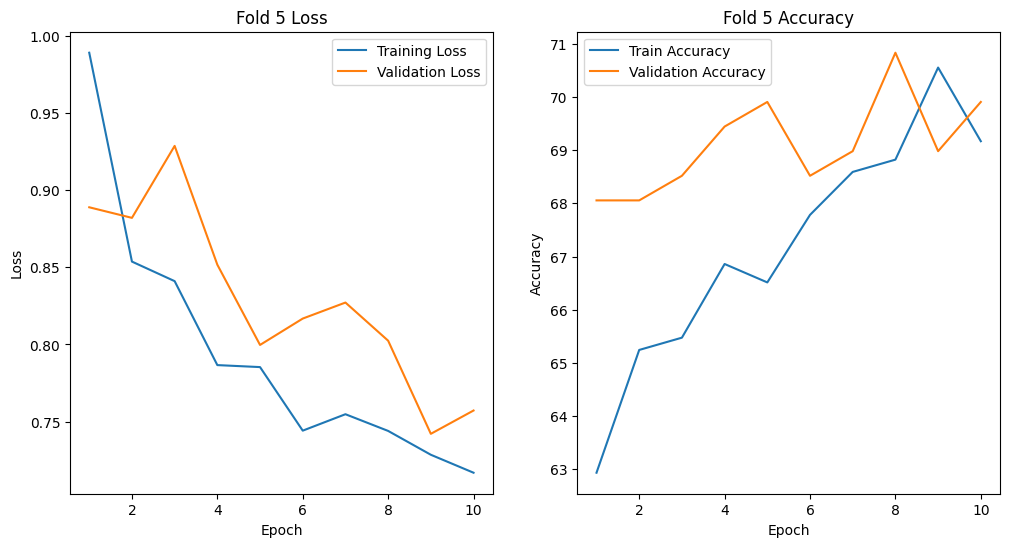



Classification Report for the Best Epoch (Epoch 8) of Fold 5:

              precision    recall  f1-score   support



    Cataract       0.61      0.31      0.41        36

    Diabetes       0.74      0.97      0.84       147

    Glaucoma       0.00      0.00      0.00        33



    accuracy                           0.71       216

   macro avg       0.45      0.42      0.41       216

weighted avg       0.60      0.71      0.64       216





Best overall model from fold 2 with validation accuracy: 73.73%



Confusion Matrix for the best model (Fold 2):


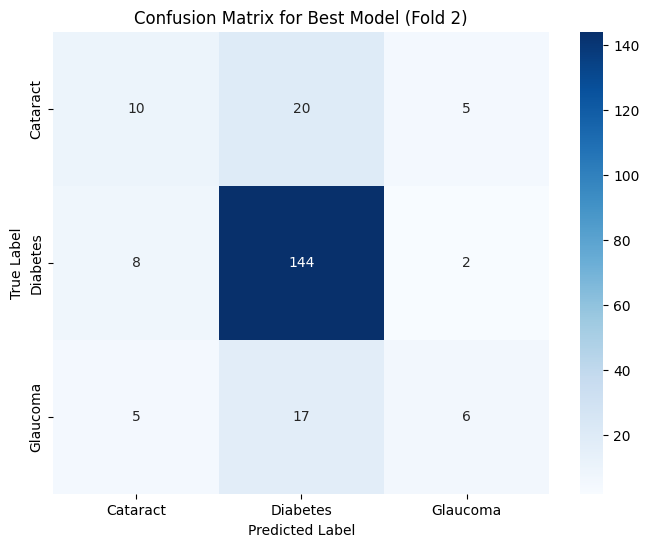



Classification Report for the best model (Fold 2):

              precision    recall  f1-score   support



    Cataract       0.43      0.29      0.34        35

    Diabetes       0.80      0.94      0.86       154

    Glaucoma       0.46      0.21      0.29        28



    accuracy                           0.74       217

   macro avg       0.56      0.48      0.50       217

weighted avg       0.69      0.74      0.70       217



Training and evaluation finished.


In [60]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int, dropout_rate: float):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            # Applying the first convolutional layer followed by ReLU, max pooling, and dropout
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            # Applying the second convolutional layer followed by ReLU, max pooling, and dropout
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            
            # Applying the third convolutional layer followed by ReLU, max pooling, and dropout
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),)
        
        self.classifier = nn.Sequential(
            # Connecting the flattened tensor to the fully connected layer
            nn.Linear(128 * 16 * 16, 256),  # Adjusting to match the flattened size
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # Creating the output layer for classification
            nn.Linear(256, num_classes))
        
    def forward(self, x):
        x = self.features(x)  # Extracting features from the input
        x = x.view(x.size(0), -1)  # Flattening the tensor
        x = self.classifier(x)  # Classifying the flattened tensor
        return x
    
# Define transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the dataset
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the number of epochs and k for k-fold cross-validation
n_epochs = 10
k = 5

# Call the function to train and evaluate the model with k-fold cross-validation
train_and_evaluate_cnnParams_kfold(dataset=dataset, n_epochs=n_epochs, device=device, k=k)

#### Model performance simpleCNNTuned - with image size - 228
* Training Accuracy: Showed a general increase across all folds, with Fold 2/5 achieving the highest final accuracy of 68.092%.
* Validation Accuracy: Improved in most folds, with Fold 2/5 also reaching the highest final accuracy of 73.733%.
* Training Loss: Decreased overall across folds, with the lowest final training loss being 0.727 in Fold 3/5.
* Validation Loss: Decreased overall but showed some fluctuation, particularly with a notable increase in Fold 4/5.


#### The model demonstrated consistent improvement in training accuracy and loss across folds.Validation accuracy generally improved, with Fold 2/5 showing the best performance. Validation loss decreased overall, though there were fluctuations, especially in Fold 4/5, indicating some issues with generalization and potential overfitting.

# simpleCNN tuned - image shape 224

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int, dropout_rate: float):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 256),  
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) 
        x = self.classifier(x)
        return x


    
# Define transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the dataset
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the number of epochs and k for k-fold cross-validation
n_epochs = 10
k = 5

# Call the function to train and evaluate the model with k-fold cross-validation
train_and_evaluate_cnnParams_kfold(dataset=dataset, n_epochs=n_epochs, device=device, k=k)

# simpleCNN-tuned with image shape 448



Fold 1/5

Train indices count: 865, Validation indices count: 217

Epoch 1:

  -- Training dataset. Classified 491 out of 865 images correctly (56.763%). Epoch loss: 3.776

   - Validation dataset. Classified 147 out of 217 images correctly (67.742%). Epoch loss: 0.996

Epoch 2:

  -- Training dataset. Classified 565 out of 865 images correctly (65.318%). Epoch loss: 0.913

   - Validation dataset. Classified 147 out of 217 images correctly (67.742%). Epoch loss: 1.026

Epoch 3:

  -- Training dataset. Classified 560 out of 865 images correctly (64.740%). Epoch loss: 0.867

   - Validation dataset. Classified 147 out of 217 images correctly (67.742%). Epoch loss: 0.883

Epoch 4:

  -- Training dataset. Classified 563 out of 865 images correctly (65.087%). Epoch loss: 0.841

   - Validation dataset. Classified 148 out of 217 images correctly (68.203%). Epoch loss: 0.873

Epoch 5:

  -- Training dataset. Classified 568 out of 865 images correctly (65.665%). Epoch loss: 0.802

   - Vali

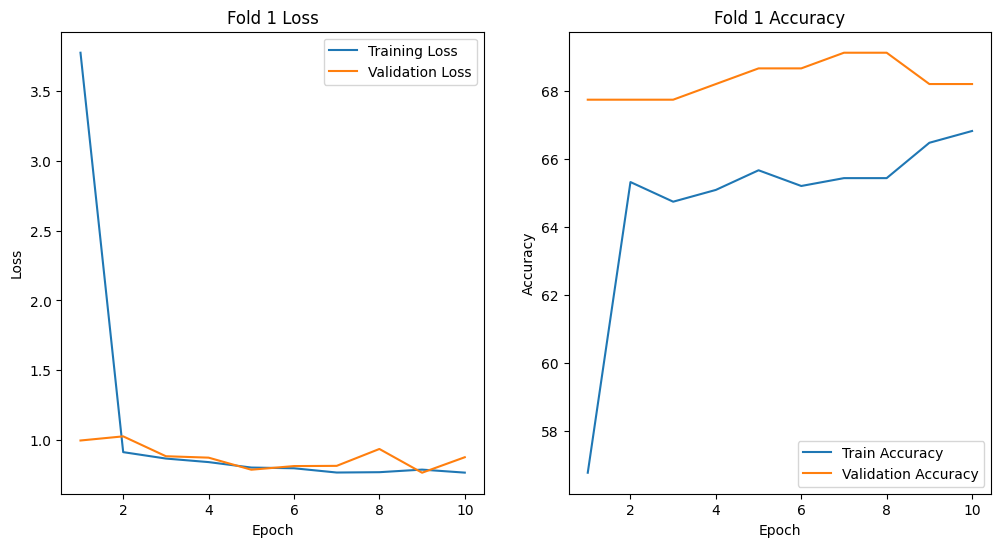



Classification Report for the Best Epoch (Epoch 7) of Fold 1:

              precision    recall  f1-score   support



    Cataract       0.54      0.17      0.25        42

    Diabetes       0.70      0.97      0.81       147

    Glaucoma       0.00      0.00      0.00        28



    accuracy                           0.69       217

   macro avg       0.41      0.38      0.36       217

weighted avg       0.58      0.69      0.60       217





Fold 2/5

Train indices count: 865, Validation indices count: 217

Epoch 1:

  -- Training dataset. Classified 507 out of 865 images correctly (58.613%). Epoch loss: 2.413

   - Validation dataset. Classified 154 out of 217 images correctly (70.968%). Epoch loss: 0.793

Epoch 2:

  -- Training dataset. Classified 558 out of 865 images correctly (64.509%). Epoch loss: 0.920

   - Validation dataset. Classified 154 out of 217 images correctly (70.968%). Epoch loss: 0.875

Epoch 3:

  -- Training dataset. Classified 558 out of 865 images c

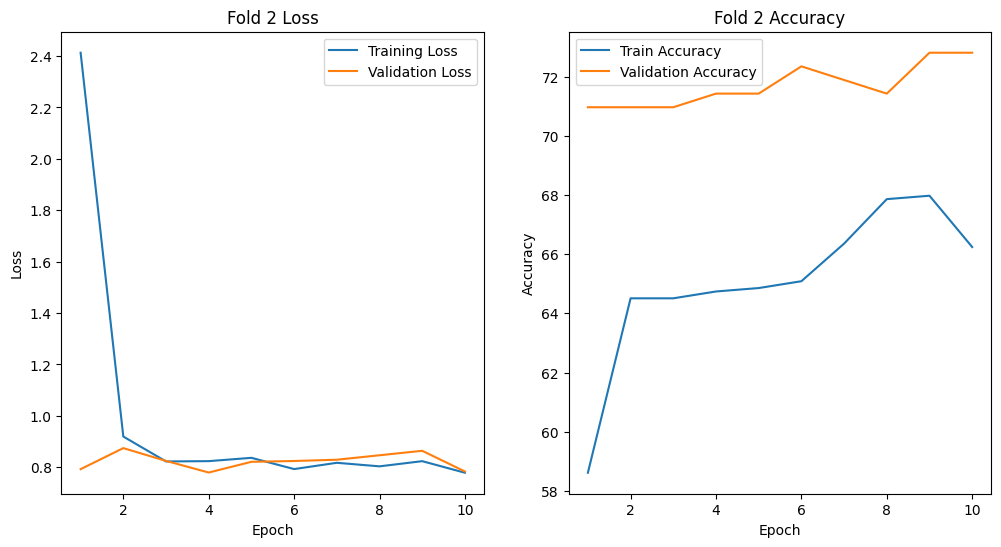



Classification Report for the Best Epoch (Epoch 9) of Fold 2:

              precision    recall  f1-score   support



    Cataract       0.47      0.20      0.28        35

    Diabetes       0.74      0.97      0.84       154

    Glaucoma       1.00      0.07      0.13        28



    accuracy                           0.73       217

   macro avg       0.74      0.41      0.42       217

weighted avg       0.73      0.73      0.66       217





Fold 3/5

Train indices count: 866, Validation indices count: 216

Epoch 1:

  -- Training dataset. Classified 391 out of 866 images correctly (45.150%). Epoch loss: 4.795

   - Validation dataset. Classified 132 out of 216 images correctly (61.111%). Epoch loss: 1.068

Epoch 2:

  -- Training dataset. Classified 578 out of 866 images correctly (66.744%). Epoch loss: 0.922

   - Validation dataset. Classified 132 out of 216 images correctly (61.111%). Epoch loss: 0.958

Epoch 3:

  -- Training dataset. Classified 580 out of 866 images c

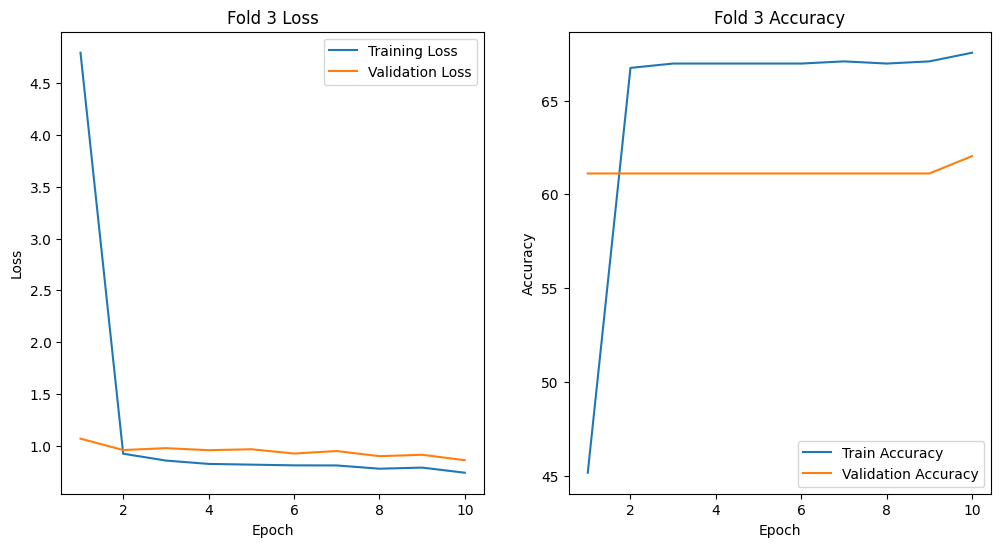



Classification Report for the Best Epoch (Epoch 10) of Fold 3:

              precision    recall  f1-score   support



    Cataract       0.00      0.00      0.00        51

    Diabetes       0.64      0.98      0.77       132

    Glaucoma       0.45      0.15      0.23        33



    accuracy                           0.62       216

   macro avg       0.36      0.38      0.33       216

weighted avg       0.46      0.62      0.51       216





Fold 4/5

Train indices count: 866, Validation indices count: 216

Epoch 1:

  -- Training dataset. Classified 484 out of 866 images correctly (55.889%). Epoch loss: 6.029

   - Validation dataset. Classified 132 out of 216 images correctly (61.111%). Epoch loss: 0.939

Epoch 2:

  -- Training dataset. Classified 581 out of 866 images correctly (67.090%). Epoch loss: 0.816

   - Validation dataset. Classified 134 out of 216 images correctly (62.037%). Epoch loss: 0.912

Epoch 3:

  -- Training dataset. Classified 585 out of 866 images 

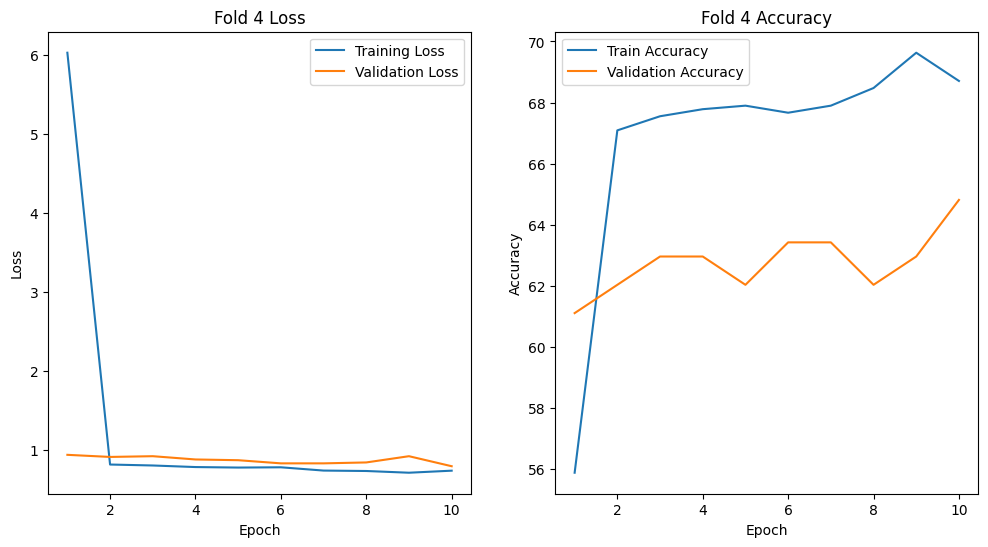



Classification Report for the Best Epoch (Epoch 10) of Fold 4:

              precision    recall  f1-score   support



    Cataract       0.89      0.17      0.29        46

    Diabetes       0.64      1.00      0.78       132

    Glaucoma       0.00      0.00      0.00        38



    accuracy                           0.65       216

   macro avg       0.51      0.39      0.36       216

weighted avg       0.58      0.65      0.54       216





Fold 5/5

Train indices count: 866, Validation indices count: 216

Epoch 1:

  -- Training dataset. Classified 422 out of 866 images correctly (48.730%). Epoch loss: 5.299

   - Validation dataset. Classified 147 out of 216 images correctly (68.056%). Epoch loss: 1.081

Epoch 2:

  -- Training dataset. Classified 565 out of 866 images correctly (65.242%). Epoch loss: 1.062

   - Validation dataset. Classified 147 out of 216 images correctly (68.056%). Epoch loss: 0.843

Epoch 3:

  -- Training dataset. Classified 565 out of 866 images 

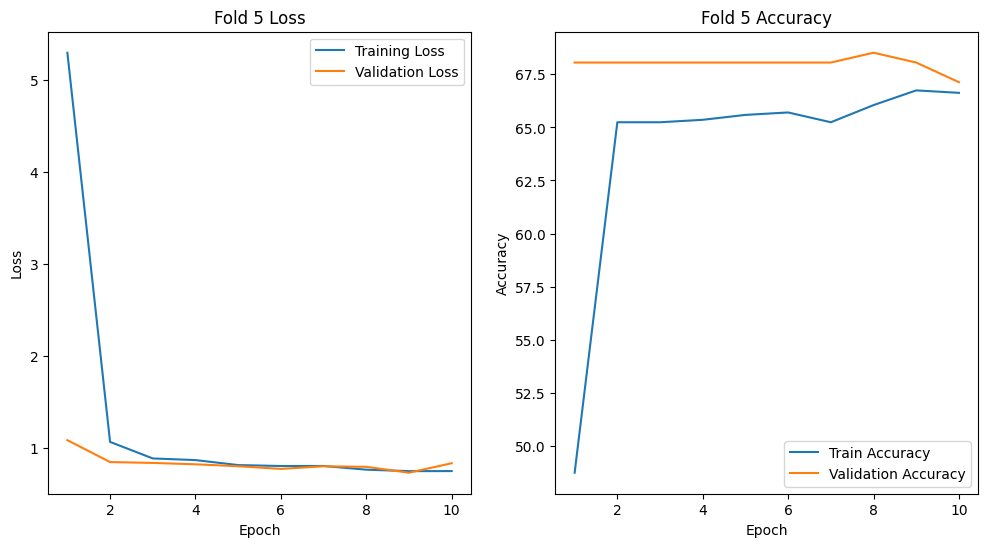



Classification Report for the Best Epoch (Epoch 8) of Fold 5:

              precision    recall  f1-score   support



    Cataract       0.50      0.06      0.10        36

    Diabetes       0.69      0.99      0.81       147

    Glaucoma       0.00      0.00      0.00        33



    accuracy                           0.69       216

   macro avg       0.40      0.35      0.30       216

weighted avg       0.55      0.69      0.57       216





Best overall model from fold 2 with validation accuracy: 72.81%



Confusion Matrix for the best model (Fold 2):


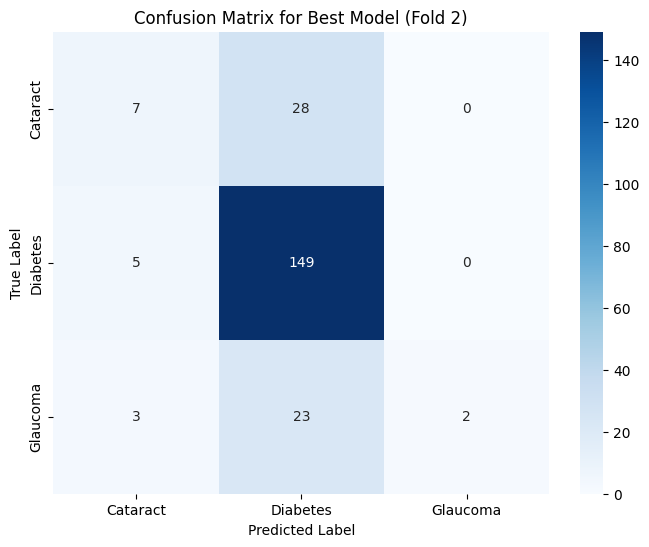



Classification Report for the best model (Fold 2):

              precision    recall  f1-score   support



    Cataract       0.47      0.20      0.28        35

    Diabetes       0.74      0.97      0.84       154

    Glaucoma       1.00      0.07      0.13        28



    accuracy                           0.73       217

   macro avg       0.74      0.41      0.42       217

weighted avg       0.73      0.73      0.66       217



Training and evaluation finished.


In [62]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int, dropout_rate: float):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 56 * 56, 512),  # Updated this line
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x


    
# Define transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the dataset
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the number of epochs and k for k-fold cross-validation
n_epochs = 10
k = 5

# Call the function to train and evaluate the model with k-fold cross-validation
train_and_evaluate_cnnParams_kfold(dataset=dataset, n_epochs=n_epochs, device=device, k=k)

# Pretrained model - resnet50
### Resnet50 is one of the baseline pretrained model, which performs good with smaller set of images.

In [63]:
def train_and_evaluate_resnet_kfold(dataset: datasets.ImageFolder, n_epochs: int, device: torch.device, k: int = 5):
    num_classes = len(dataset.classes)  # Getting the number of classes in the dataset
    kf = KFold(n_splits=k, shuffle=True, random_state=42)  # Initializing KFold for cross-validation

    best_model = None  # Variable to store the best model
    best_acc = 0  # Variable to store the best accuracy
    best_acc_fold = 0  # Variable to store the fold with the best accuracy
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(dataset)))):
        print(f"\nFold {fold + 1}/{k}")

        # Creating data loaders for this fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4)  # DataLoader for training
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=4)  # DataLoader for validation

        model = models.resnet50(pretrained=True)  # Loading the pre-trained ResNet50 model
        in_features = model.fc.in_features  # Getting the number of input features to the final layer
        model.fc = nn.Linear(in_features, num_classes)  # Replacing the final layer for our number of classes
        model = model.to(device)  # Moving the model to the specified device
        criterion = nn.CrossEntropyLoss()  # Defining the loss function
        optimizer = optim.Adam(model.parameters(), lr=0.001)  # Defining the optimizer
        
        train_acc_history = []  # List to store training accuracies
        val_acc_history = []  # List to store validation accuracies
        epoch_losses = []  # List to store training losses
        val_losses = []  # List to store validation losses
        best_epoch_labels = []
        best_epoch_preds = []

        best_epoch = -1
        best_epoch_acc = 0
        best_epoch_state = None

        for epoch in range(n_epochs):
            model.train()  # Setting the model to training mode
            running_loss = 0.0  # Variable to accumulate the training loss
            correct_train = 0  # Variable to count correct predictions in training
            total_train = 0  # Variable to count total samples in training

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)  # Moving data to the device

                optimizer.zero_grad()  # Zeroing the gradients
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)  # Computing the loss
                loss.backward()  # Backward pass
                optimizer.step()  # Optimizing the weights

                running_loss += loss.item() * images.size(0)  # Accumulating loss
                _, predicted = torch.max(outputs, 1)  # Getting predictions
                total_train += labels.size(0)  # Updating total training samples
                correct_train += (predicted == labels).sum().item()  # Updating correct predictions

            train_accuracy = 100.0 * correct_train / total_train  # Calculating training accuracy
            train_acc_history.append(train_accuracy)  # Storing training accuracy
            epoch_loss = running_loss / total_train  # Calculating average training loss
            epoch_losses.append(epoch_loss)  # Storing training loss

            # Validation phase
            model.eval()  # Setting the model to evaluation mode
            running_val_loss = 0.0  # Variable to accumulate the validation loss
            correct_val = 0  # Variable to count correct predictions in validation
            total_val = 0  # Variable to count total samples in validation
            fold_labels = []
            fold_preds = []

            with torch.no_grad():  # Disabling gradient computation
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)  # Moving data to the device
                    outputs = model(images)  # Forward pass
                    loss = criterion(outputs, labels)  # Computing the loss
                    running_val_loss += loss.item() * images.size(0)  # Accumulating loss
                    _, predicted = torch.max(outputs, 1)  # Getting predictions
                    total_val += labels.size(0)  # Updating total validation samples
                    correct_val += (predicted == labels).sum().item()  # Updating correct predictions
                    fold_labels.extend(labels.cpu().numpy())  # Storing true labels
                    fold_preds.extend(predicted.cpu().numpy())  # Storing predicted labels

            val_accuracy = 100.0 * correct_val / total_val  # Calculating validation accuracy
            val_acc_history.append(val_accuracy)  # Storing validation accuracy
            val_loss = running_val_loss / total_val  # Calculating average validation loss
            val_losses.append(val_loss)  # Storing validation loss

            if val_accuracy > best_epoch_acc:
                best_epoch_acc = val_accuracy
                best_epoch = epoch
                best_epoch_state = model.state_dict()
                best_epoch_labels = fold_labels.copy()
                best_epoch_preds = fold_preds.copy()

            print(f"Epoch {epoch + 1}:")
            print(f"  -- Training dataset. Got {correct_train} out of {total_train} images correctly ({train_accuracy:.3f}%). Epoch loss: {epoch_loss:.3f}")
            print(f"   - Validation dataset. Got {correct_val} out of {total_val} images correctly ({val_accuracy:.3f}%). Epoch loss: {val_loss:.3f}")

        # Plotting loss metrics for this fold
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, n_epochs + 1), epoch_losses, label='Training Loss')
        plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
        plt.title(f'Fold {fold + 1} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plotting accuracy metrics for this fold
        plt.subplot(1, 2, 2)
        plt.plot(range(1, n_epochs + 1), train_acc_history, label='Train Accuracy')
        plt.plot(range(1, n_epochs + 1), val_acc_history, label='Validation Accuracy')
        plt.title(f'Fold {fold + 1} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Plotting confusion matrix for the best epoch of this fold
        cm_best_epoch = confusion_matrix(best_epoch_labels, best_epoch_preds, labels=list(range(num_classes)))
#         plt.figure(figsize=(10, 8))
#         sns.heatmap(cm_best_epoch, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
#         plt.title(f'Confusion Matrix for Best Epoch (Epoch {best_epoch + 1}) - Fold {fold + 1}')
#         plt.xlabel('Predicted Label')
#         plt.ylabel('True Label')
#         plt.show()

        print(f"\nClassification Report for the Best Epoch (Epoch {best_epoch + 1}) of Fold {fold + 1}:")
        print(classification_report(best_epoch_labels, best_epoch_preds, target_names=dataset.classes))

        # Save the best model of this fold if it has the highest validation accuracy
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            best_acc_fold = fold
            best_model = best_epoch_state

        fold_results.append({
            'model_state': best_epoch_state,
            'val_accuracy': best_epoch_acc,
            'fold': fold + 1,
            'confusion_matrix': cm_best_epoch,
            'classification_report': classification_report(best_epoch_labels, best_epoch_preds, target_names=dataset.classes)
        })

    # Saving the best model after all folds
    if best_model:
        torch.save(best_model, f'resnet_ims448_model_fold_{best_acc_fold + 1}_accuracy_{best_acc:.2f}.pth')

    # Comparing all best models and printing the best one
    best_overall = max(fold_results, key=lambda x: x['val_accuracy'])
    print(f"\nBest overall model from fold {best_overall['fold']} with validation accuracy: {best_overall['val_accuracy']:.2f}%")

    # Print confusion matrix and classification report for the best overall model
    print(f"\nConfusion Matrix for the best model (Fold {best_overall['fold']}):")
    plt.figure(figsize=(10, 8))
    sns.heatmap(best_overall['confusion_matrix'], annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title(f'Confusion Matrix for Best Model (Fold {best_overall["fold"]})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print(f"\nClassification Report for the best model (Fold {best_overall['fold']}):")
    print(best_overall['classification_report'])

    print("Training and evaluation finished.")

# Resnet50 with image size 128



Fold 1/5


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth

100%|██████████| 97.8M/97.8M [00:00<00:00, 156MB/s] 


Epoch 1:

  -- Training dataset. Got 650 out of 865 images correctly (75.145%). Epoch loss: 0.664

   - Validation dataset. Got 82 out of 217 images correctly (37.788%). Epoch loss: 2.964

Epoch 2:

  -- Training dataset. Got 753 out of 865 images correctly (87.052%). Epoch loss: 0.362

   - Validation dataset. Got 159 out of 217 images correctly (73.272%). Epoch loss: 0.715

Epoch 3:

  -- Training dataset. Got 787 out of 865 images correctly (90.983%). Epoch loss: 0.246

   - Validation dataset. Got 148 out of 217 images correctly (68.203%). Epoch loss: 0.930

Epoch 4:

  -- Training dataset. Got 797 out of 865 images correctly (92.139%). Epoch loss: 0.227

   - Validation dataset. Got 179 out of 217 images correctly (82.488%). Epoch loss: 0.546

Epoch 5:

  -- Training dataset. Got 767 out of 865 images correctly (88.671%). Epoch loss: 0.368

   - Validation dataset. Got 173 out of 217 images correctly (79.724%). Epoch loss: 39.386

Epoch 6:

  -- Training dataset. Got 754 out of 86

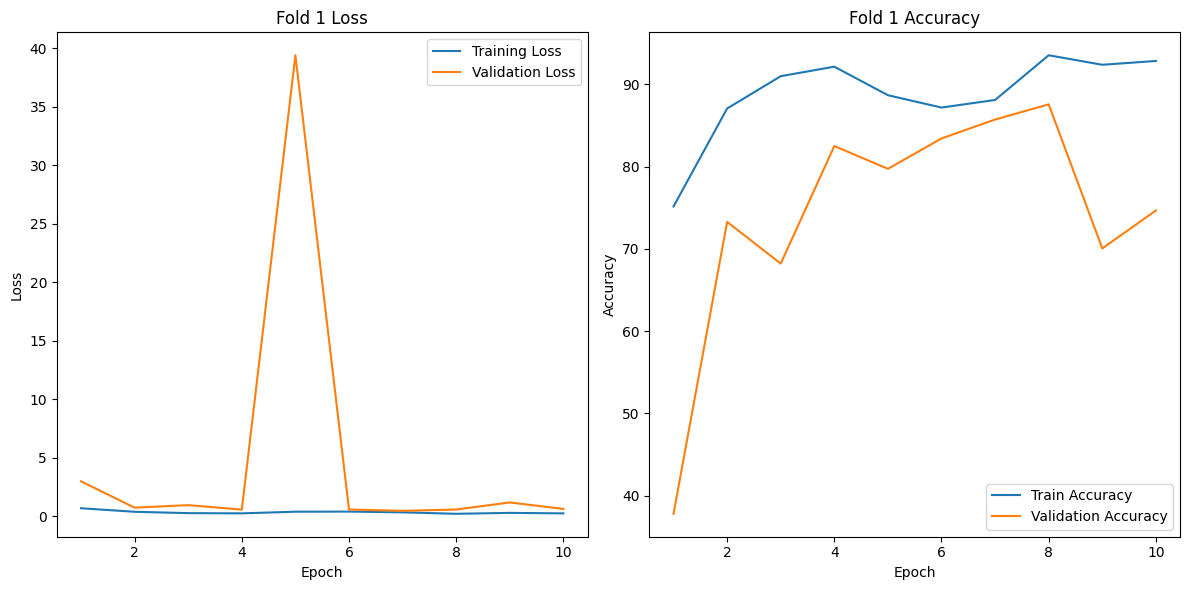



Classification Report for the Best Epoch (Epoch 8) of Fold 1:

              precision    recall  f1-score   support



    Cataract       0.80      0.86      0.83        42

    Diabetes       0.90      0.96      0.93       147

    Glaucoma       0.81      0.46      0.59        28



    accuracy                           0.88       217

   macro avg       0.84      0.76      0.78       217

weighted avg       0.87      0.88      0.87       217





Fold 2/5

Epoch 1:

  -- Training dataset. Got 655 out of 865 images correctly (75.723%). Epoch loss: 0.620

   - Validation dataset. Got 120 out of 217 images correctly (55.300%). Epoch loss: 1.576

Epoch 2:

  -- Training dataset. Got 716 out of 865 images correctly (82.775%). Epoch loss: 0.506

   - Validation dataset. Got 188 out of 217 images correctly (86.636%). Epoch loss: 0.402

Epoch 3:

  -- Training dataset. Got 772 out of 865 images correctly (89.249%). Epoch loss: 0.316

   - Validation dataset. Got 189 out of 217 images co

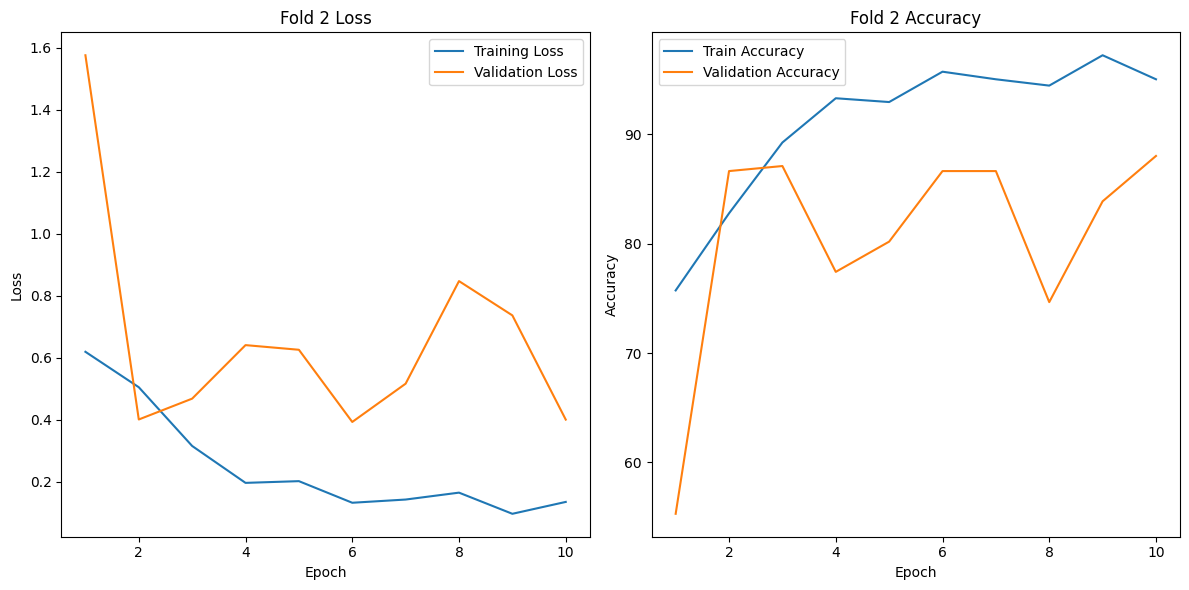



Classification Report for the Best Epoch (Epoch 10) of Fold 2:

              precision    recall  f1-score   support



    Cataract       0.91      0.86      0.88        35

    Diabetes       0.93      0.92      0.93       154

    Glaucoma       0.61      0.68      0.64        28



    accuracy                           0.88       217

   macro avg       0.82      0.82      0.82       217

weighted avg       0.88      0.88      0.88       217





Fold 3/5

Epoch 1:

  -- Training dataset. Got 671 out of 866 images correctly (77.483%). Epoch loss: 0.634

   - Validation dataset. Got 138 out of 216 images correctly (63.889%). Epoch loss: 2.251

Epoch 2:

  -- Training dataset. Got 739 out of 866 images correctly (85.335%). Epoch loss: 0.386

   - Validation dataset. Got 183 out of 216 images correctly (84.722%). Epoch loss: 0.398

Epoch 3:

  -- Training dataset. Got 764 out of 866 images correctly (88.222%). Epoch loss: 0.304

   - Validation dataset. Got 91 out of 216 images co

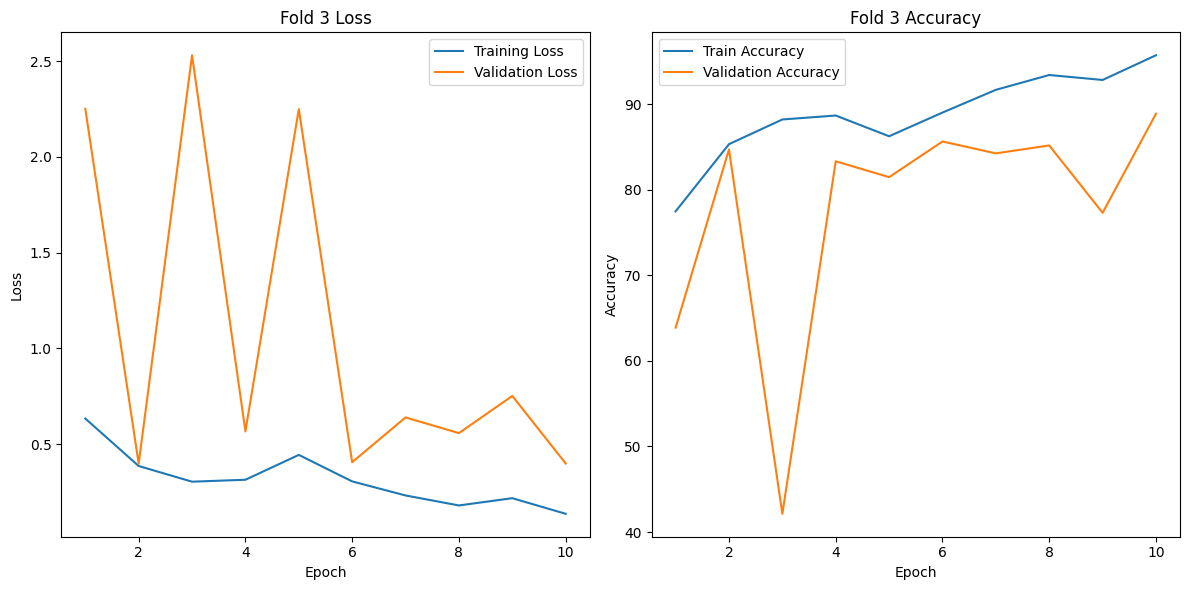



Classification Report for the Best Epoch (Epoch 10) of Fold 3:

              precision    recall  f1-score   support



    Cataract       0.85      0.88      0.87        51

    Diabetes       0.90      0.97      0.93       132

    Glaucoma       0.90      0.58      0.70        33



    accuracy                           0.89       216

   macro avg       0.89      0.81      0.83       216

weighted avg       0.89      0.89      0.88       216





Fold 4/5

Epoch 1:

  -- Training dataset. Got 662 out of 866 images correctly (76.443%). Epoch loss: 0.668

   - Validation dataset. Got 152 out of 216 images correctly (70.370%). Epoch loss: 22.353

Epoch 2:

  -- Training dataset. Got 661 out of 866 images correctly (76.328%). Epoch loss: 0.754

   - Validation dataset. Got 152 out of 216 images correctly (70.370%). Epoch loss: 0.945

Epoch 3:

  -- Training dataset. Got 727 out of 866 images correctly (83.949%). Epoch loss: 0.447

   - Validation dataset. Got 177 out of 216 images 

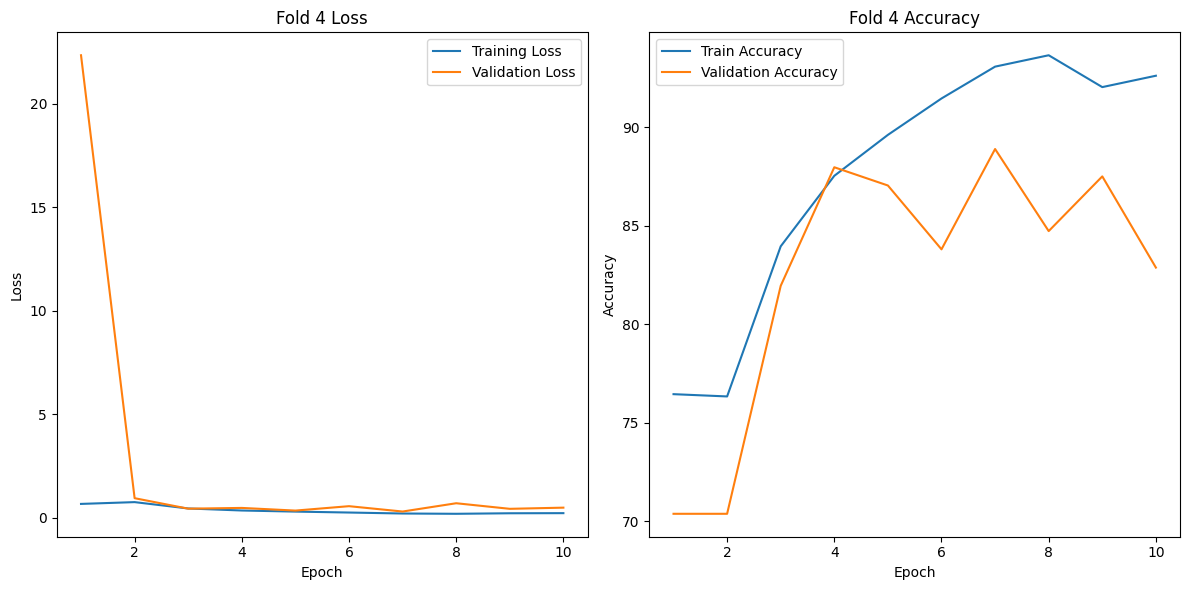



Classification Report for the Best Epoch (Epoch 7) of Fold 4:

              precision    recall  f1-score   support



    Cataract       0.95      0.91      0.93        46

    Diabetes       0.86      0.99      0.92       132

    Glaucoma       0.95      0.50      0.66        38



    accuracy                           0.89       216

   macro avg       0.92      0.80      0.84       216

weighted avg       0.90      0.89      0.88       216





Fold 5/5

Epoch 1:

  -- Training dataset. Got 652 out of 866 images correctly (75.289%). Epoch loss: 0.703

   - Validation dataset. Got 134 out of 216 images correctly (62.037%). Epoch loss: 1.038

Epoch 2:

  -- Training dataset. Got 701 out of 866 images correctly (80.947%). Epoch loss: 0.464

   - Validation dataset. Got 171 out of 216 images correctly (79.167%). Epoch loss: 1.996

Epoch 3:

  -- Training dataset. Got 709 out of 866 images correctly (81.871%). Epoch loss: 0.495

   - Validation dataset. Got 150 out of 216 images co

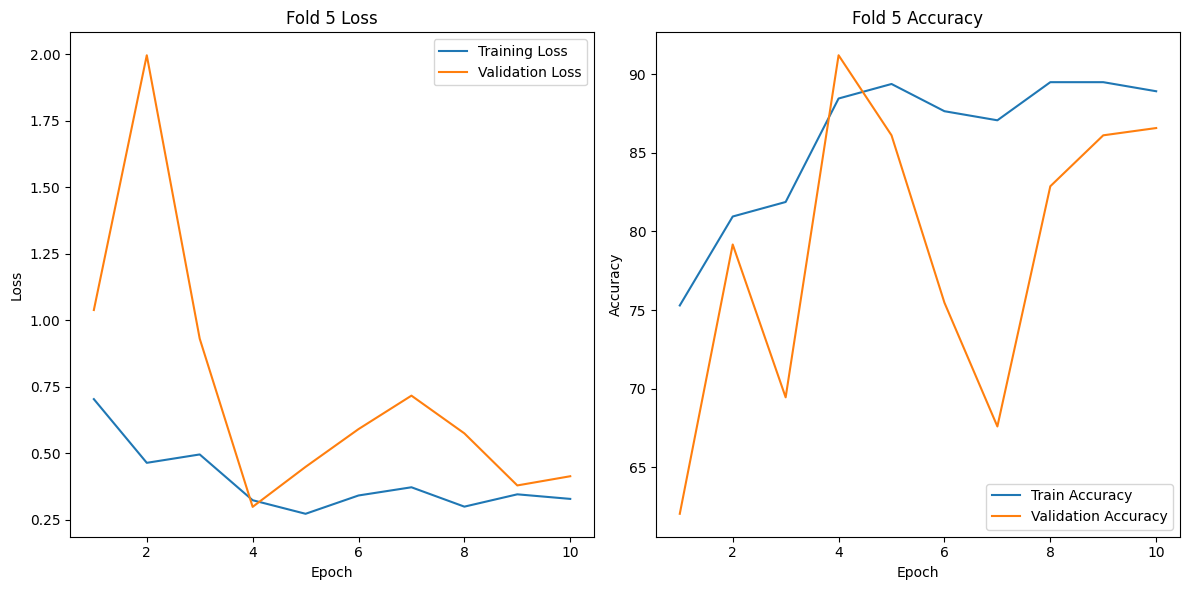



Classification Report for the Best Epoch (Epoch 4) of Fold 5:

              precision    recall  f1-score   support



    Cataract       0.94      0.94      0.94        36

    Diabetes       0.93      0.95      0.94       147

    Glaucoma       0.79      0.70      0.74        33



    accuracy                           0.91       216

   macro avg       0.89      0.86      0.88       216

weighted avg       0.91      0.91      0.91       216





Best overall model from fold 5 with validation accuracy: 91.20%



Confusion Matrix for the best model (Fold 5):


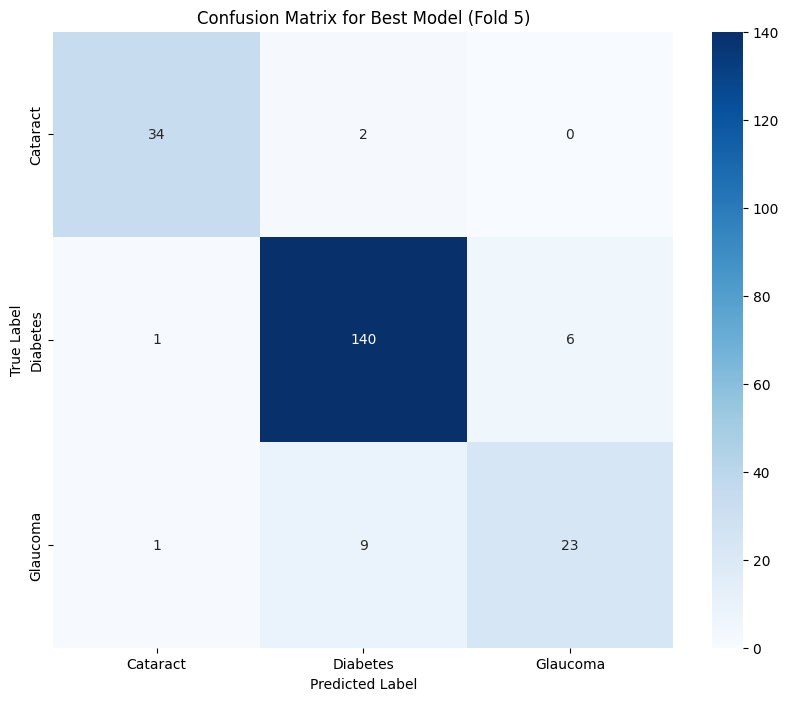



Classification Report for the best model (Fold 5):

              precision    recall  f1-score   support



    Cataract       0.94      0.94      0.94        36

    Diabetes       0.93      0.95      0.94       147

    Glaucoma       0.79      0.70      0.74        33



    accuracy                           0.91       216

   macro avg       0.89      0.86      0.88       216

weighted avg       0.91      0.91      0.91       216



Training and evaluation finished.


In [64]:
# Defining transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resizing images to 128x128
    transforms.ToTensor(),  # Converting images to tensors
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalizing images (commented out)
])

# Creating the dataset
dataset = datasets.ImageFolder(root=train_dir, transform=transform)  # Loading images from the specified directory and applying transformations

# Defining the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Setting device to GPU if available, otherwise CPU

# Defining the number of epochs and k for k-fold cross-validation
n_epochs = 10  # Number of epochs for training
k = 5  # Number of folds for cross-validation

# Calling the function to train and evaluate the model with k-fold cross-validation
train_and_evaluate_resnet_kfold(dataset=dataset, n_epochs=n_epochs, device=device, k=k)  # Training and evaluating the model using k-fold cross-validation


# Resnet50 with image size 224



Fold 1/5

Epoch 1:

  -- Training dataset. Got 665 out of 865 images correctly (76.879%). Epoch loss: 0.653

   - Validation dataset. Got 162 out of 217 images correctly (74.654%). Epoch loss: 1.669

Epoch 2:

  -- Training dataset. Got 734 out of 865 images correctly (84.855%). Epoch loss: 0.424

   - Validation dataset. Got 127 out of 217 images correctly (58.525%). Epoch loss: 1.175

Epoch 3:

  -- Training dataset. Got 774 out of 865 images correctly (89.480%). Epoch loss: 0.311

   - Validation dataset. Got 153 out of 217 images correctly (70.507%). Epoch loss: 0.742

Epoch 4:

  -- Training dataset. Got 788 out of 865 images correctly (91.098%). Epoch loss: 0.258

   - Validation dataset. Got 182 out of 217 images correctly (83.871%). Epoch loss: 0.510

Epoch 5:

  -- Training dataset. Got 789 out of 865 images correctly (91.214%). Epoch loss: 0.248

   - Validation dataset. Got 168 out of 217 images correctly (77.419%). Epoch loss: 0.829

Epoch 6:

  -- Training dataset. Got 7

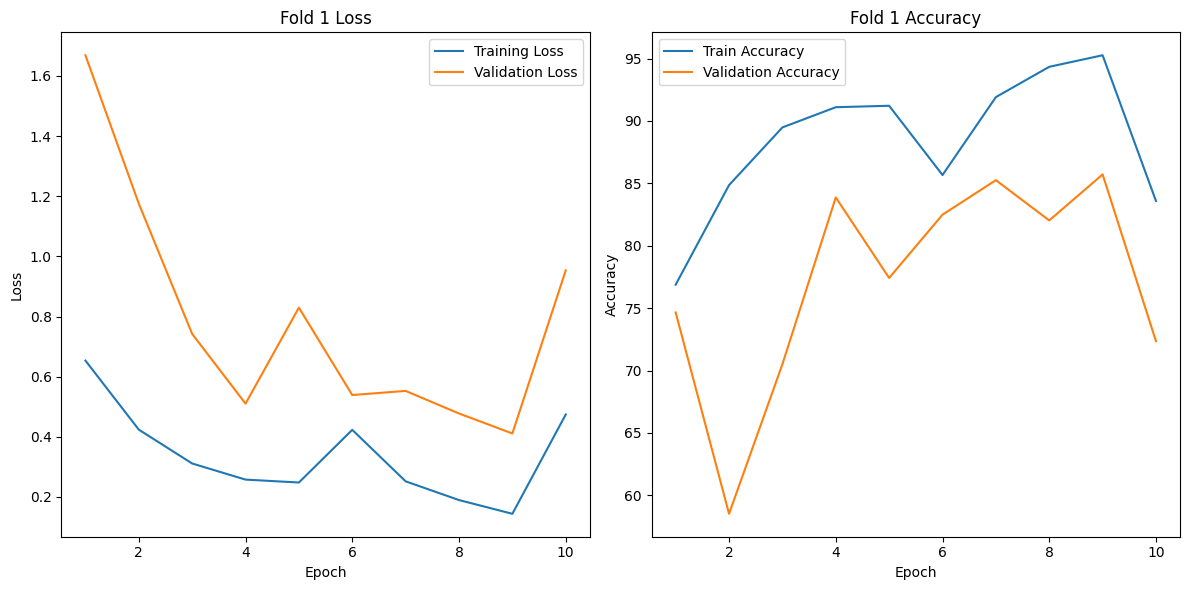



Classification Report for the Best Epoch (Epoch 9) of Fold 1:

              precision    recall  f1-score   support



    Cataract       0.71      0.93      0.80        42

    Diabetes       0.94      0.89      0.92       147

    Glaucoma       0.70      0.57      0.63        28



    accuracy                           0.86       217

   macro avg       0.78      0.80      0.78       217

weighted avg       0.87      0.86      0.86       217





Fold 2/5

Epoch 1:

  -- Training dataset. Got 660 out of 865 images correctly (76.301%). Epoch loss: 0.631

   - Validation dataset. Got 45 out of 217 images correctly (20.737%). Epoch loss: 57.426

Epoch 2:

  -- Training dataset. Got 737 out of 865 images correctly (85.202%). Epoch loss: 0.425

   - Validation dataset. Got 192 out of 217 images correctly (88.479%). Epoch loss: 0.351

Epoch 3:

  -- Training dataset. Got 771 out of 865 images correctly (89.133%). Epoch loss: 0.303

   - Validation dataset. Got 180 out of 217 images co

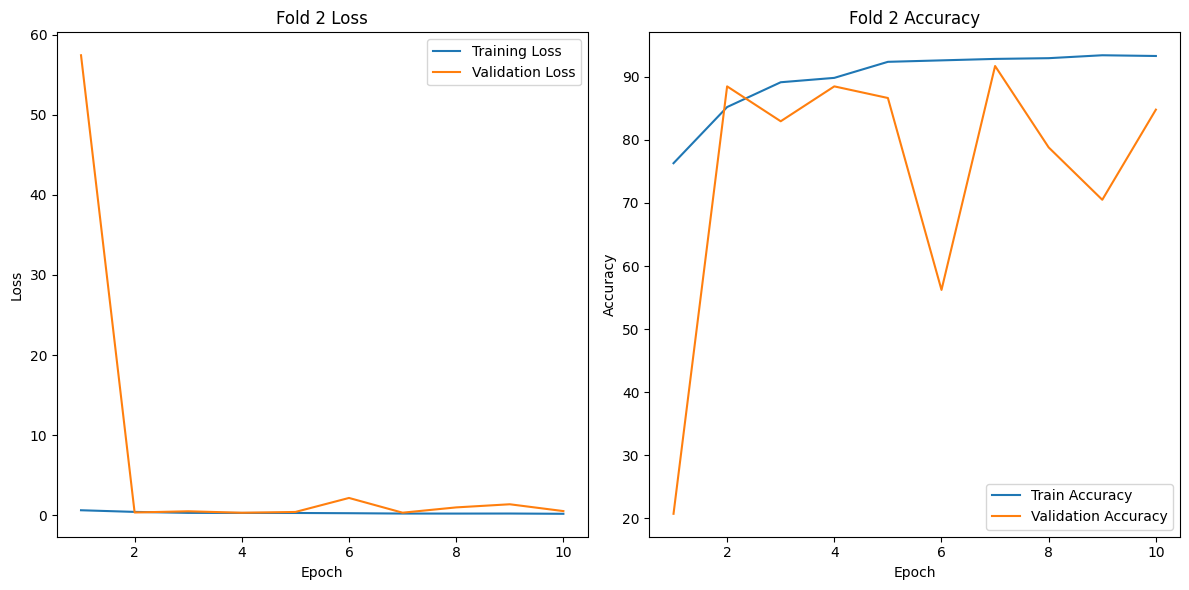



Classification Report for the Best Epoch (Epoch 7) of Fold 2:

              precision    recall  f1-score   support



    Cataract       0.94      0.91      0.93        35

    Diabetes       0.94      0.95      0.95       154

    Glaucoma       0.77      0.71      0.74        28



    accuracy                           0.92       217

   macro avg       0.88      0.86      0.87       217

weighted avg       0.92      0.92      0.92       217





Fold 3/5

Epoch 1:

  -- Training dataset. Got 663 out of 866 images correctly (76.559%). Epoch loss: 0.590

   - Validation dataset. Got 106 out of 216 images correctly (49.074%). Epoch loss: 13.415

Epoch 2:

  -- Training dataset. Got 705 out of 866 images correctly (81.409%). Epoch loss: 0.520

   - Validation dataset. Got 165 out of 216 images correctly (76.389%). Epoch loss: 0.813

Epoch 3:

  -- Training dataset. Got 718 out of 866 images correctly (82.910%). Epoch loss: 0.424

   - Validation dataset. Got 132 out of 216 images c

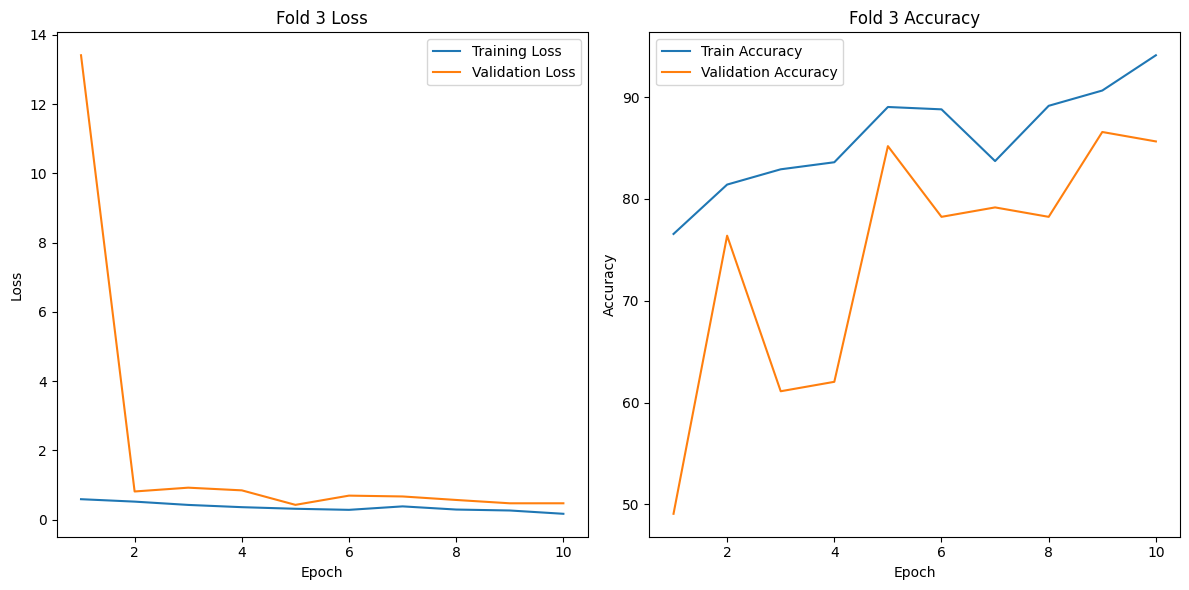



Classification Report for the Best Epoch (Epoch 9) of Fold 3:

              precision    recall  f1-score   support



    Cataract       0.88      0.90      0.89        51

    Diabetes       0.87      0.98      0.92       132

    Glaucoma       0.80      0.36      0.50        33



    accuracy                           0.87       216

   macro avg       0.85      0.75      0.77       216

weighted avg       0.86      0.87      0.85       216





Fold 4/5

Epoch 1:

  -- Training dataset. Got 684 out of 866 images correctly (78.984%). Epoch loss: 0.562

   - Validation dataset. Got 90 out of 216 images correctly (41.667%). Epoch loss: 6.166

Epoch 2:

  -- Training dataset. Got 719 out of 866 images correctly (83.025%). Epoch loss: 0.434

   - Validation dataset. Got 186 out of 216 images correctly (86.111%). Epoch loss: 0.412

Epoch 3:

  -- Training dataset. Got 756 out of 866 images correctly (87.298%). Epoch loss: 0.364

   - Validation dataset. Got 87 out of 216 images corr

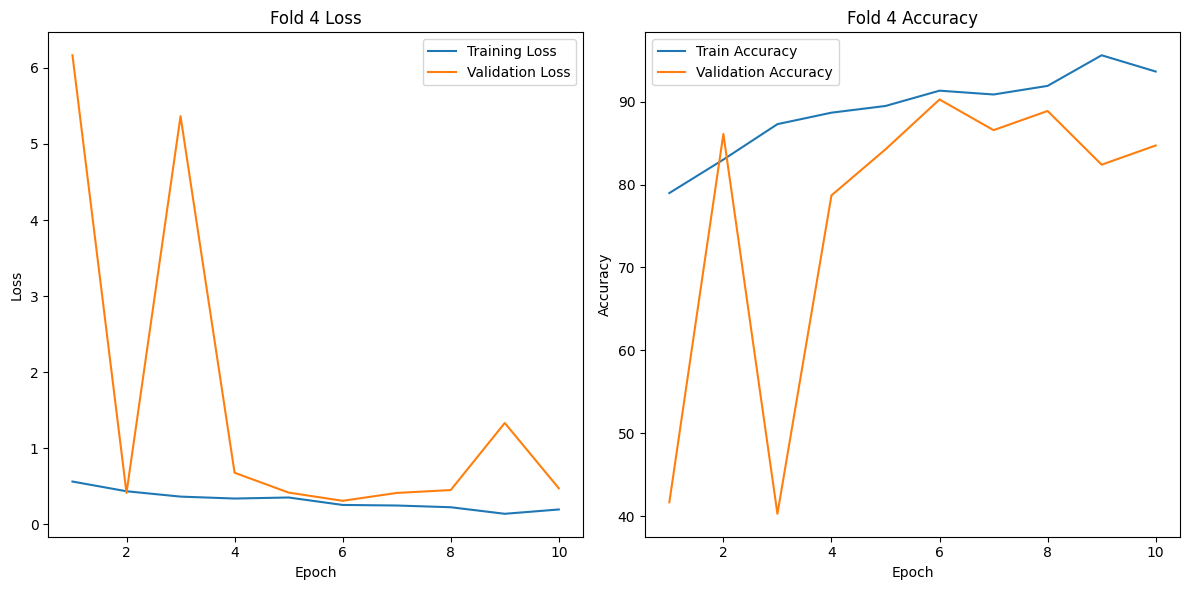



Classification Report for the Best Epoch (Epoch 6) of Fold 4:

              precision    recall  f1-score   support



    Cataract       0.92      1.00      0.96        46

    Diabetes       0.94      0.92      0.93       132

    Glaucoma       0.75      0.71      0.73        38



    accuracy                           0.90       216

   macro avg       0.87      0.88      0.87       216

weighted avg       0.90      0.90      0.90       216





Fold 5/5

Epoch 1:

  -- Training dataset. Got 660 out of 866 images correctly (76.212%). Epoch loss: 0.771

   - Validation dataset. Got 146 out of 216 images correctly (67.593%). Epoch loss: 2.541

Epoch 2:

  -- Training dataset. Got 727 out of 866 images correctly (83.949%). Epoch loss: 0.462

   - Validation dataset. Got 186 out of 216 images correctly (86.111%). Epoch loss: 0.367

Epoch 3:

  -- Training dataset. Got 759 out of 866 images correctly (87.644%). Epoch loss: 0.373

   - Validation dataset. Got 192 out of 216 images co

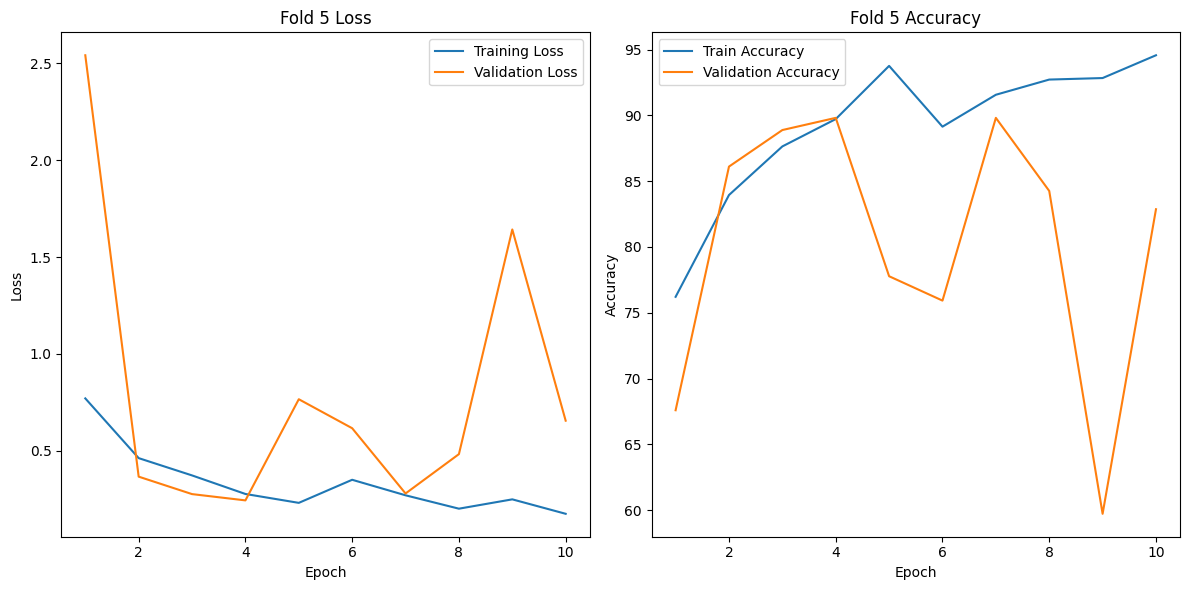



Classification Report for the Best Epoch (Epoch 4) of Fold 5:

              precision    recall  f1-score   support



    Cataract       0.92      0.97      0.95        36

    Diabetes       0.93      0.94      0.93       147

    Glaucoma       0.72      0.64      0.68        33



    accuracy                           0.90       216

   macro avg       0.86      0.85      0.85       216

weighted avg       0.89      0.90      0.90       216





Best overall model from fold 2 with validation accuracy: 91.71%



Confusion Matrix for the best model (Fold 2):


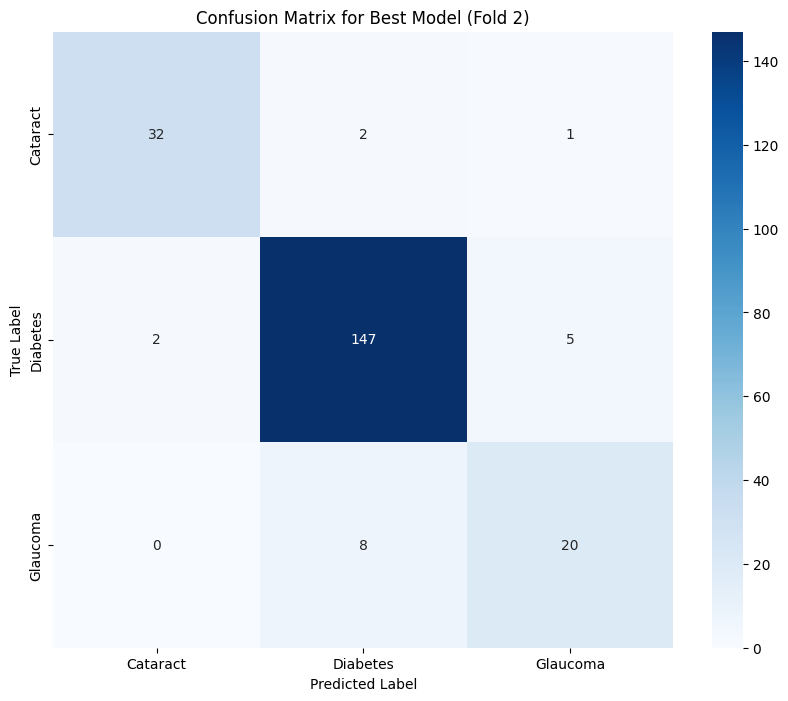



Classification Report for the best model (Fold 2):

              precision    recall  f1-score   support



    Cataract       0.94      0.91      0.93        35

    Diabetes       0.94      0.95      0.95       154

    Glaucoma       0.77      0.71      0.74        28



    accuracy                           0.92       217

   macro avg       0.88      0.86      0.87       217

weighted avg       0.92      0.92      0.92       217



Training and evaluation finished.


In [65]:
# Defining transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing images to 224x224
    transforms.ToTensor(),  # Converting images to tensors
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalizing images (commented out)
])

# Creating the dataset
dataset = datasets.ImageFolder(root=train_dir, transform=transform)  # Loading images from the specified directory and applying transformations

# Defining the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Setting device to GPU if available, otherwise CPU

# Defining the number of epochs and k for k-fold cross-validation
n_epochs = 10  # Number of epochs for training
k = 5  # Number of folds for cross-validation

# Calling the function to train and evaluate the model with k-fold cross-validation
train_and_evaluate_resnet_kfold(dataset=dataset, n_epochs=n_epochs, device=device, k=k)  # Training and evaluating the model using k-fold cross-validation

# resnet50 with image size 448



Fold 1/5

Epoch 1:

  -- Training dataset. Got 643 out of 865 images correctly (74.335%). Epoch loss: 0.655

   - Validation dataset. Got 136 out of 217 images correctly (62.673%). Epoch loss: 2.183

Epoch 2:

  -- Training dataset. Got 699 out of 865 images correctly (80.809%). Epoch loss: 0.530

   - Validation dataset. Got 175 out of 217 images correctly (80.645%). Epoch loss: 0.626

Epoch 3:

  -- Training dataset. Got 710 out of 865 images correctly (82.081%). Epoch loss: 0.422

   - Validation dataset. Got 158 out of 217 images correctly (72.811%). Epoch loss: 0.912

Epoch 4:

  -- Training dataset. Got 743 out of 865 images correctly (85.896%). Epoch loss: 0.382

   - Validation dataset. Got 138 out of 217 images correctly (63.594%). Epoch loss: 1.358

Epoch 5:

  -- Training dataset. Got 742 out of 865 images correctly (85.780%). Epoch loss: 0.382

   - Validation dataset. Got 70 out of 217 images correctly (32.258%). Epoch loss: 9.057

Epoch 6:

  -- Training dataset. Got 72

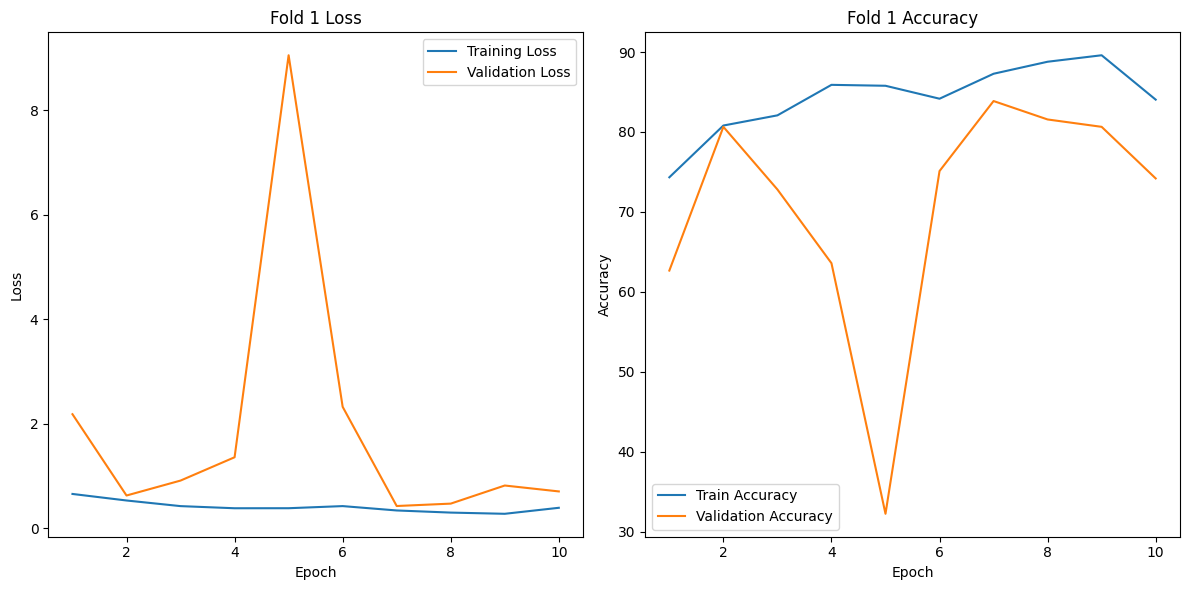



Classification Report for the Best Epoch (Epoch 7) of Fold 1:

              precision    recall  f1-score   support



    Cataract       0.78      0.86      0.82        42

    Diabetes       0.90      0.90      0.90       147

    Glaucoma       0.57      0.46      0.51        28



    accuracy                           0.84       217

   macro avg       0.75      0.74      0.74       217

weighted avg       0.83      0.84      0.83       217





Fold 2/5

Epoch 1:

  -- Training dataset. Got 649 out of 865 images correctly (75.029%). Epoch loss: 0.653

   - Validation dataset. Got 141 out of 217 images correctly (64.977%). Epoch loss: 2.921

Epoch 2:

  -- Training dataset. Got 701 out of 865 images correctly (81.040%). Epoch loss: 0.482

   - Validation dataset. Got 178 out of 217 images correctly (82.028%). Epoch loss: 0.666

Epoch 3:

  -- Training dataset. Got 711 out of 865 images correctly (82.197%). Epoch loss: 0.440

   - Validation dataset. Got 183 out of 217 images co

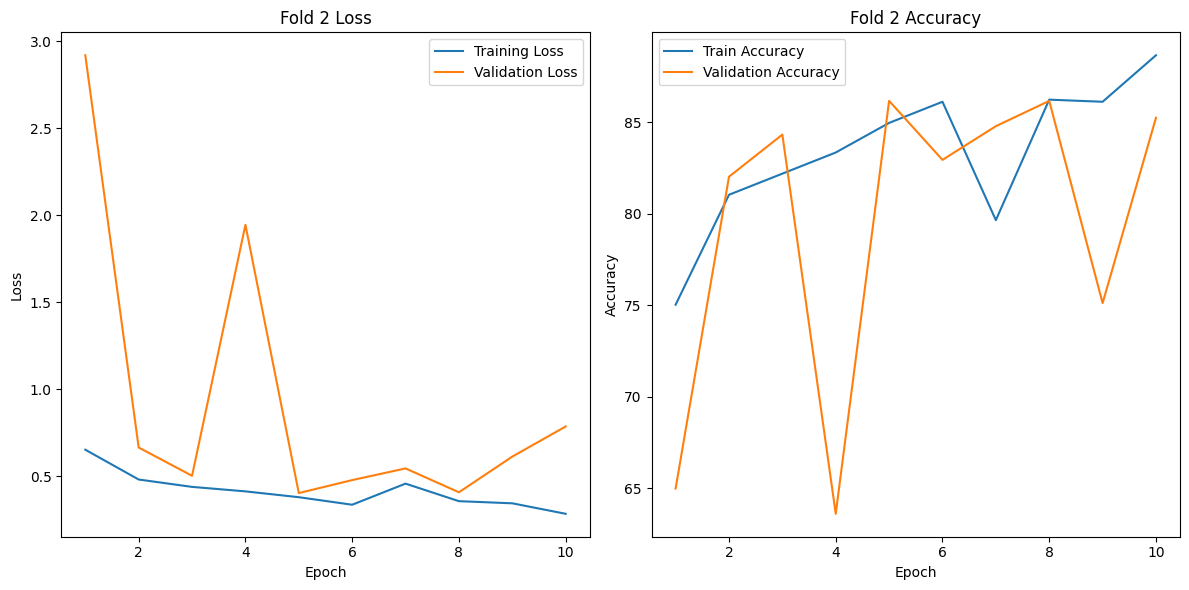



Classification Report for the Best Epoch (Epoch 5) of Fold 2:

              precision    recall  f1-score   support



    Cataract       0.91      0.91      0.91        35

    Diabetes       0.92      0.90      0.91       154

    Glaucoma       0.53      0.61      0.57        28



    accuracy                           0.86       217

   macro avg       0.79      0.81      0.80       217

weighted avg       0.87      0.86      0.86       217





Fold 3/5

Epoch 1:

  -- Training dataset. Got 631 out of 866 images correctly (72.864%). Epoch loss: 0.652

   - Validation dataset. Got 141 out of 216 images correctly (65.278%). Epoch loss: 2.538

Epoch 2:

  -- Training dataset. Got 703 out of 866 images correctly (81.178%). Epoch loss: 0.468

   - Validation dataset. Got 179 out of 216 images correctly (82.870%). Epoch loss: 0.480

Epoch 3:

  -- Training dataset. Got 718 out of 866 images correctly (82.910%). Epoch loss: 0.441

   - Validation dataset. Got 175 out of 216 images co

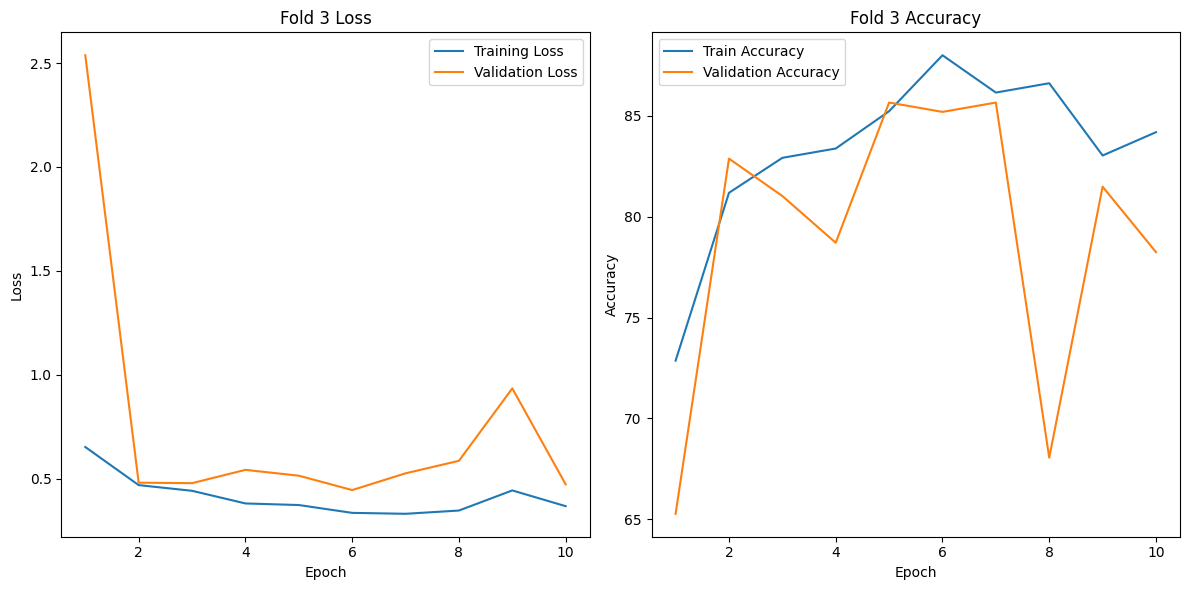



Classification Report for the Best Epoch (Epoch 5) of Fold 3:

              precision    recall  f1-score   support



    Cataract       0.87      0.92      0.90        51

    Diabetes       0.88      0.96      0.92       132

    Glaucoma       0.65      0.33      0.44        33



    accuracy                           0.86       216

   macro avg       0.80      0.74      0.75       216

weighted avg       0.84      0.86      0.84       216





Fold 4/5

Epoch 1:

  -- Training dataset. Got 676 out of 866 images correctly (78.060%). Epoch loss: 0.605

   - Validation dataset. Got 167 out of 216 images correctly (77.315%). Epoch loss: 1.522

Epoch 2:

  -- Training dataset. Got 716 out of 866 images correctly (82.679%). Epoch loss: 0.485

   - Validation dataset. Got 179 out of 216 images correctly (82.870%). Epoch loss: 0.437

Epoch 3:

  -- Training dataset. Got 750 out of 866 images correctly (86.605%). Epoch loss: 0.382

   - Validation dataset. Got 109 out of 216 images co

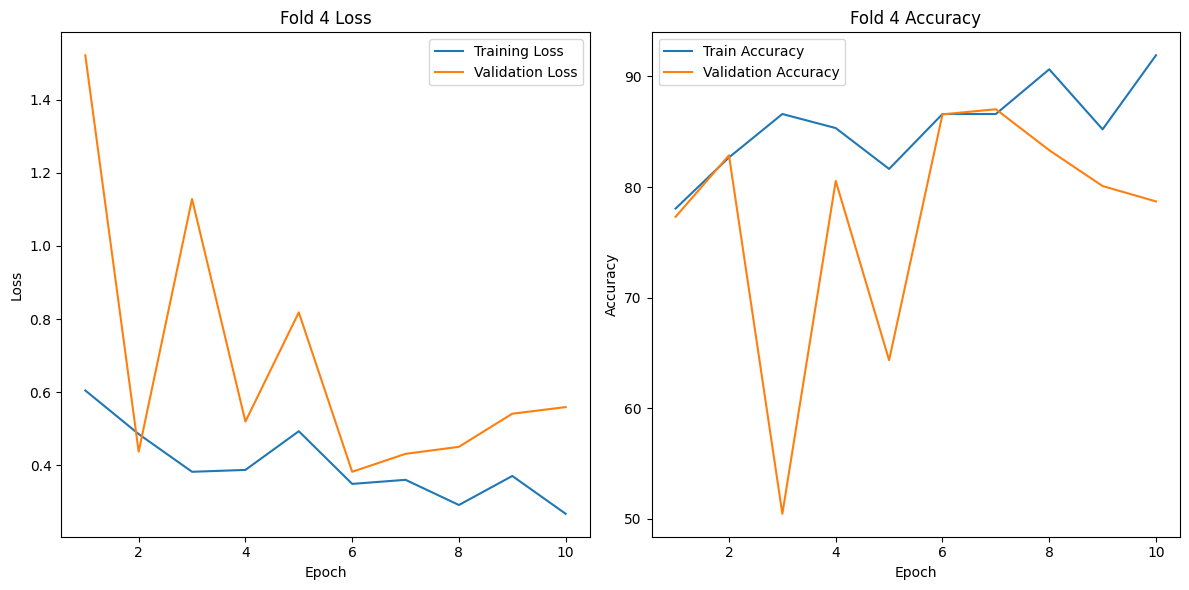



Classification Report for the Best Epoch (Epoch 7) of Fold 4:

              precision    recall  f1-score   support



    Cataract       0.77      0.96      0.85        46

    Diabetes       0.91      0.95      0.93       132

    Glaucoma       0.90      0.47      0.62        38



    accuracy                           0.87       216

   macro avg       0.86      0.79      0.80       216

weighted avg       0.88      0.87      0.86       216





Fold 5/5

Epoch 1:

  -- Training dataset. Got 658 out of 866 images correctly (75.982%). Epoch loss: 0.628

   - Validation dataset. Got 148 out of 216 images correctly (68.519%). Epoch loss: 0.785

Epoch 2:

  -- Training dataset. Got 714 out of 866 images correctly (82.448%). Epoch loss: 0.479

   - Validation dataset. Got 139 out of 216 images correctly (64.352%). Epoch loss: 1.557

Epoch 3:

  -- Training dataset. Got 721 out of 866 images correctly (83.256%). Epoch loss: 0.444

   - Validation dataset. Got 185 out of 216 images co

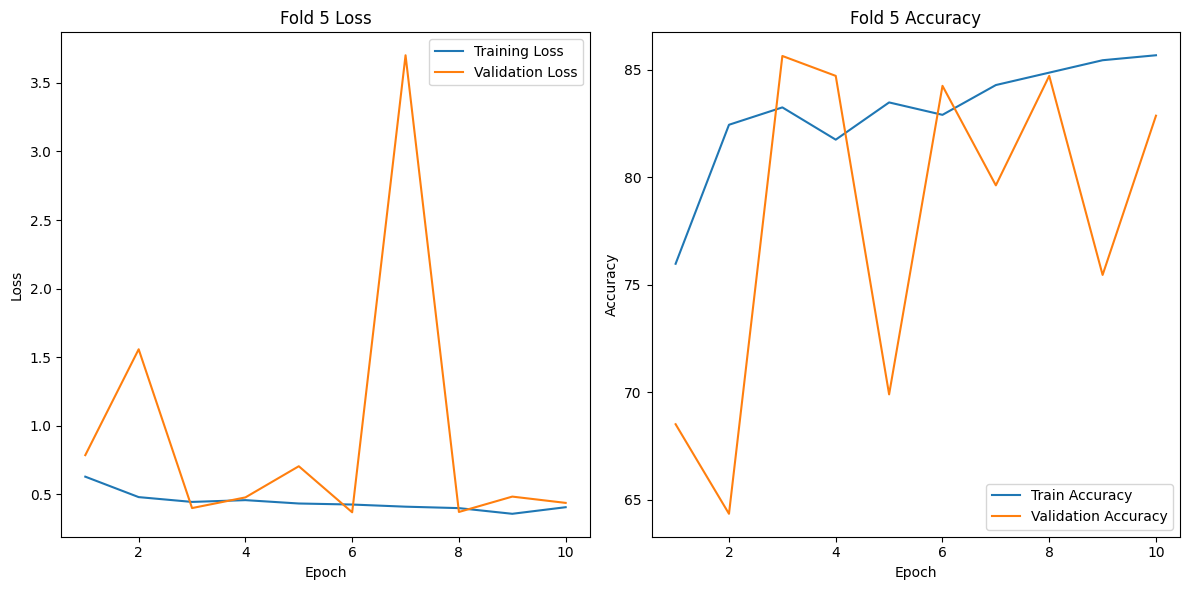



Classification Report for the Best Epoch (Epoch 3) of Fold 5:

              precision    recall  f1-score   support



    Cataract       0.89      0.89      0.89        36

    Diabetes       0.88      0.95      0.91       147

    Glaucoma       0.65      0.39      0.49        33



    accuracy                           0.86       216

   macro avg       0.80      0.75      0.76       216

weighted avg       0.84      0.86      0.84       216





Best overall model from fold 4 with validation accuracy: 87.04%



Confusion Matrix for the best model (Fold 4):


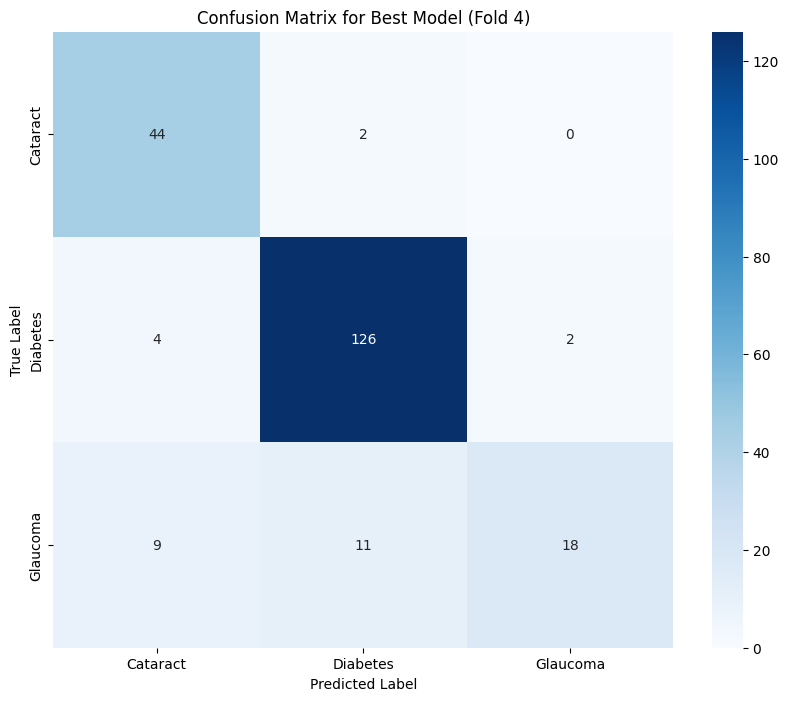



Classification Report for the best model (Fold 4):

              precision    recall  f1-score   support



    Cataract       0.77      0.96      0.85        46

    Diabetes       0.91      0.95      0.93       132

    Glaucoma       0.90      0.47      0.62        38



    accuracy                           0.87       216

   macro avg       0.86      0.79      0.80       216

weighted avg       0.88      0.87      0.86       216



Training and evaluation finished.


In [66]:
# Defining transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((448, 448)),  # Resizing images to 448x448
    transforms.ToTensor(),  # Converting images to tensors
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalizing images (commented out)
])

# Creating the dataset
dataset = datasets.ImageFolder(root=train_dir, transform=transform)  # Loading images from the specified directory and applying transformations

# Defining the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Setting device to GPU if available, otherwise CPU

# Defining the number of epochs and k for k-fold cross-validation
n_epochs = 10  # Number of epochs for training
k = 5  # Number of folds for cross-validation

# Calling the function to train and evaluate the model with k-fold cross-validation
train_and_evaluate_resnet_kfold(dataset=dataset, n_epochs=n_epochs, device=device, k=k)  # Training and evaluating the model using k-fold cross-validation

### Now that we know from the above analysis that, no metter whatever is the sizes of images, the accuracy score for epochs does not change much in numbers, the next experiment is to do hyperparameter tuning on all the algorithms used, to see if it affects the accuracy score or not.

## Experiment - 3 - Getting better parameters using hyper parameter tuning with gridsearchCV

### Exp-3 SimpleCNN 

In [27]:
def train_and_evaluate_cnn(dataset, n_epochs, device, learning_rate, dropout_rate, batch_size):
    num_classes = len(dataset.classes)
    
    # Split dataset into train and validation sets (80-20 split)
    dataset_size = len(dataset)
    indices = np.arange(dataset_size)
    np.random.shuffle(indices)
    split = int(np.floor(0.8 * dataset_size))
    train_idx, val_idx = indices[:split], indices[split:]

    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4)

    model = SimpleCNN(num_classes=num_classes, dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_val_acc = 0
    best_model_state = None

    # Lists to store loss and accuracy for each epoch
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100.0 * correct_train / total_train
        train_losses.append(running_loss / total_train)
        train_accuracies.append(train_accuracy)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
                
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = 100.0 * correct_val / total_val
        val_losses.append(running_val_loss / total_val)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}:")
        print(f"  -- Training dataset. Classified {correct_train} out of {total_train} images to correct labels ({train_accuracy:.3f}%).")
        print(f"  -- Validation dataset. Classified {correct_val} out of {total_val} images to correct labels ({val_accuracy:.3f}%).")

        # Update best model if needed
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_model_state = model.state_dict()

    # Plot training and validation loss and accuracy
    epochs_range = range(1, n_epochs + 1)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')
    plt.show()

    # Evaluate the best model on the validation set
    model.load_state_dict(best_model_state)
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Plot confusion matrix for the best model
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title('Confusion Matrix for the Best Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Classification report for the best model
    report = classification_report(all_labels, all_preds, target_names=dataset.classes)
    print("Classification Report for the Best Model:")
    print(report)

    # Save the best model
    torch.save(best_model_state, f'best_cnn_model_accuracy_{best_val_acc:.2f}.pth')

    print("Training and evaluation finished")
    return best_val_acc



Evaluating with params: {'batch_size': 16, 'dropout_rate': 0.3, 'learning_rate': 0.001}
Epoch 1:
  -- Training dataset. Classified 557 out of 865 images to correct labels (64.393%).
  -- Validation dataset. Classified 146 out of 217 images to correct labels (67.281%).
Epoch 2:
  -- Training dataset. Classified 578 out of 865 images to correct labels (66.821%).
  -- Validation dataset. Classified 145 out of 217 images to correct labels (66.820%).
Epoch 3:
  -- Training dataset. Classified 591 out of 865 images to correct labels (68.324%).
  -- Validation dataset. Classified 136 out of 217 images to correct labels (62.673%).
Epoch 4:
  -- Training dataset. Classified 588 out of 865 images to correct labels (67.977%).
  -- Validation dataset. Classified 144 out of 217 images to correct labels (66.359%).
Epoch 5:
  -- Training dataset. Classified 592 out of 865 images to correct labels (68.439%).
  -- Validation dataset. Classified 147 out of 217 images to correct labels (67.742%).
Epoch 

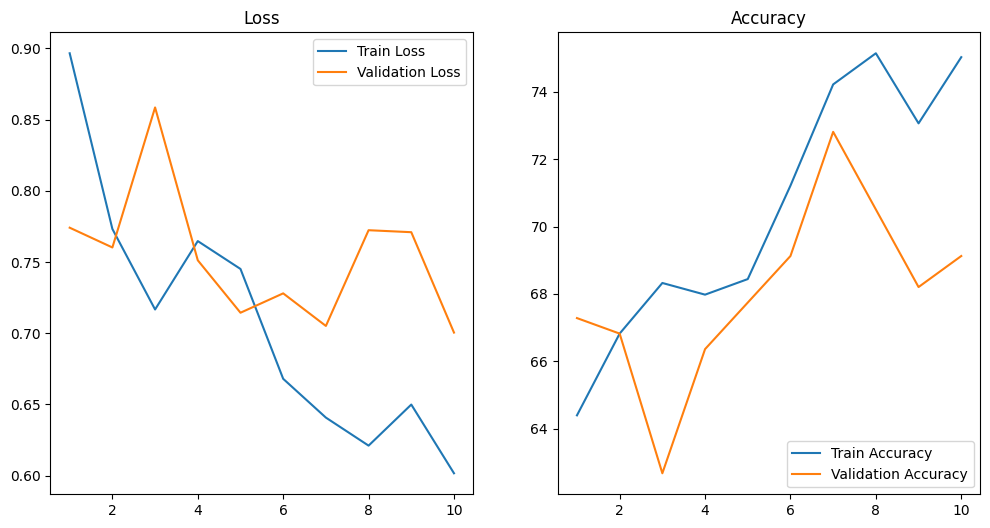

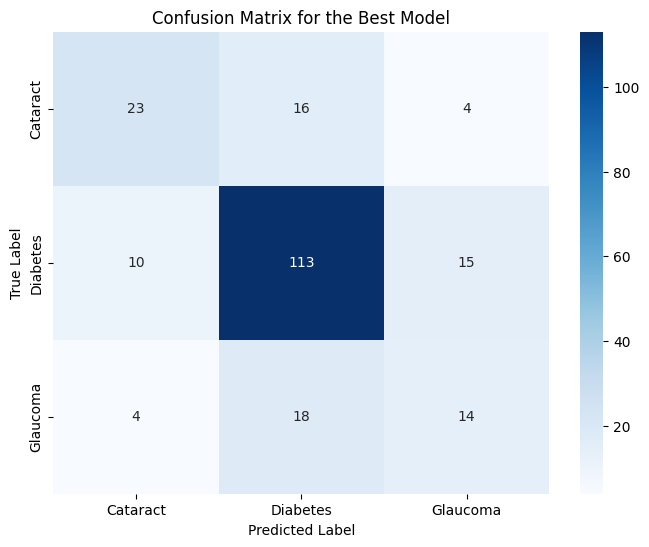

Classification Report for the Best Model:
              precision    recall  f1-score   support

    Cataract       0.62      0.53      0.57        43
    Diabetes       0.77      0.82      0.79       138
    Glaucoma       0.42      0.39      0.41        36

    accuracy                           0.69       217
   macro avg       0.60      0.58      0.59       217
weighted avg       0.68      0.69      0.69       217

Training and evaluation finished

Evaluating with params: {'batch_size': 16, 'dropout_rate': 0.3, 'learning_rate': 0.01}
Epoch 1:
  -- Training dataset. Classified 537 out of 865 images to correct labels (62.081%).
  -- Validation dataset. Classified 146 out of 217 images to correct labels (67.281%).
Epoch 2:
  -- Training dataset. Classified 566 out of 865 images to correct labels (65.434%).
  -- Validation dataset. Classified 146 out of 217 images to correct labels (67.281%).
Epoch 3:
  -- Training dataset. Classified 566 out of 865 images to correct labels (65.434%).


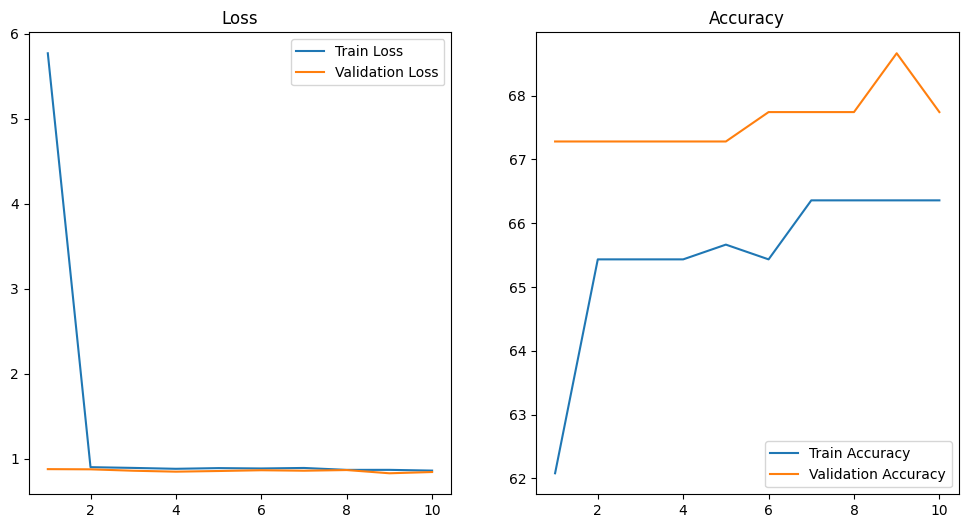

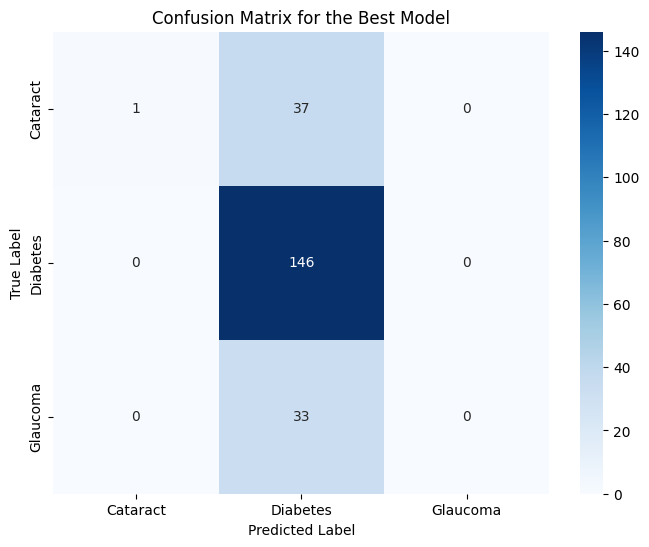

Classification Report for the Best Model:
              precision    recall  f1-score   support

    Cataract       1.00      0.03      0.05        38
    Diabetes       0.68      1.00      0.81       146
    Glaucoma       0.00      0.00      0.00        33

    accuracy                           0.68       217
   macro avg       0.56      0.34      0.29       217
weighted avg       0.63      0.68      0.55       217

Training and evaluation finished

Evaluating with params: {'batch_size': 16, 'dropout_rate': 0.5, 'learning_rate': 0.001}
Epoch 1:
  -- Training dataset. Classified 546 out of 865 images to correct labels (63.121%).
  -- Validation dataset. Classified 144 out of 217 images to correct labels (66.359%).
Epoch 2:
  -- Training dataset. Classified 566 out of 865 images to correct labels (65.434%).
  -- Validation dataset. Classified 144 out of 217 images to correct labels (66.359%).
Epoch 3:
  -- Training dataset. Classified 581 out of 865 images to correct labels (67.168%).

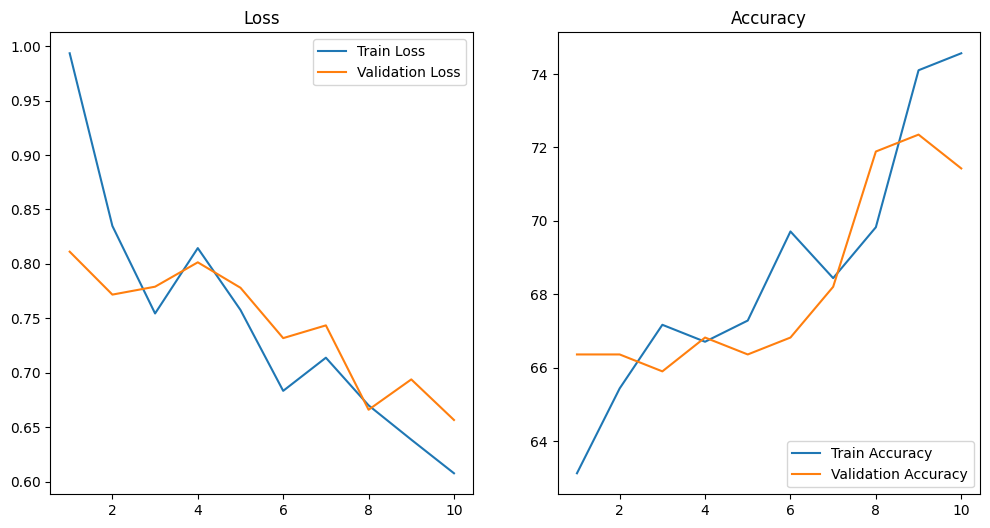

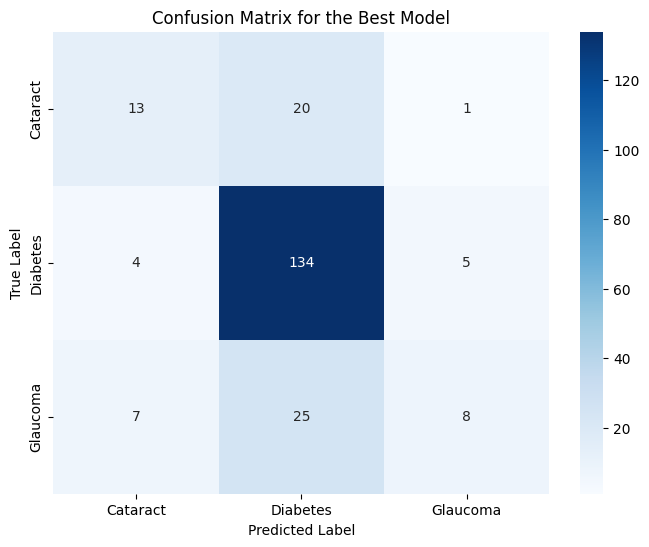

Classification Report for the Best Model:
              precision    recall  f1-score   support

    Cataract       0.54      0.38      0.45        34
    Diabetes       0.75      0.94      0.83       143
    Glaucoma       0.57      0.20      0.30        40

    accuracy                           0.71       217
   macro avg       0.62      0.51      0.53       217
weighted avg       0.68      0.71      0.67       217

Training and evaluation finished

Evaluating with params: {'batch_size': 16, 'dropout_rate': 0.5, 'learning_rate': 0.01}
Epoch 1:
  -- Training dataset. Classified 547 out of 865 images to correct labels (63.237%).
  -- Validation dataset. Classified 140 out of 217 images to correct labels (64.516%).
Epoch 2:
  -- Training dataset. Classified 572 out of 865 images to correct labels (66.127%).
  -- Validation dataset. Classified 140 out of 217 images to correct labels (64.516%).
Epoch 3:
  -- Training dataset. Classified 572 out of 865 images to correct labels (66.127%).


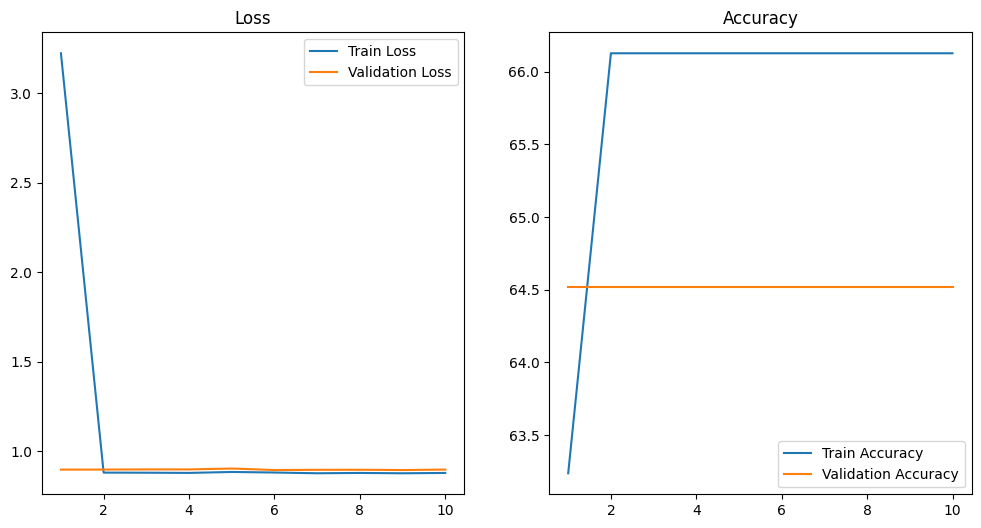

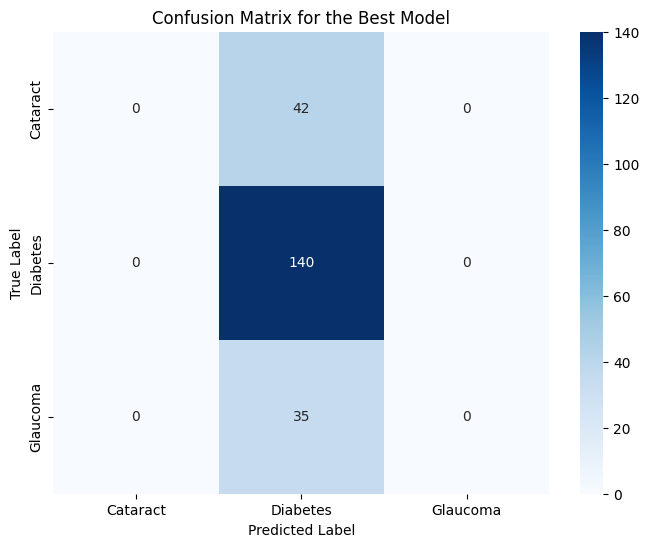

Classification Report for the Best Model:
              precision    recall  f1-score   support

    Cataract       0.00      0.00      0.00        42
    Diabetes       0.65      1.00      0.78       140
    Glaucoma       0.00      0.00      0.00        35

    accuracy                           0.65       217
   macro avg       0.22      0.33      0.26       217
weighted avg       0.42      0.65      0.51       217

Training and evaluation finished

Evaluating with params: {'batch_size': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001}
Epoch 1:
  -- Training dataset. Classified 548 out of 865 images to correct labels (63.353%).
  -- Validation dataset. Classified 144 out of 217 images to correct labels (66.359%).
Epoch 2:
  -- Training dataset. Classified 588 out of 865 images to correct labels (67.977%).
  -- Validation dataset. Classified 136 out of 217 images to correct labels (62.673%).
Epoch 3:
  -- Training dataset. Classified 611 out of 865 images to correct labels (70.636%).

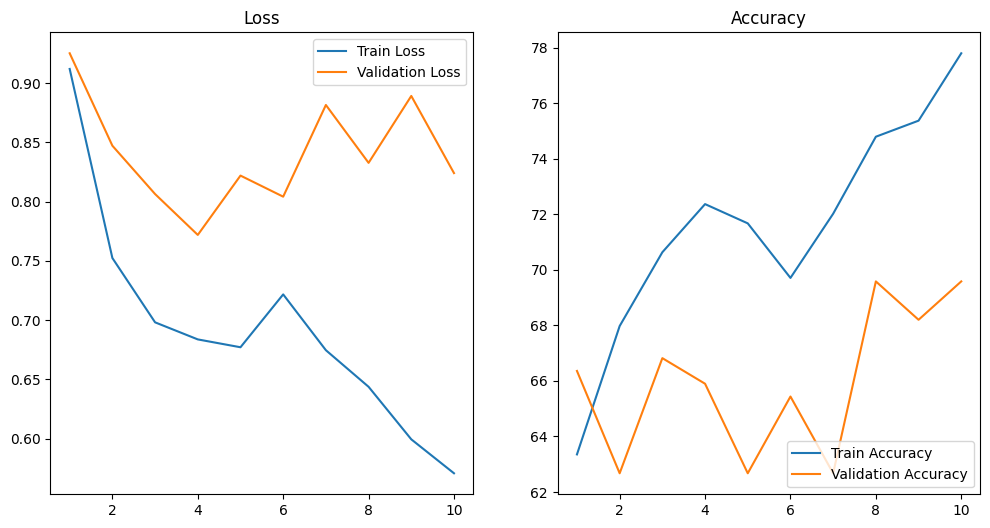

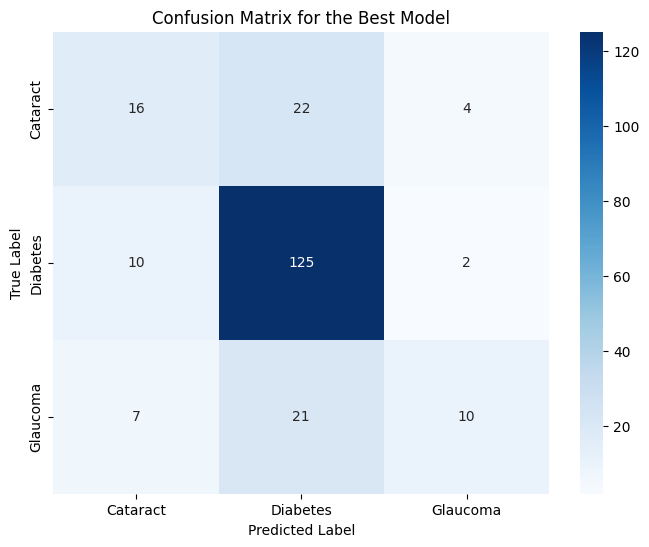

Classification Report for the Best Model:
              precision    recall  f1-score   support

    Cataract       0.48      0.38      0.43        42
    Diabetes       0.74      0.91      0.82       137
    Glaucoma       0.62      0.26      0.37        38

    accuracy                           0.70       217
   macro avg       0.62      0.52      0.54       217
weighted avg       0.67      0.70      0.66       217

Training and evaluation finished

Evaluating with params: {'batch_size': 32, 'dropout_rate': 0.3, 'learning_rate': 0.01}
Epoch 1:
  -- Training dataset. Classified 526 out of 865 images to correct labels (60.809%).
  -- Validation dataset. Classified 150 out of 217 images to correct labels (69.124%).
Epoch 2:
  -- Training dataset. Classified 562 out of 865 images to correct labels (64.971%).
  -- Validation dataset. Classified 150 out of 217 images to correct labels (69.124%).
Epoch 3:
  -- Training dataset. Classified 563 out of 865 images to correct labels (65.087%).


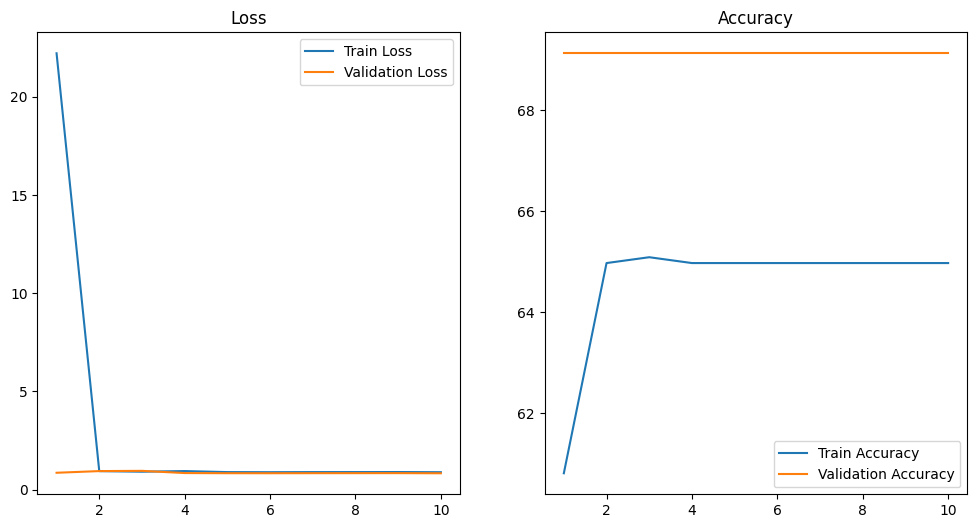

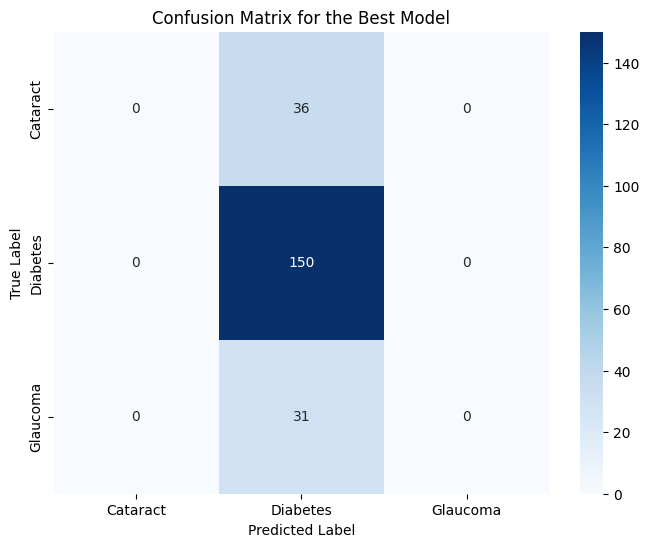

Classification Report for the Best Model:
              precision    recall  f1-score   support

    Cataract       0.00      0.00      0.00        36
    Diabetes       0.69      1.00      0.82       150
    Glaucoma       0.00      0.00      0.00        31

    accuracy                           0.69       217
   macro avg       0.23      0.33      0.27       217
weighted avg       0.48      0.69      0.57       217

Training and evaluation finished

Evaluating with params: {'batch_size': 32, 'dropout_rate': 0.5, 'learning_rate': 0.001}
Epoch 1:
  -- Training dataset. Classified 530 out of 865 images to correct labels (61.272%).
  -- Validation dataset. Classified 151 out of 217 images to correct labels (69.585%).
Epoch 2:
  -- Training dataset. Classified 579 out of 865 images to correct labels (66.936%).
  -- Validation dataset. Classified 164 out of 217 images to correct labels (75.576%).
Epoch 3:
  -- Training dataset. Classified 574 out of 865 images to correct labels (66.358%).

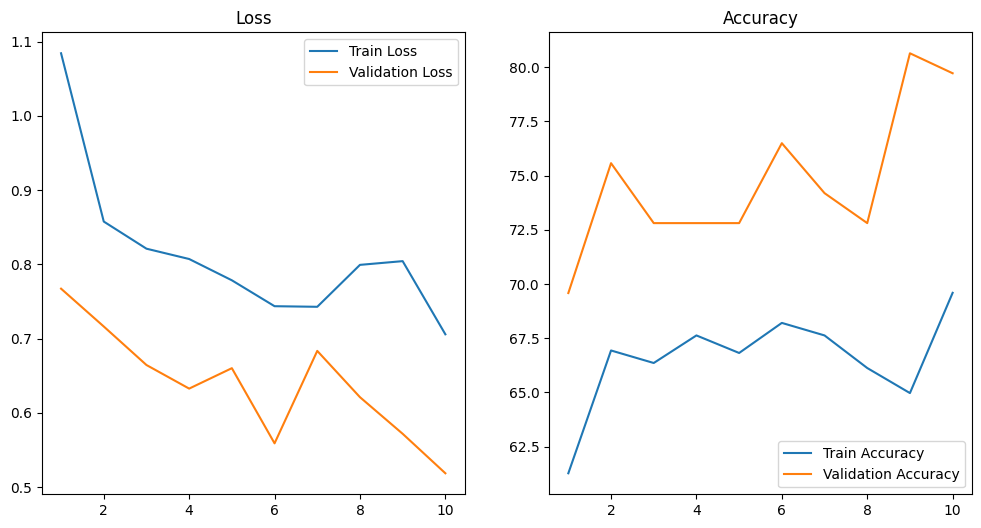

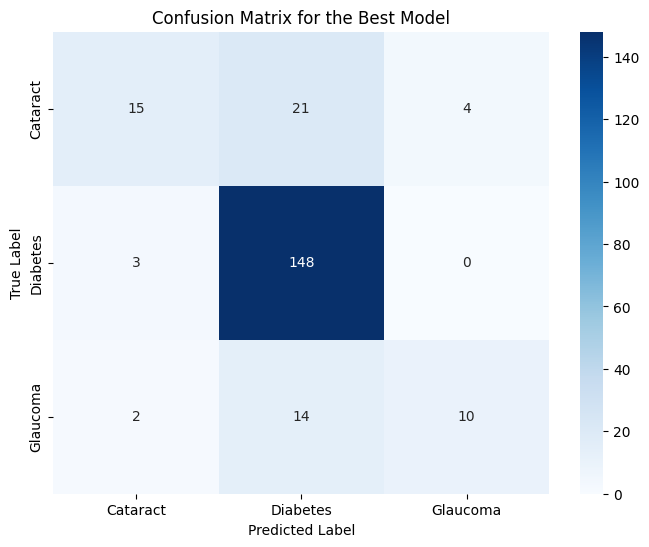

Classification Report for the Best Model:
              precision    recall  f1-score   support

    Cataract       0.75      0.38      0.50        40
    Diabetes       0.81      0.98      0.89       151
    Glaucoma       0.71      0.38      0.50        26

    accuracy                           0.80       217
   macro avg       0.76      0.58      0.63       217
weighted avg       0.79      0.80      0.77       217

Training and evaluation finished

Evaluating with params: {'batch_size': 32, 'dropout_rate': 0.5, 'learning_rate': 0.01}
Epoch 1:
  -- Training dataset. Classified 457 out of 865 images to correct labels (52.832%).
  -- Validation dataset. Classified 134 out of 217 images to correct labels (61.751%).
Epoch 2:
  -- Training dataset. Classified 578 out of 865 images to correct labels (66.821%).
  -- Validation dataset. Classified 134 out of 217 images to correct labels (61.751%).
Epoch 3:
  -- Training dataset. Classified 578 out of 865 images to correct labels (66.821%).


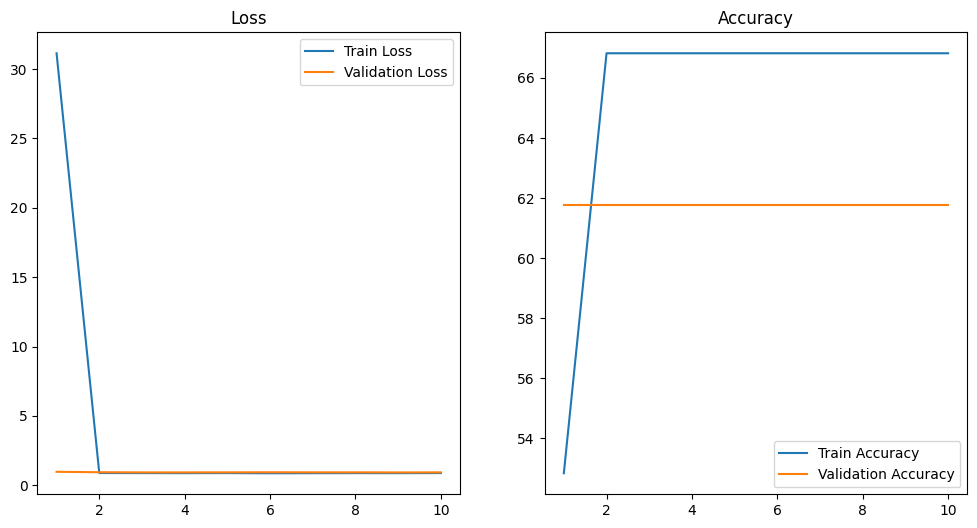

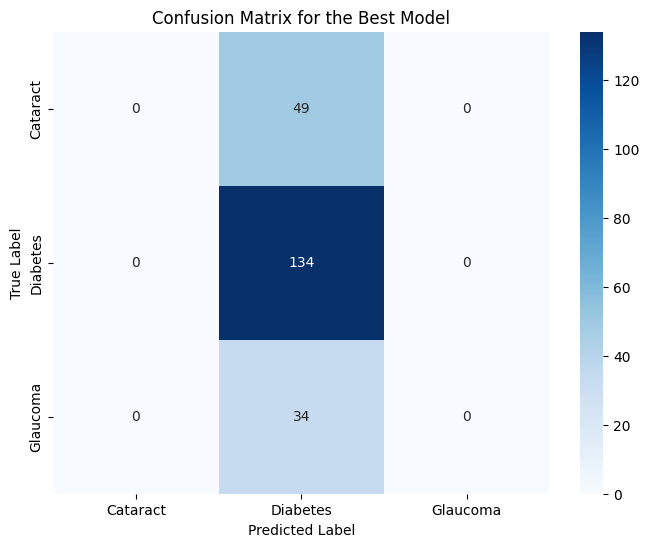

Classification Report for the Best Model:
              precision    recall  f1-score   support

    Cataract       0.00      0.00      0.00        49
    Diabetes       0.62      1.00      0.76       134
    Glaucoma       0.00      0.00      0.00        34

    accuracy                           0.62       217
   macro avg       0.21      0.33      0.25       217
weighted avg       0.38      0.62      0.47       217

Training and evaluation finished
Best Accuracy: 80.65%
Best Parameters: {'batch_size': 32, 'dropout_rate': 0.5, 'learning_rate': 0.001}


In [28]:
# Hyperparameter grid
param_grid = {
    'learning_rate': [0.001, 0.01],
    'batch_size': [16, 32],
    'dropout_rate': [0.3, 0.5]
}

grid = ParameterGrid(param_grid)

best_acc = 0
best_params = {}

# Evaluate different parameter combinations
for params in grid:
    print(f"\nEvaluating with params: {params}")
    best_val_acc = train_and_evaluate_cnn(
        dataset=dataset,
        n_epochs=10,
        device=device,
        learning_rate=params['learning_rate'],
        dropout_rate=params['dropout_rate'],
        batch_size=params['batch_size']
    )

    # Check the best parameters
    if best_val_acc > best_acc:
        best_acc = best_val_acc
        best_params = params

print(f"Best Accuracy: {best_acc:.2f}%")
print(f"Best Parameters: {best_params}")

# Training model with this parameteres, checkeing the model performance with this parameters and see what results we get

In [33]:
def train_and_evaluate_cnnParams(dataset: datasets.ImageFolder, n_epochs: int, device: torch.device,
                                 learning_rate: float = 0.001, dropout_rate: float = 0.5):
    num_classes = len(dataset.classes)

    # Splitting the dataset into training and validation sets
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_subset, val_subset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=4)

    # Initializing the model, loss function, and optimizer
    model = SimpleCNN(num_classes=num_classes, dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_acc = 0
    best_model = None
    train_acc_history = []
    val_acc_history = []
    epoch_losses = []
    best_labels = []
    best_preds = []

    # Training and evaluating the model for a specified number of epochs
    for epoch in range(n_epochs):
        model.train()  # Setting the model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Iterating over batches of training data
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Clearing previous gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculating loss
            loss.backward()  # Backward pass
            optimizer.step()  # Updating model parameters

            running_loss += loss.item() * images.size(0)  # Accumulating loss
            _, predicted = torch.max(outputs, 1)  # Getting the predicted labels
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()  # Counting correct predictions

        train_accuracy = 100.0 * correct_train / total_train
        train_acc_history.append(train_accuracy)
        epoch_loss = running_loss / total_train
        epoch_losses.append(epoch_loss)

        model.eval()  # Setting the model to evaluation mode
        correct_val = 0
        total_val = 0
        fold_labels = []
        fold_preds = []

        with torch.no_grad():  # Disabling gradient calculation
            # Iterating over batches of validation data
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                fold_labels.extend(labels.cpu().numpy())  # Collecting true labels
                fold_preds.extend(predicted.cpu().numpy())  # Collecting predicted labels

        val_accuracy = 100.0 * correct_val / total_val
        val_acc_history.append(val_accuracy)

        # Printing metrics for the current epoch
        print(f"Epoch {epoch + 1}:")
        print(f"  -- Training dataset. Got {correct_train} out of {total_train} images correctly ({train_accuracy:.3f}%). Epoch loss: {epoch_loss:.3f}")
        print(f"  -- Validation dataset. Got {correct_val} out of {total_val} images correctly ({val_accuracy:.3f}%)")

        # Saving the model if it achieves the best validation accuracy so far
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            best_model = model.state_dict()
            best_labels = fold_labels
            best_preds = fold_preds

    # Plotting the loss and accuracy metrics for the training process
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, n_epochs + 1), epoch_losses, label='Epoch Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, n_epochs + 1), train_acc_history, label='Train Accuracy')
    plt.plot(range(1, n_epochs + 1), val_acc_history, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plotting the confusion matrix for the best model
    if best_model:
        cm = confusion_matrix(best_labels, best_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
        plt.title('Confusion Matrix for the Best Model')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

        # Printing the classification report for the best model
        report = classification_report(best_labels, best_preds, target_names=dataset.classes)
        print("Classification Report for the Best Model:")
        print(report)

        # Saving the best model after all epochs are completed
        torch.save(best_model, f'best_cnn_model_accuracy_{best_acc:.2f}.pth')

    print("Training and evaluation finished")



Epoch 1:
  -- Training dataset. Got 500 out of 865 images correctly (57.803%). Epoch loss: 1.622
  -- Validation dataset. Got 154 out of 217 images correctly (70.968%)
Epoch 2:
  -- Training dataset. Got 558 out of 865 images correctly (64.509%). Epoch loss: 0.896
  -- Validation dataset. Got 154 out of 217 images correctly (70.968%)
Epoch 3:
  -- Training dataset. Got 558 out of 865 images correctly (64.509%). Epoch loss: 0.860
  -- Validation dataset. Got 154 out of 217 images correctly (70.968%)
Epoch 4:
  -- Training dataset. Got 558 out of 865 images correctly (64.509%). Epoch loss: 0.822
  -- Validation dataset. Got 156 out of 217 images correctly (71.889%)
Epoch 5:
  -- Training dataset. Got 562 out of 865 images correctly (64.971%). Epoch loss: 0.805
  -- Validation dataset. Got 157 out of 217 images correctly (72.350%)
Epoch 6:
  -- Training dataset. Got 575 out of 865 images correctly (66.474%). Epoch loss: 0.784
  -- Validation dataset. Got 155 out of 217 images correctly (7

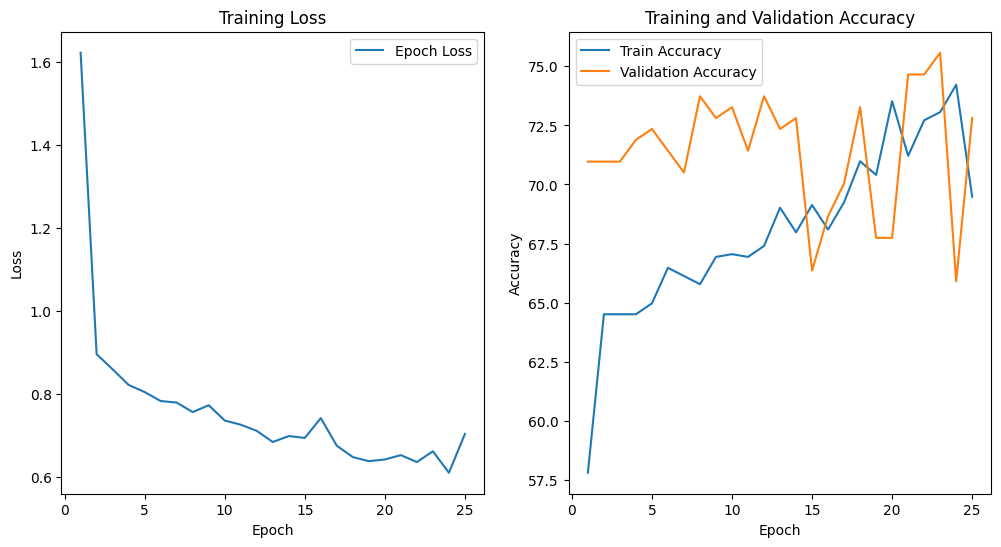

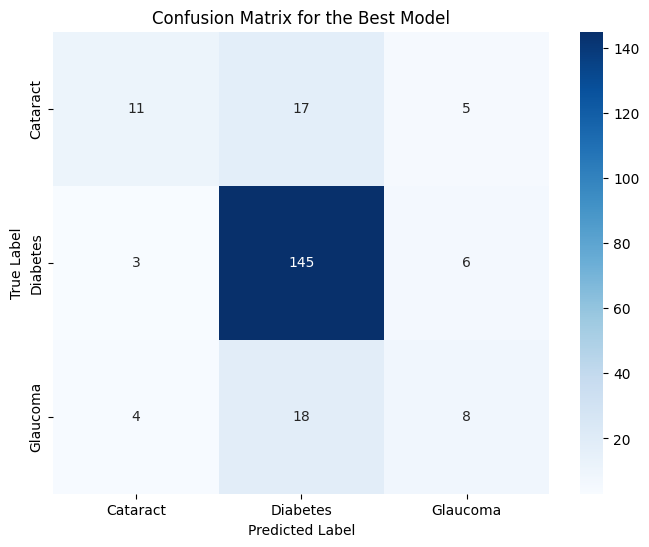

Classification Report for the Best Model:
              precision    recall  f1-score   support

    Cataract       0.61      0.33      0.43        33
    Diabetes       0.81      0.94      0.87       154
    Glaucoma       0.42      0.27      0.33        30

    accuracy                           0.76       217
   macro avg       0.61      0.51      0.54       217
weighted avg       0.72      0.76      0.73       217

Training and evaluation finished


In [34]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int, dropout_rate: float):
        super(SimpleCNN, self).__init__()
        # Defining the feature extraction layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Convolutional layer with 32 filters
            nn.ReLU(),  # Applying ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # Applying max pooling
            nn.Dropout(dropout_rate),  # Applying dropout for regularization
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Convolutional layer with 64 filters
            nn.ReLU(),  # Applying ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # Applying max pooling
            nn.Dropout(dropout_rate),  # Applying dropout for regularization
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Convolutional layer with 128 filters
            nn.ReLU(),  # Applying ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # Applying max pooling
            nn.Dropout(dropout_rate),  # Applying dropout for regularization
        )
        # Defining the classifier layers
        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 256),  # Fully connected layer with 256 units
            nn.ReLU(),  # Applying ReLU activation
            nn.Dropout(dropout_rate),  # Applying dropout for regularization
            nn.Linear(256, num_classes)  # Output layer with number of classes
        )
        
    def forward(self, x):
        # Forward pass through the feature extraction layers
        x = self.features(x)
        # Flattening the tensor for the fully connected layers
        x = x.view(x.size(0), -1)
        # Forward pass through the classifier layers
        x = self.classifier(x)
        return x


# Defining transformations for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing the images to 224x224
    transforms.ToTensor(),  # Converting images to tensor format
])

# Creating the dataset with the specified transformations
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

# Defining the device for training (CUDA if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Defining the number of epochs for training
n_epochs = 25

# Calling the function to train and evaluate the model
train_and_evaluate_cnnParams(dataset=dataset, n_epochs=n_epochs, device=device)